In [1]:
import numpy as np
from collections import defaultdict

import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt

import heapq

import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

import numpy as np
import torch
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import pandas as pd

from tqdm import tqdm

In [2]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [11]:
data_df = pd.read_csv('generated_images/data.csv')
data_df

num_shapes   shape_0 color_0 position_0  \
0             1  pentagon     red         BL   
1             1  pentagon     red         BR   
2             1    square     red         TR   
3             1   hexagon   black          M   
4             1    square    blue          M   
..          ...       ...     ...        ...   
495           5  pentagon    blue         BR   
496           5  pentagon    pink         BR   
497           5  triangle    blue          M   
498           5    square  yellow         BL   
499           5  triangle    pink         TR   

                                   filename   shape_1 color_1 position_1  \
0     generated_images/image_1_shapes_0.png       NaN     NaN        NaN   
1     generated_images/image_1_shapes_1.png       NaN     NaN        NaN   
2     generated_images/image_1_shapes_2.png       NaN     NaN        NaN   
3     generated_images/image_1_shapes_3.png       NaN     NaN        NaN   
4     generated_images/image_1_shapes_4.png       NaN     NaN        NaN   
..                                      ...       ...     ...        ...   
495  generated_images/image_5_shapes_95.png  triangle   black         BL   
496  generated_images/image_5_shapes_96.png   hexagon  yellow         BL   
497  generated_images/image_5_shapes_97.png   hexagon    pink         BR   
498  generated_images/image_5_shapes_98.png   hexagon     red         BR   
499  generated_images/image_5_shapes_99.png   hexagon     red         BL   

      shape_2 color_2 position_2   shape_3 color_3 position_3   shape_4  \
0         NaN     NaN        NaN       NaN     NaN        NaN       NaN   
1         NaN     NaN        NaN       NaN     NaN        NaN       NaN   
2         NaN     NaN        NaN       NaN     NaN        NaN       NaN   
3         NaN     NaN        NaN       NaN     NaN        NaN       NaN   
4         NaN     NaN        NaN       NaN     NaN        NaN       NaN   
..        ...     ...        ...       ...     ...        ...       ...   
495   hexagon  yellow          M    square   green         TL    circle   
496    circle     red         TL    square    blue          M  triangle   
497    circle   green         TL  pentagon     red         TR    square   
498  triangle    pink         TL    circle    blue          M  pentagon   
499  pentagon  yellow         BR    circle   green         TL    square   

    color_4 position_4  
0       NaN        NaN  
1       NaN        NaN  
2       NaN        NaN  
3       NaN        NaN  
4       NaN        NaN  
..      ...        ...  
495    pink         TR  
496   green         TR  
497  yellow         BL  
498   black         TR  
499   black          M  

[500 rows x 17 columns]

In [ ]:
activations_df = pd.read_csv('clip_224/clip_mlp_activations.csv')
activations_df

filename  mean_0_0   max_0_0  mean_0_1  \
0     generated_images/image_1_shapes_0.png  0.099164  0.257024  0.298203   
1     generated_images/image_1_shapes_1.png  0.098868  0.236394  0.298659   
2     generated_images/image_1_shapes_2.png  0.098371  0.198219  0.294899   
3     generated_images/image_1_shapes_3.png  0.105667  0.350031  0.310025   
4     generated_images/image_1_shapes_4.png  0.102984  0.147678  0.304164   
..                                      ...       ...       ...       ...   
495  generated_images/image_5_shapes_95.png  0.102451  0.214196  0.264764   
496  generated_images/image_5_shapes_96.png  0.099824  0.218822  0.254907   
497  generated_images/image_5_shapes_97.png  0.099764  0.249264  0.256887   
498  generated_images/image_5_shapes_98.png  0.101962  0.418774  0.262032   
499  generated_images/image_5_shapes_99.png  0.103397  0.357409  0.258777   

      max_0_1  mean_0_2   max_0_2  mean_0_3   max_0_3  mean_0_4  ...  \
0    0.333471  0.059541  0.090624  0.108643  0.212754  0.022055  ...   
1    0.333518  0.059578  0.093828  0.108109  0.198275  0.022334  ...   
2    0.335975  0.057270  0.078525  0.102543  0.166103  0.021096  ...   
3    0.336265  0.058159  0.078626  0.111158  0.305242  0.023447  ...   
4    0.331992  0.063006  0.108819  0.106660  0.195209  0.021967  ...   
..        ...       ...       ...       ...       ...       ...  ...   
495  0.334364  0.047601  0.123497  0.108762  0.324152  0.021233  ...   
496  0.332797  0.048234  0.107941  0.103577  0.216401  0.023336  ...   
497  0.336022  0.047266  0.098838  0.109927  0.263641  0.019197  ...   
498  0.412612  0.047812  0.127314  0.110888  0.263006  0.021316  ...   
499  0.339922  0.042366  0.097323  0.109440  0.302322  0.021856  ...   

     mean_23_1019  max_23_1019  mean_23_1020  max_23_1020  mean_23_1021  \
0       -0.171294     0.034744      0.227626     0.437658     -0.130334   
1       -0.159002     0.128170      0.228707     0.454122     -0.121280   
2       -0.183971     0.081780      0.185437     0.404024     -0.099349   
3       -0.175808     0.136730      0.170698     0.396673     -0.065466   
4       -0.175748     0.019588      0.204655     0.394590     -0.124101   
..            ...          ...           ...          ...           ...   
495     -0.142009     0.198176      0.214031     0.480671     -0.096051   
496     -0.147976     0.131034      0.200914     0.431632     -0.085056   
497     -0.151952     0.087928      0.201548     0.435799     -0.080965   
498     -0.147790     0.160468      0.201102     0.431684     -0.064188   
499     -0.161215     0.134967      0.178246     0.446600     -0.049667   

     max_23_1021  mean_23_1022  max_23_1022  mean_23_1023  max_23_1023  
0       0.179163     -0.228286     0.008854     -0.119478     0.226579  
1       0.225495     -0.221970     0.040223     -0.119355     0.224534  
2       0.141499     -0.227266    -0.016253     -0.099449     0.229580  
3       0.173172     -0.210550     0.142581     -0.052900     0.315388  
4       0.192931     -0.233677    -0.016928     -0.109357     0.350109  
..           ...           ...          ...           ...          ...  
495     0.227638     -0.217189     0.180153     -0.043028     0.357173  
496     0.267447     -0.210242     0.221128     -0.054774     0.284328  
497     0.278892     -0.212384     0.200994     -0.059827     0.318426  
498     0.318274     -0.208776     0.170633     -0.040669     0.427834  
499     0.189478     -0.207668     0.101181     -0.021281     0.343884  

[500 rows x 49153 columns]

In [ ]:
neuron_names = list(activations_df.columns[1:])
len(neuron_names) # Should be 1024 * 24 * 2 = 49152

In [ ]:
mode = 'mean'

neuron_names = [x for x in neuron_names if mode in x]
len(neuron_names) # Should be 1024 * 24 = 24576

In [16]:
def layer_num(neuron_name):
    return int(neuron_name.split('_')[1])

In [ ]:
last_n_layers = 24
neuron_names = [x for x in neuron_names if layer_num(x) >= 24 - last_n_layers]
len(neuron_names) # Should be 1024 * last_n_layers

In [ ]:
top_k_activations = 100
all_neuron_characteristics = []

# Optimize DataFrame lookup by setting filename as an index
data_df = data_df.set_index("filename")

for neuron_name in tqdm(neuron_names, total=len(neuron_names)):
    activations = activations_df[neuron_name].values
    top_activations = heapq.nlargest(top_k_activations, enumerate(activations), key=lambda x: x[1])

    neuron_characteristics = {
        'avg_num_shapes': 0.0,
        'avg_circle': 0.0,
        'avg_square': 0.0,
        'avg_triangle': 0.0,
        'avg_pentagon': 0.0,
        'avg_hexagon': 0.0,
        'avg_red': 0.0,
        'avg_green': 0.0,
        'avg_blue': 0.0,
        'avg_yellow': 0.0,
        'avg_pink': 0.0,
        'avg_black': 0.0,
        'avg_M': 0.0,
        'avg_TL': 0.0,
        'avg_TR': 0.0,
        'avg_BL': 0.0,
        'avg_BR': 0.0,
    }

    for i, _ in top_activations:
        file_name = activations_df.iloc[i]['filename']
        image_data = data_df.loc[file_name]

        neuron_characteristics['avg_num_shapes'] += image_data['num_shapes']

        for j in range(image_data['num_shapes']):
            neuron_characteristics[f'avg_{image_data[f"color_{j}"]}'] += 1
            neuron_characteristics[f'avg_{image_data[f"shape_{j}"]}'] += 1
            neuron_characteristics[f'avg_{image_data[f"position_{j}"]}'] += 1

    # Convert sums to averages
    for key in neuron_characteristics:
        neuron_characteristics[key] /= top_k_activations

    neuron_characteristics['neuron_name'] = neuron_name
    all_neuron_characteristics.append(neuron_characteristics)

In [ ]:
neuron_characteristics_df = pd.DataFrame(all_neuron_characteristics)
neuron_characteristics_df

In [27]:
def calculate_entropy(row):
    entropy = 0
    keys = [key for key in row.keys() if not key in ['neuron_name', 'avg_num_shapes']]
    row = row[keys]
    row_sum = sum(row.values)
    for key in row.keys():
        if key.startswith('avg_'):
            p = row[key] / row_sum
            # p = row[key]
            if p > 0:
                entropy += -p * np.log2(p)
    return entropy

In [28]:
neuron_characteristics_df['entropy'] = neuron_characteristics_df.apply(calculate_entropy, axis=1)
neuron_characteristics_df

avg_num_shapes  avg_circle  avg_square  avg_triangle  avg_pentagon  \
0            1.266667    0.166667    0.400000      0.033333      0.466667   
1            1.033333    0.300000    0.033333      0.133333      0.500000   
2            4.300000    0.900000    0.966667      0.933333      0.633333   
3            1.066667    0.233333    0.033333      0.033333      0.433333   
4            1.400000    0.566667    0.000000      0.733333      0.033333   
...               ...         ...         ...           ...           ...   
10235        4.233333    0.800000    0.900000      0.833333      0.900000   
10236        1.966667    0.633333    0.333333      0.366667      0.400000   
10237        3.766667    0.700000    1.000000      0.700000      0.633333   
10238        4.300000    0.966667    0.833333      0.733333      0.900000   
10239        4.700000    0.966667    1.000000      0.933333      0.866667   

       avg_hexagon   avg_red  avg_green  avg_blue  avg_yellow  avg_pink  \
0         0.200000  0.200000   0.200000  0.066667    0.100000  0.133333   
1         0.066667  0.133333   0.033333  0.033333    0.300000  0.266667   
2         0.866667  0.666667   0.666667  0.800000    0.566667  0.700000   
3         0.333333  0.133333   0.266667  0.166667    0.266667  0.233333   
4         0.066667  0.133333   0.333333  0.233333    0.233333  0.200000   
...            ...       ...        ...       ...         ...       ...   
10235     0.800000  0.700000   0.433333  0.800000    0.933333  0.666667   
10236     0.233333  0.133333   0.166667  0.200000    0.800000  0.433333   
10237     0.733333  0.633333   0.500000  0.500000    0.433333  0.700000   
10238     0.866667  0.666667   0.666667  0.766667    0.700000  0.666667   
10239     0.933333  0.666667   0.700000  0.766667    0.666667  0.900000   

       avg_black     avg_M    avg_TL    avg_TR    avg_BL    avg_BR  \
0       0.566667  0.000000  0.133333  0.033333  0.300000  0.800000   
1       0.266667  0.133333  0.133333  0.000000  0.400000  0.366667   
2       0.900000  0.966667  0.933333  0.800000  0.733333  0.866667   
3       0.000000  0.500000  0.233333  0.100000  0.066667  0.166667   
4       0.266667  0.500000  0.100000  0.133333  0.333333  0.333333   
...          ...       ...       ...       ...       ...       ...   
10235   0.700000  1.000000  0.800000  0.800000  0.833333  0.800000   
10236   0.233333  0.433333  0.433333  0.400000  0.300000  0.400000   
10237   1.000000  0.700000  0.600000  0.766667  0.766667  0.933333   
10238   0.833333  0.900000  0.833333  0.833333  0.800000  0.933333   
10239   1.000000  1.000000  0.866667  0.866667  0.966667  1.000000   

        neuron_name   entropy  
0         mean_14_0  3.453314  
1         mean_14_1  3.542005  
2         mean_14_2  3.982080  
3         mean_14_3  3.617702  
4         mean_14_4  3.585032  
...             ...       ...  
10235  mean_23_1019  3.980404  
10236  mean_23_1020  3.861107  
10237  mean_23_1021  3.962788  
10238  mean_23_1022  3.990011  
10239  mean_23_1023  3.986983  

[10240 rows x 19 columns]

In [ ]:
neuron_characteristics_df.to_csv(f'clip_224/clip_mlp_neuron_characteristics_{mode}_top_{top_k_activations}_last_{last_n_layers}_layers.csv', index=False)

In [ ]:
neuron_characteristics_df = pd.read_csv('clip_224/clip_mlp_neuron_characteristics_mean_top_30_last_5_layers.csv')
neuron_characteristics_df

avg_num_shapes  avg_circle  avg_square  avg_triangle  avg_pentagon  \
0            1.266667    0.166667    0.400000      0.033333      0.466667   
1            1.033333    0.300000    0.033333      0.133333      0.500000   
2            4.300000    0.900000    0.966667      0.933333      0.633333   
3            1.066667    0.233333    0.033333      0.033333      0.433333   
4            1.400000    0.566667    0.000000      0.733333      0.033333   
...               ...         ...         ...           ...           ...   
10235        4.233333    0.800000    0.900000      0.833333      0.900000   
10236        1.966667    0.633333    0.333333      0.366667      0.400000   
10237        3.766667    0.700000    1.000000      0.700000      0.633333   
10238        4.300000    0.966667    0.833333      0.733333      0.900000   
10239        4.700000    0.966667    1.000000      0.933333      0.866667   

       avg_hexagon   avg_red  avg_green  avg_blue  avg_yellow  avg_pink  \
0         0.200000  0.200000   0.200000  0.066667    0.100000  0.133333   
1         0.066667  0.133333   0.033333  0.033333    0.300000  0.266667   
2         0.866667  0.666667   0.666667  0.800000    0.566667  0.700000   
3         0.333333  0.133333   0.266667  0.166667    0.266667  0.233333   
4         0.066667  0.133333   0.333333  0.233333    0.233333  0.200000   
...            ...       ...        ...       ...         ...       ...   
10235     0.800000  0.700000   0.433333  0.800000    0.933333  0.666667   
10236     0.233333  0.133333   0.166667  0.200000    0.800000  0.433333   
10237     0.733333  0.633333   0.500000  0.500000    0.433333  0.700000   
10238     0.866667  0.666667   0.666667  0.766667    0.700000  0.666667   
10239     0.933333  0.666667   0.700000  0.766667    0.666667  0.900000   

       avg_black     avg_M    avg_TL    avg_TR    avg_BL    avg_BR  \
0       0.566667  0.000000  0.133333  0.033333  0.300000  0.800000   
1       0.266667  0.133333  0.133333  0.000000  0.400000  0.366667   
2       0.900000  0.966667  0.933333  0.800000  0.733333  0.866667   
3       0.000000  0.500000  0.233333  0.100000  0.066667  0.166667   
4       0.266667  0.500000  0.100000  0.133333  0.333333  0.333333   
...          ...       ...       ...       ...       ...       ...   
10235   0.700000  1.000000  0.800000  0.800000  0.833333  0.800000   
10236   0.233333  0.433333  0.433333  0.400000  0.300000  0.400000   
10237   1.000000  0.700000  0.600000  0.766667  0.766667  0.933333   
10238   0.833333  0.900000  0.833333  0.833333  0.800000  0.933333   
10239   1.000000  1.000000  0.866667  0.866667  0.966667  1.000000   

        neuron_name   entropy  
0         mean_14_0  3.453314  
1         mean_14_1  3.542005  
2         mean_14_2  3.982080  
3         mean_14_3  3.617702  
4         mean_14_4  3.585032  
...             ...       ...  
10235  mean_23_1019  3.980404  
10236  mean_23_1020  3.861107  
10237  mean_23_1021  3.962788  
10238  mean_23_1022  3.990011  
10239  mean_23_1023  3.986983  

[10240 rows x 19 columns]

In [37]:
# filter neurons only in the last n layers
last_n_layers = 10
neuron_characteristics_df = neuron_characteristics_df[neuron_characteristics_df['neuron_name'].apply(lambda x: layer_num(x) >= 24 - last_n_layers)]

In [38]:
def get_top_features(neuron_characteristics_df, neuron_name, top_k=3):
    neuron_row = neuron_characteristics_df[neuron_characteristics_df['neuron_name'] == neuron_name].iloc[0]
    neuron_key_values = [(key, neuron_row[key]) for key in neuron_row.keys() if key not in ['neuron_name', 'entropy', 'avg_num_shapes']]
    neuron_key_values = sorted(neuron_key_values, key=lambda x: x[1], reverse=True)
    neuron_key_values = [(x[0].replace("avg_", ""), x[1]) for x in neuron_key_values]
    return neuron_key_values[:top_k]

get_top_features(neuron_characteristics_df, 'mean_14_475', top_k=5)

[('circle', np.float64(0.5666666666666667)),
 ('square', np.float64(0.5)),
 ('pink', np.float64(0.4)),
 ('red', np.float64(0.3)),
 ('TL', np.float64(0.3))]

In [39]:
# for neuron_name in low_entropy_neurons['neuron_name']:
#     print(neuron_name)
#     top_feats = get_top_features(low_entropy_neurons, neuron_name, top_k=5)
#     top_feats = [x[0].replace("avg_", "") for x in top_feats]
#     print(top_feats)
#     print('')
#     print('')

In [40]:
# Get neurons with lowest k entropy
low_entropy_k = 100
low_entropy_neurons = neuron_characteristics_df.sort_values(by='entropy').head(low_entropy_k)
low_entropy_neurons

avg_num_shapes  avg_circle  avg_square  avg_triangle  avg_pentagon  \
475         1.066667    0.566667    0.500000      0.000000      0.000000   
3846        1.133333    0.900000    0.166667      0.000000      0.033333   
991         1.000000    0.733333    0.100000      0.166667      0.000000   
4021        1.066667    0.566667    0.233333      0.166667      0.100000   
1828        1.266667    0.066667    0.433333      0.100000      0.333333   
...              ...         ...         ...           ...           ...   
3039        1.100000    0.566667    0.233333      0.000000      0.300000   
6295        1.000000    0.433333    0.100000      0.166667      0.166667   
4687        1.133333    0.633333    0.066667      0.066667      0.300000   
5834        1.133333    0.366667    0.100000      0.166667      0.400000   
5725        1.266667    0.333333    0.033333      0.400000      0.300000   

      avg_hexagon   avg_red  avg_green  avg_blue  avg_yellow  avg_pink  \
475      0.000000  0.300000   0.133333  0.000000    0.233333  0.400000   
3846     0.033333  0.233333   0.133333  0.066667    0.233333  0.466667   
991      0.000000  0.166667   0.200000  0.166667    0.100000  0.366667   
4021     0.000000  0.133333   0.000000  0.000000    0.266667  0.666667   
1828     0.333333  0.233333   0.233333  0.233333    0.000000  0.133333   
...           ...       ...        ...       ...         ...       ...   
3039     0.000000  0.166667   0.066667  0.100000    0.266667  0.500000   
6295     0.133333  0.033333   0.266667  0.200000    0.133333  0.333333   
4687     0.066667  0.200000   0.000000  0.066667    0.400000  0.466667   
5834     0.100000  0.066667   0.333333  0.266667    0.200000  0.200000   
5725     0.200000  0.033333   0.300000  0.366667    0.400000  0.100000   

      avg_black     avg_M    avg_TL    avg_TR    avg_BL    avg_BR  \
475    0.000000  0.033333  0.300000  0.200000  0.266667  0.266667   
3846   0.000000  0.333333  0.400000  0.166667  0.166667  0.066667   
991    0.000000  0.466667  0.266667  0.133333  0.100000  0.033333   
4021   0.000000  0.200000  0.366667  0.100000  0.233333  0.166667   
1828   0.433333  0.000000  0.000000  0.000000  0.433333  0.833333   
...         ...       ...       ...       ...       ...       ...   
3039   0.000000  0.066667  0.433333  0.133333  0.300000  0.166667   
6295   0.033333  0.733333  0.100000  0.000000  0.133333  0.033333   
4687   0.000000  0.366667  0.300000  0.200000  0.233333  0.033333   
5834   0.066667  0.833333  0.200000  0.000000  0.100000  0.000000   
5725   0.066667  0.833333  0.333333  0.000000  0.033333  0.066667   

      neuron_name   entropy  
475   mean_14_475  3.258612  
3846  mean_17_774  3.299331  
991   mean_14_991  3.313325  
4021  mean_17_949  3.319119  
1828  mean_15_804  3.319193  
...           ...       ...  
3039  mean_16_991  3.428546  
6295  mean_20_151  3.428838  
4687  mean_18_591  3.429126  
5834  mean_19_714  3.429361  
5725  mean_19_605  3.429810  

[100 rows x 19 columns]

mean_14_475
[('circle', np.float64(0.5666666666666667)), ('square', np.float64(0.5)), ('pink', np.float64(0.4)), ('red', np.float64(0.3)), ('TL', np.float64(0.3))]
Neuron: mean_14_475


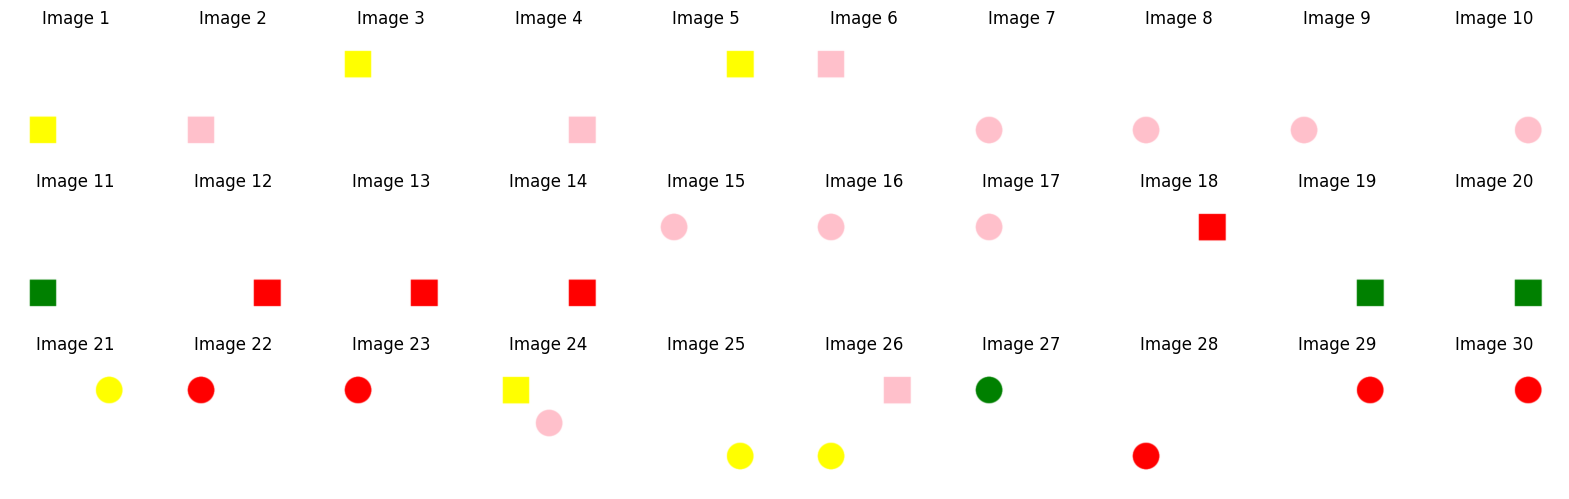

mean_17_774
[('circle', np.float64(0.9)), ('pink', np.float64(0.4666666666666667)), ('TL', np.float64(0.4)), ('M', np.float64(0.3333333333333333)), ('red', np.float64(0.2333333333333333))]
Neuron: mean_17_774


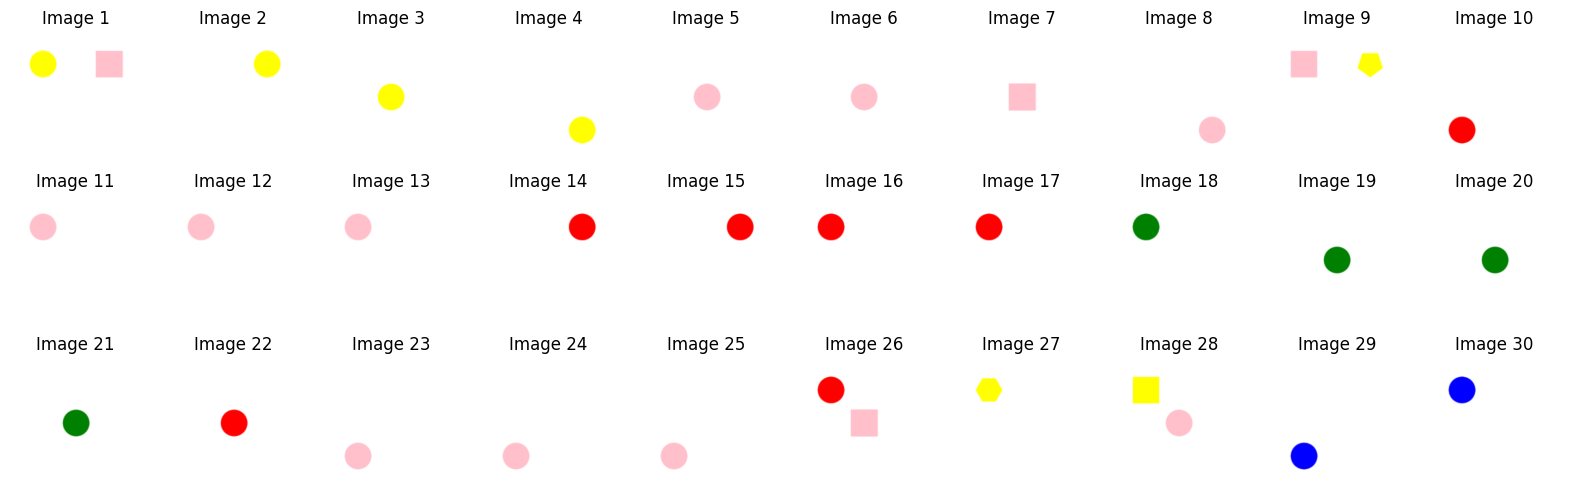

mean_14_991
[('circle', np.float64(0.7333333333333333)), ('M', np.float64(0.4666666666666667)), ('pink', np.float64(0.3666666666666666)), ('TL', np.float64(0.2666666666666666)), ('green', np.float64(0.2))]
Neuron: mean_14_991


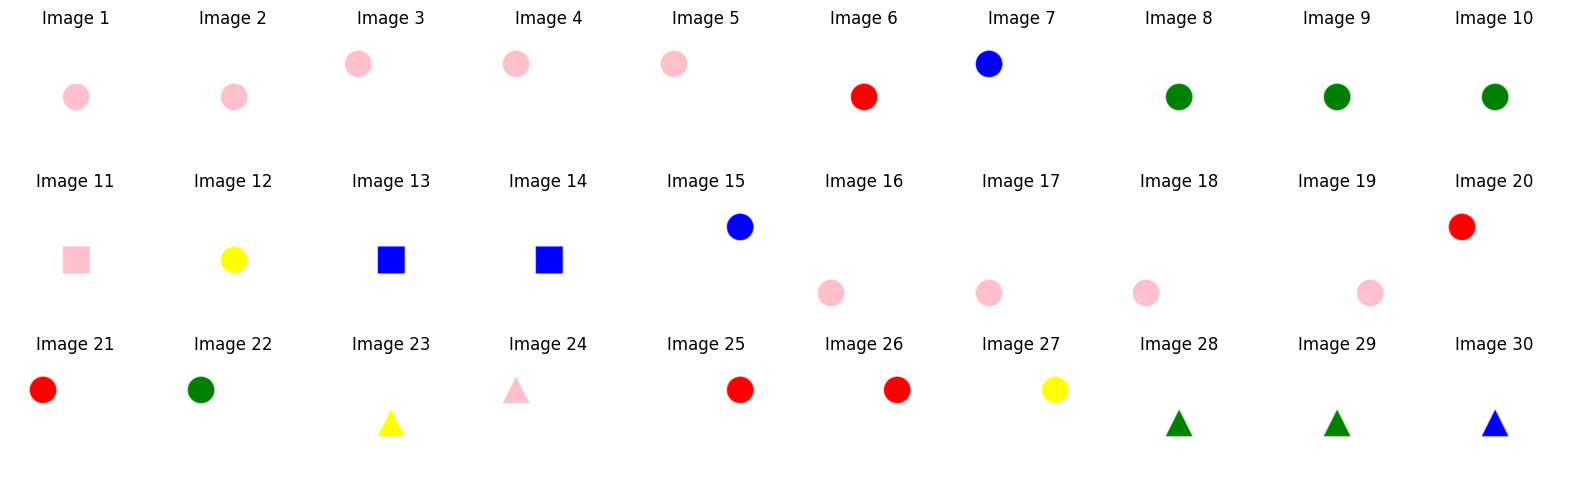

mean_17_949
[('pink', np.float64(0.6666666666666666)), ('circle', np.float64(0.5666666666666667)), ('TL', np.float64(0.3666666666666666)), ('yellow', np.float64(0.2666666666666666)), ('square', np.float64(0.2333333333333333))]
Neuron: mean_17_949


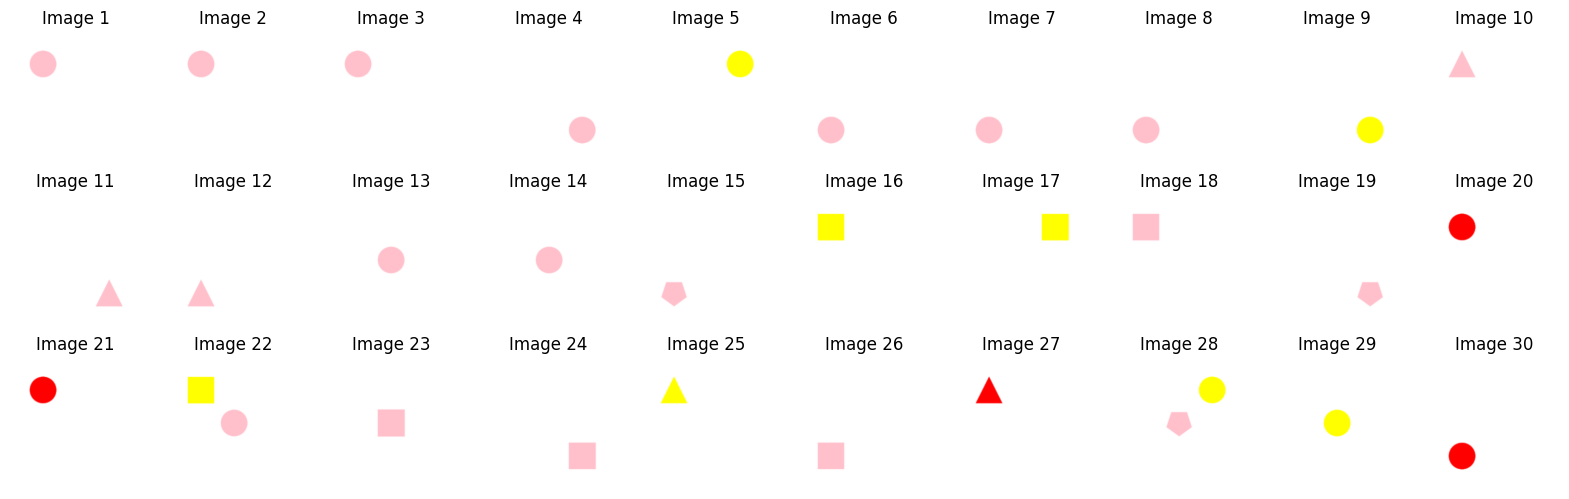

mean_15_804
[('BR', np.float64(0.8333333333333334)), ('square', np.float64(0.4333333333333333)), ('black', np.float64(0.4333333333333333)), ('BL', np.float64(0.4333333333333333)), ('pentagon', np.float64(0.3333333333333333))]
Neuron: mean_15_804


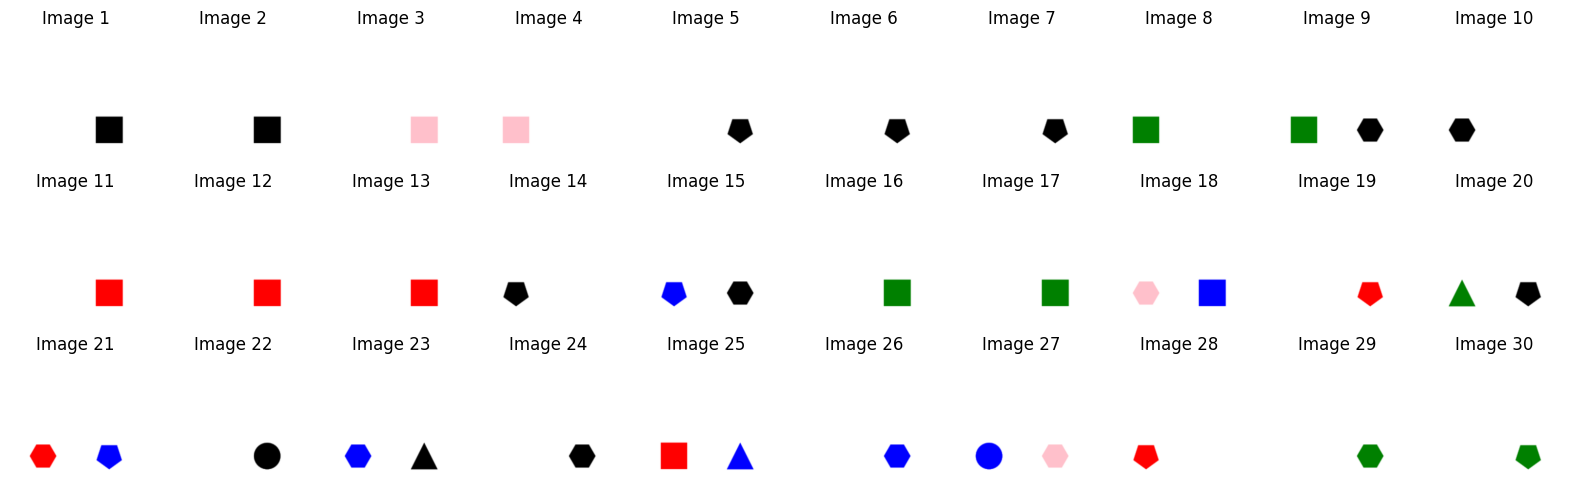

mean_16_309
[('pink', np.float64(0.5)), ('circle', np.float64(0.4333333333333333)), ('square', np.float64(0.3666666666666666)), ('BR', np.float64(0.3666666666666666)), ('TL', np.float64(0.3))]
Neuron: mean_16_309


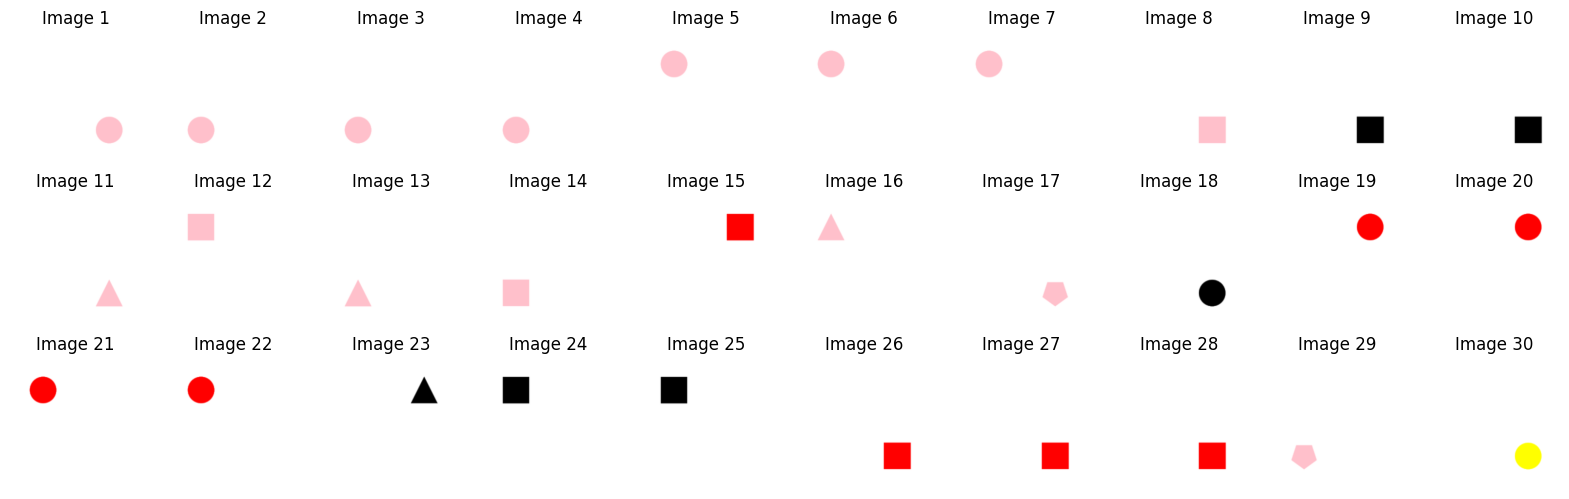

mean_19_239
[('M', np.float64(0.6)), ('circle', np.float64(0.5666666666666667)), ('pink', np.float64(0.4333333333333333)), ('pentagon', np.float64(0.2666666666666666)), ('blue', np.float64(0.2666666666666666))]
Neuron: mean_19_239


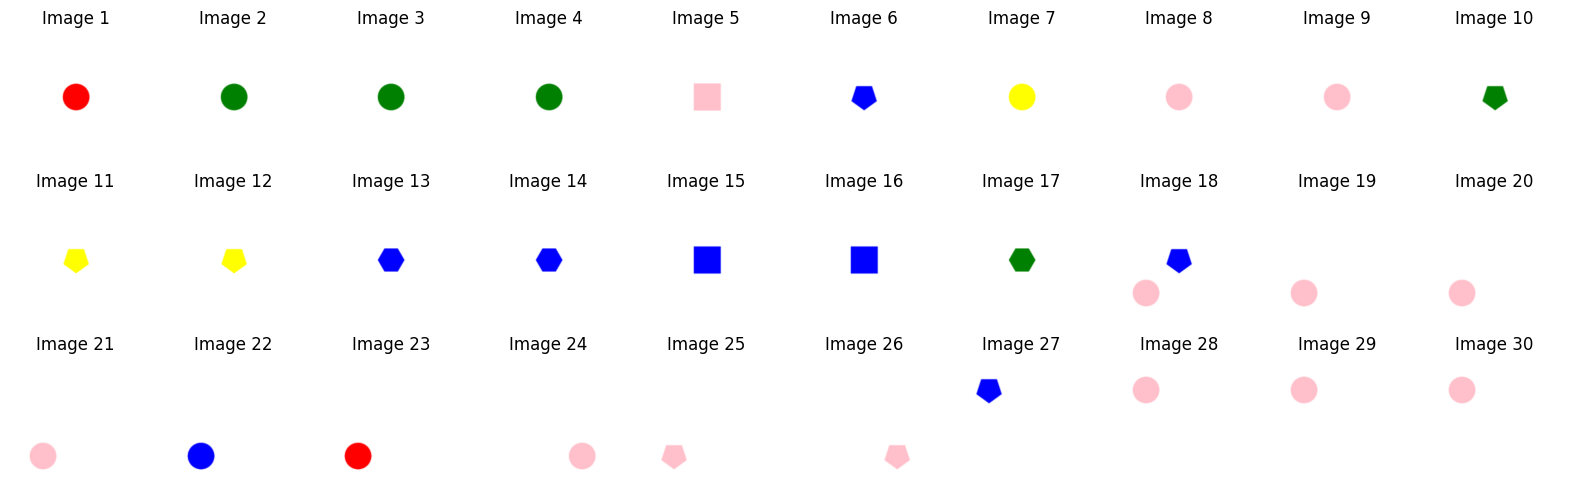

mean_22_447
[('circle', np.float64(0.6)), ('M', np.float64(0.6)), ('pentagon', np.float64(0.4666666666666667)), ('pink', np.float64(0.3666666666666666)), ('TL', np.float64(0.3))]
Neuron: mean_22_447


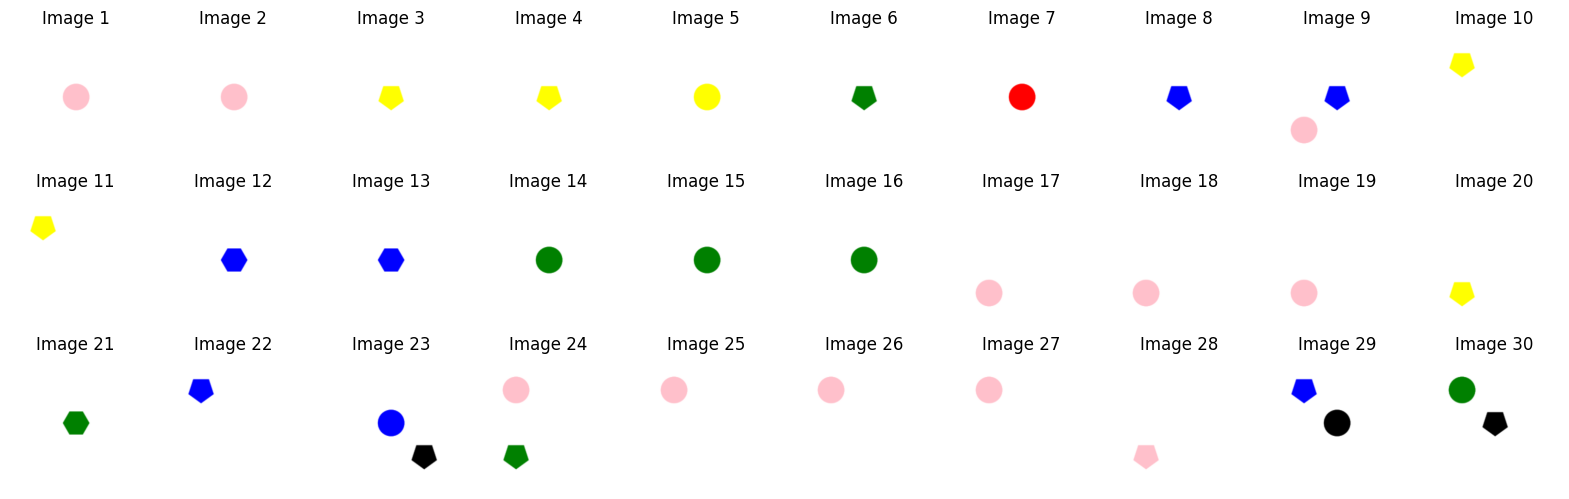

mean_15_391
[('BR', np.float64(0.7666666666666667)), ('square', np.float64(0.4)), ('black', np.float64(0.3666666666666666)), ('BL', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.3333333333333333))]
Neuron: mean_15_391


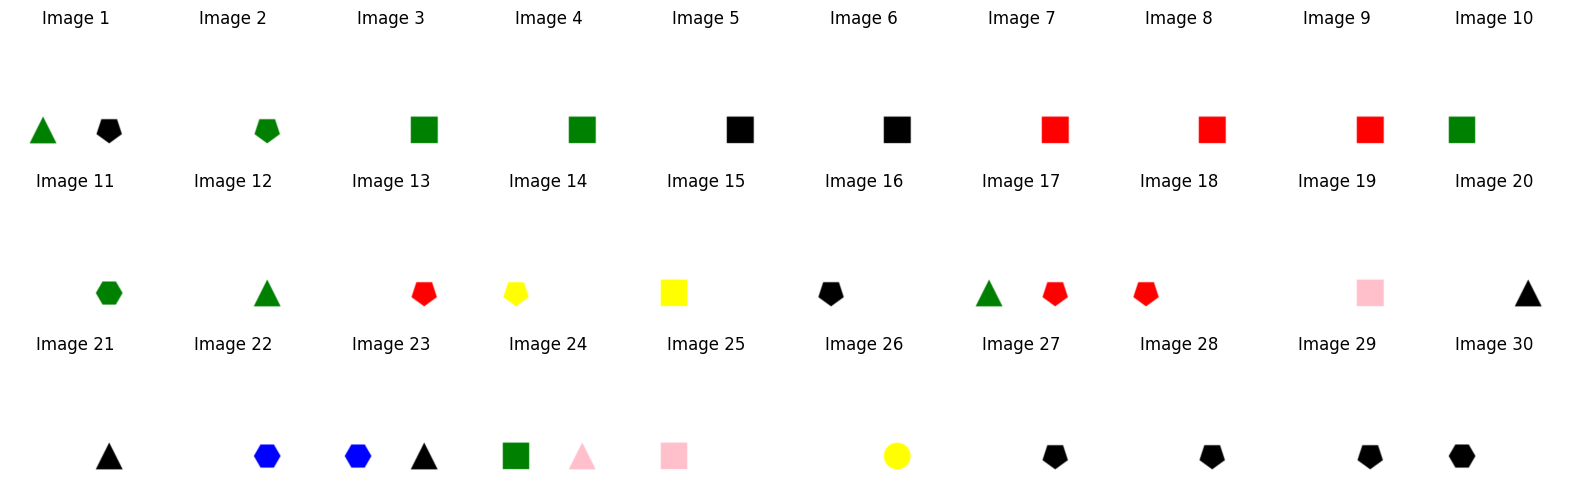

mean_15_60
[('square', np.float64(0.5333333333333333)), ('BR', np.float64(0.5)), ('pentagon', np.float64(0.4333333333333333)), ('black', np.float64(0.2666666666666666)), ('pink', np.float64(0.2333333333333333))]
Neuron: mean_15_60


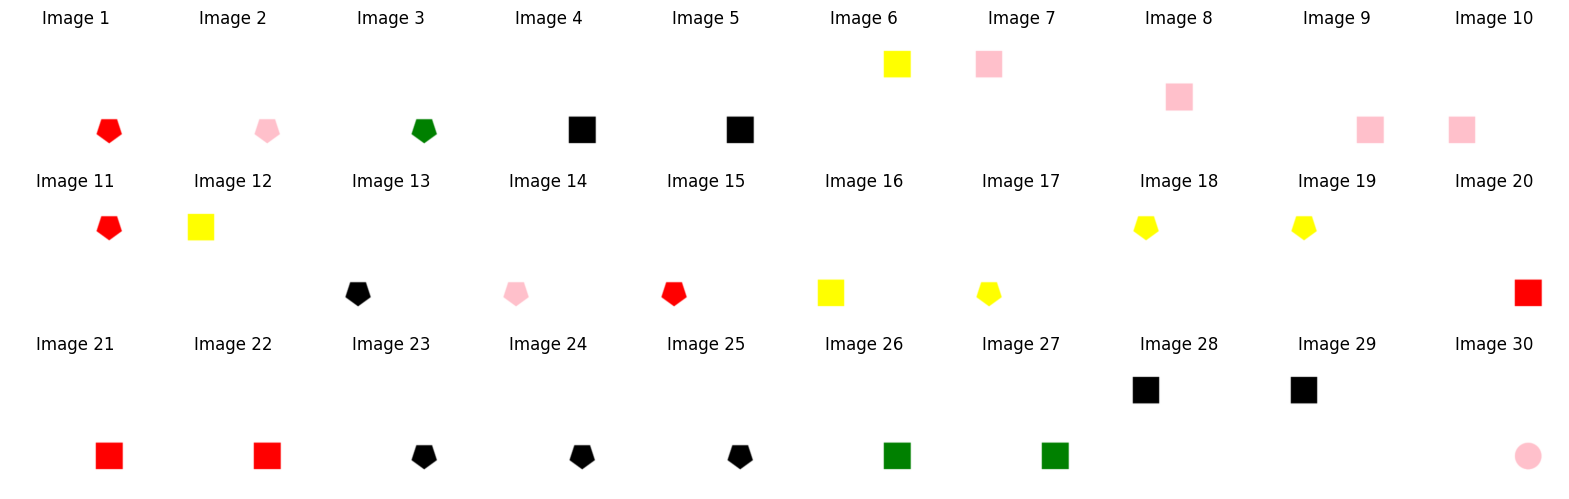

mean_16_376
[('circle', np.float64(0.5666666666666667)), ('square', np.float64(0.5)), ('pink', np.float64(0.3666666666666666)), ('BR', np.float64(0.3333333333333333)), ('BL', np.float64(0.3))]
Neuron: mean_16_376


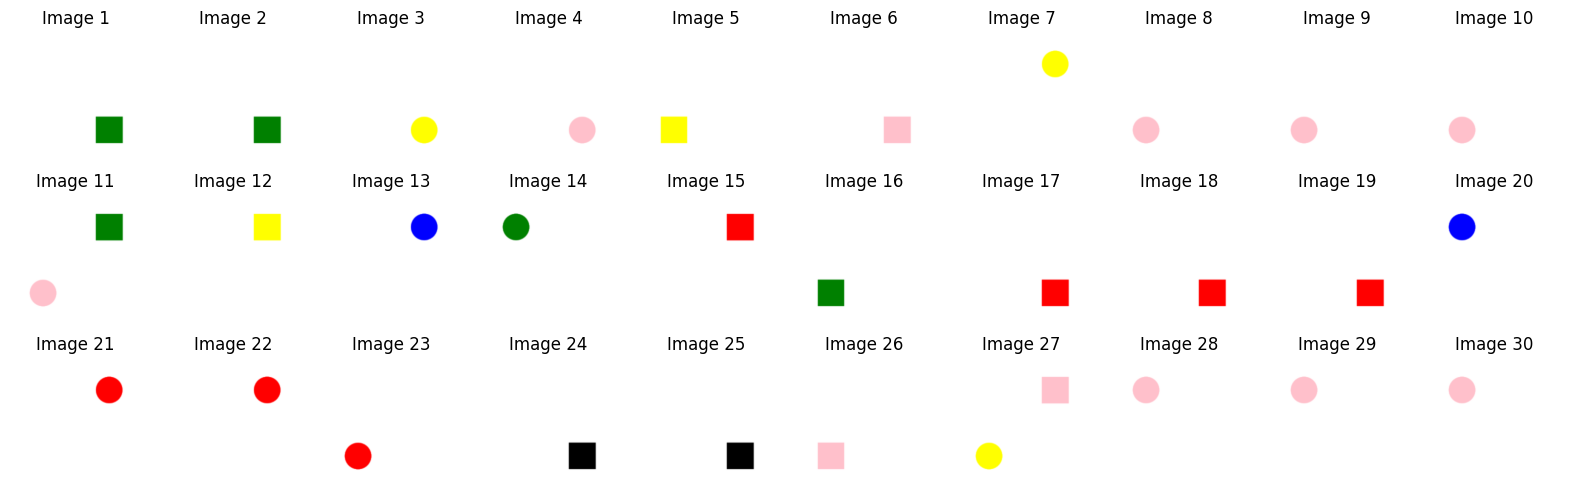

mean_14_983
[('BR', np.float64(0.8)), ('pentagon', np.float64(0.5)), ('square', np.float64(0.4)), ('black', np.float64(0.4)), ('BL', np.float64(0.4))]
Neuron: mean_14_983


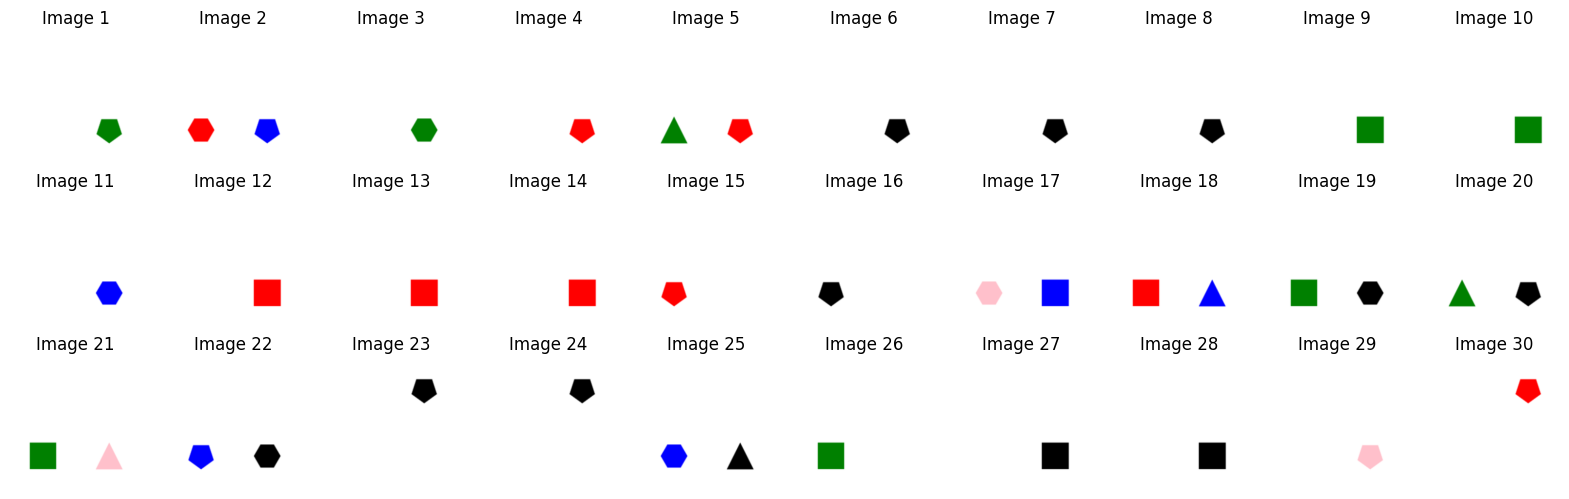

mean_22_821
[('M', np.float64(0.7666666666666667)), ('circle', np.float64(0.4666666666666667)), ('pink', np.float64(0.3666666666666666)), ('green', np.float64(0.2333333333333333)), ('blue', np.float64(0.2333333333333333))]
Neuron: mean_22_821


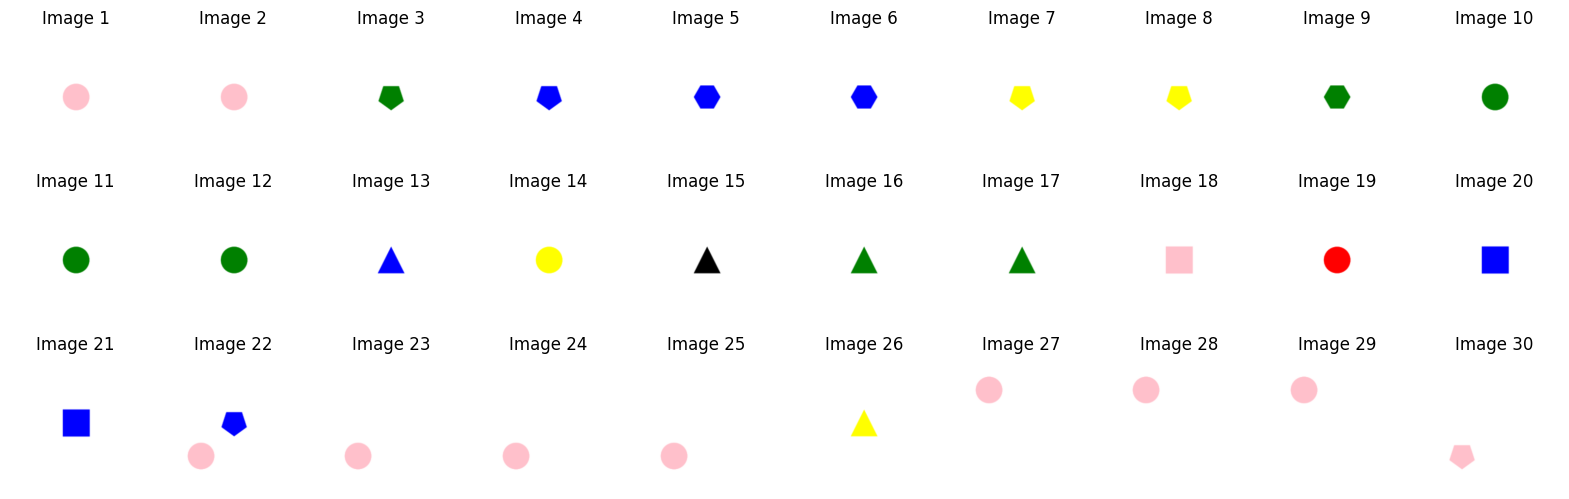

mean_22_281
[('M', np.float64(0.7666666666666667)), ('circle', np.float64(0.4666666666666667)), ('pink', np.float64(0.3666666666666666)), ('green', np.float64(0.2333333333333333)), ('blue', np.float64(0.2333333333333333))]
Neuron: mean_22_281


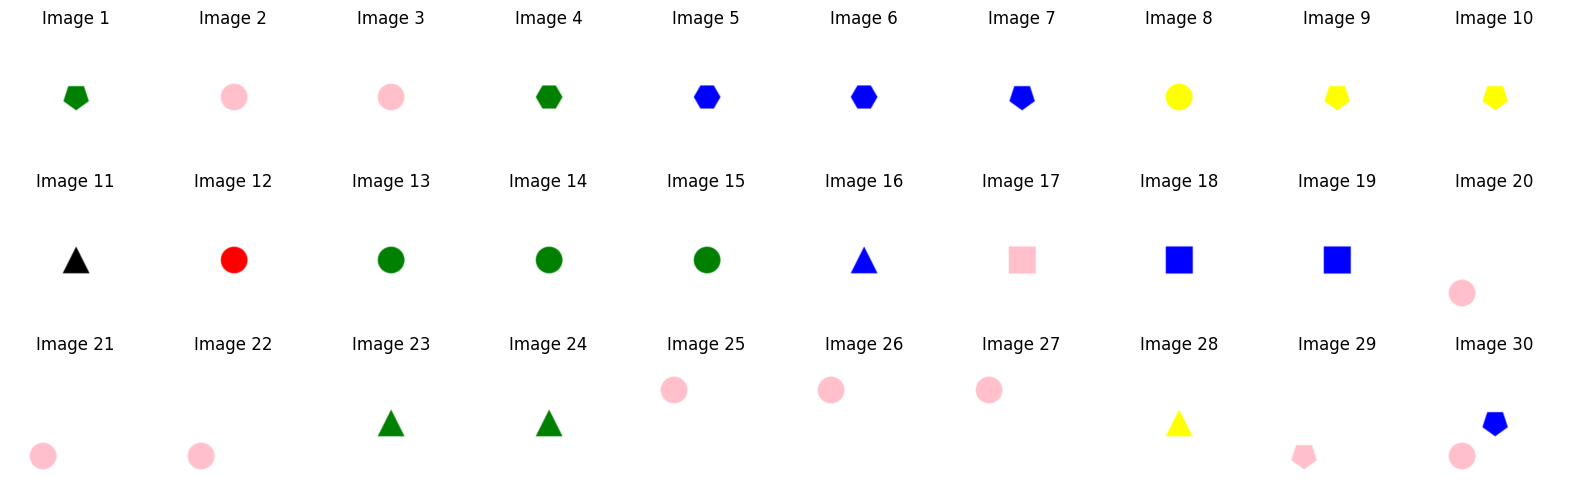

mean_18_537
[('pink', np.float64(0.5333333333333333)), ('circle', np.float64(0.4)), ('BL', np.float64(0.3666666666666666)), ('BR', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.3))]
Neuron: mean_18_537


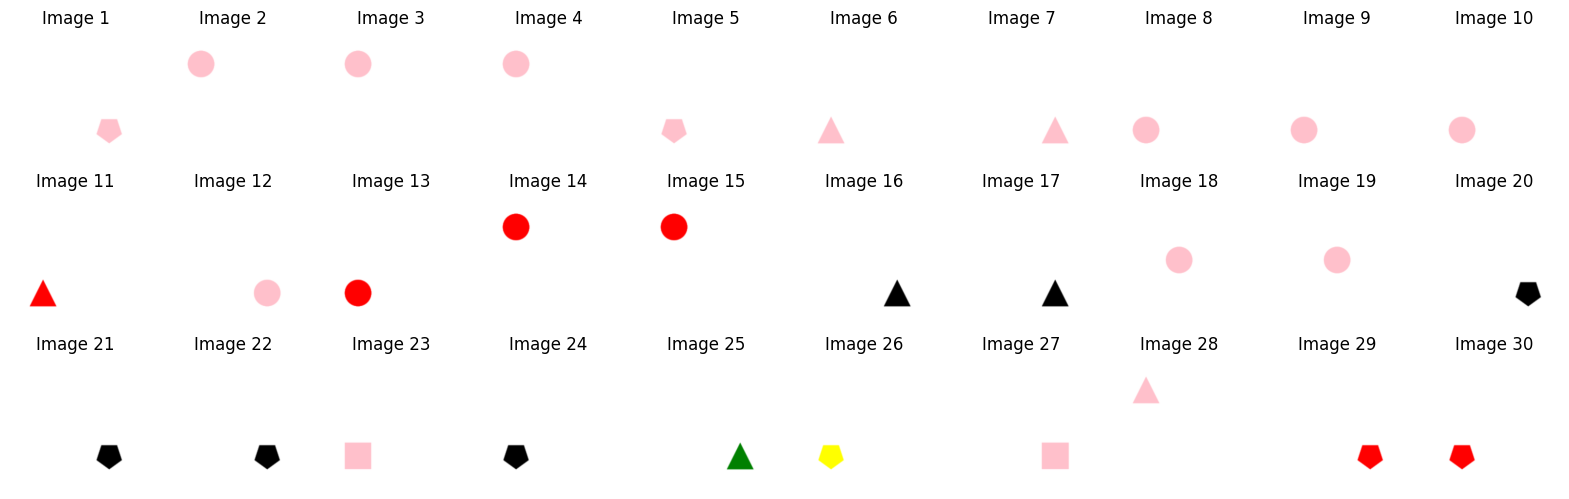

mean_16_947
[('circle', np.float64(0.6333333333333333)), ('pink', np.float64(0.5333333333333333)), ('square', np.float64(0.4666666666666667)), ('red', np.float64(0.3666666666666666)), ('TL', np.float64(0.3))]
Neuron: mean_16_947


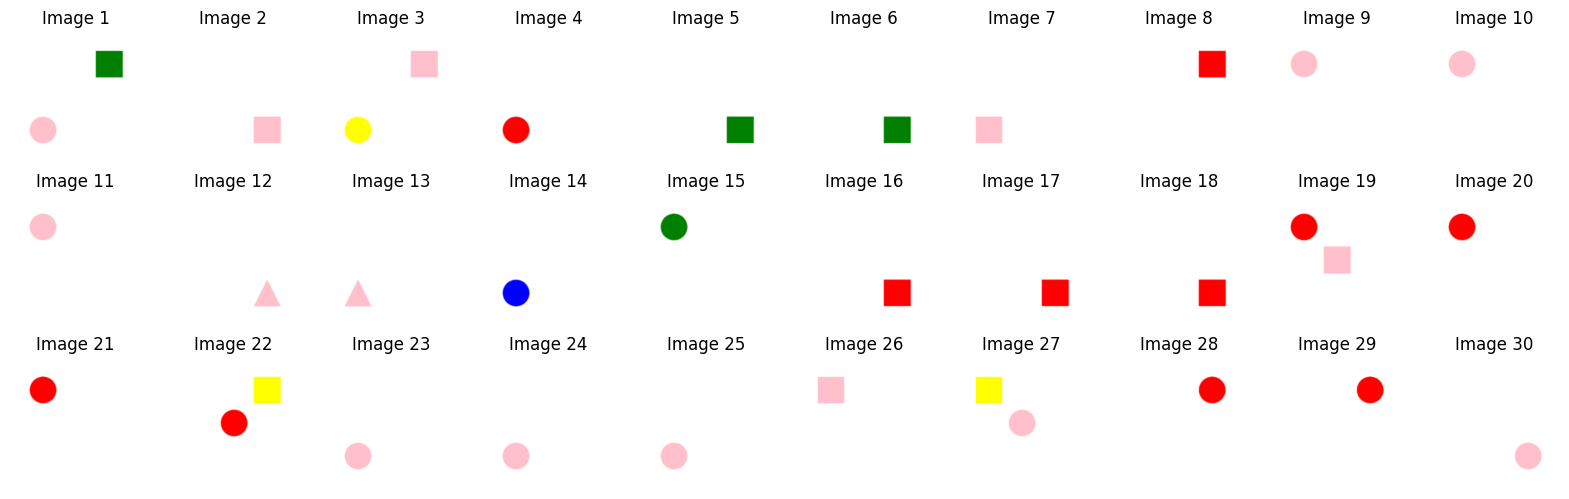

mean_15_73
[('square', np.float64(0.7333333333333333)), ('pink', np.float64(0.5333333333333333)), ('circle', np.float64(0.4666666666666667)), ('TL', np.float64(0.3)), ('BL', np.float64(0.2666666666666666))]
Neuron: mean_15_73


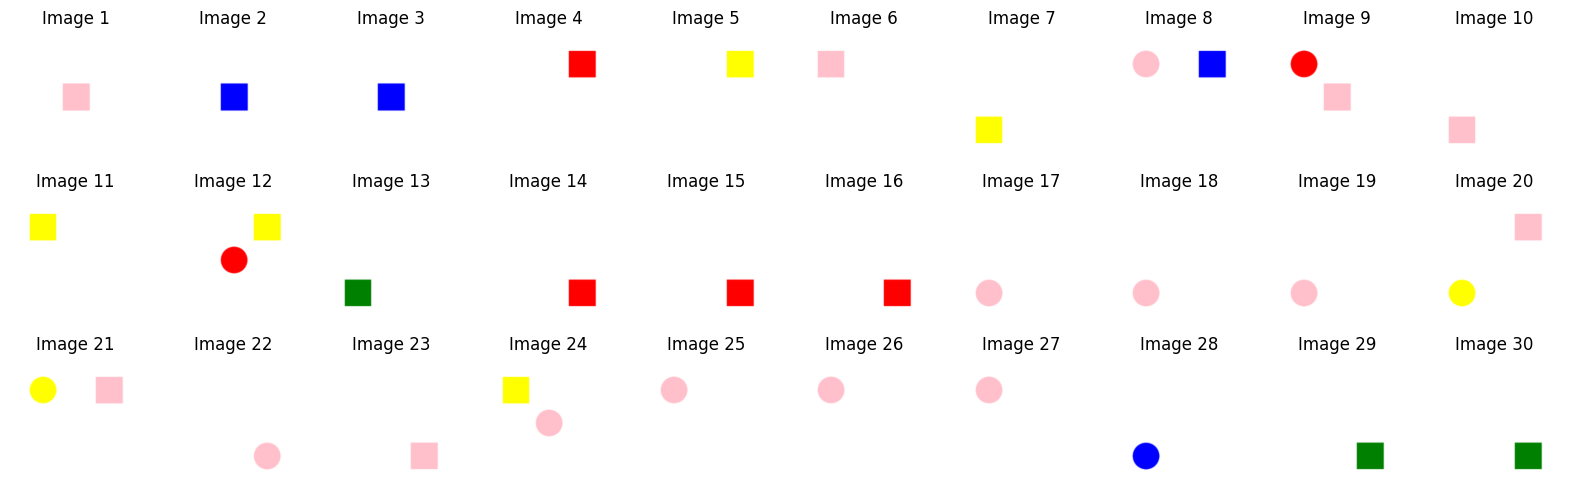

mean_16_563
[('circle', np.float64(0.5666666666666667)), ('pink', np.float64(0.5666666666666667)), ('square', np.float64(0.5333333333333333)), ('TL', np.float64(0.4)), ('red', np.float64(0.3))]
Neuron: mean_16_563


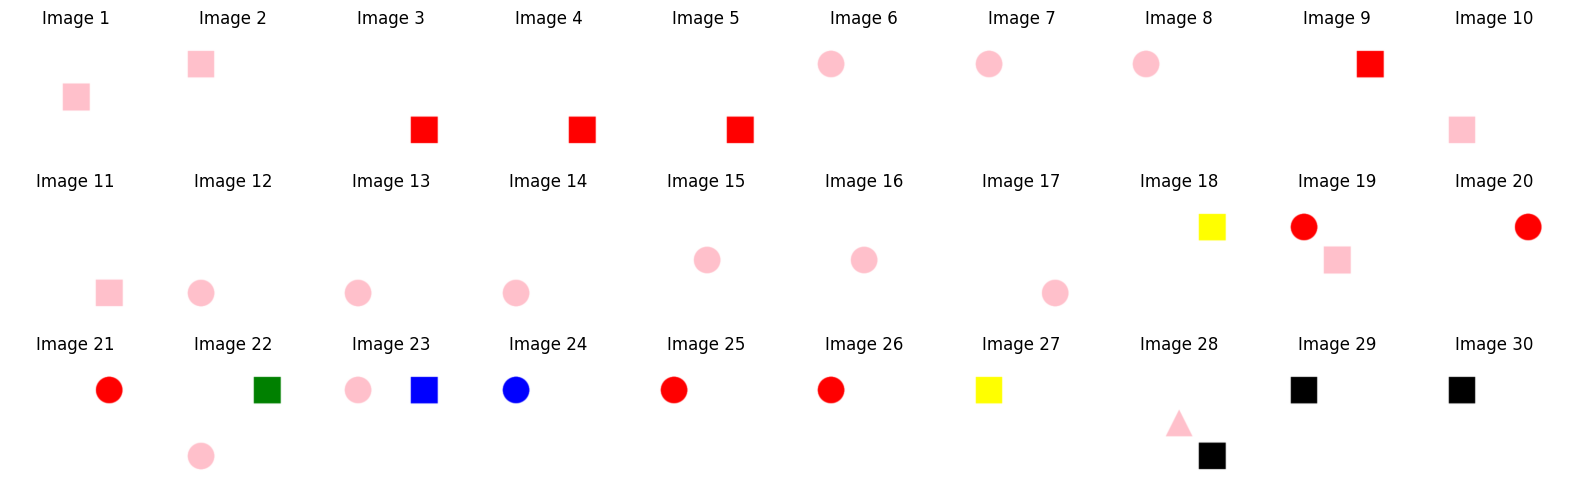

mean_15_779
[('M', np.float64(0.8)), ('blue', np.float64(0.3)), ('circle', np.float64(0.2666666666666666)), ('triangle', np.float64(0.2666666666666666)), ('pentagon', np.float64(0.2666666666666666))]
Neuron: mean_15_779


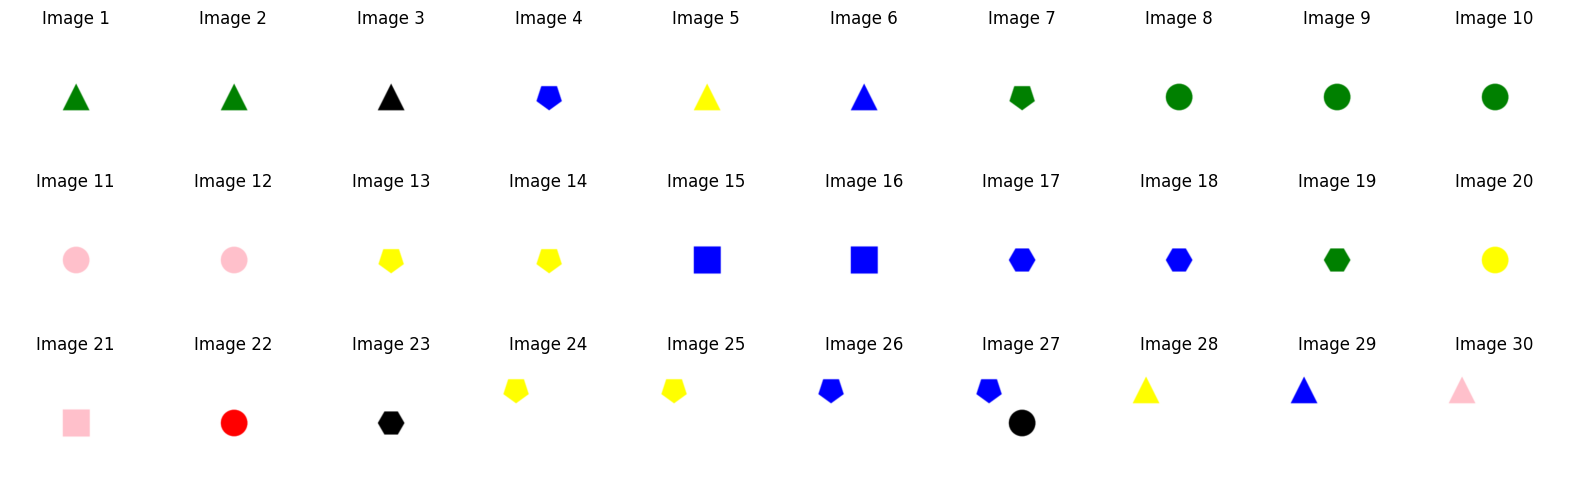

mean_18_7
[('circle', np.float64(0.6333333333333333)), ('pink', np.float64(0.5333333333333333)), ('M', np.float64(0.3)), ('TL', np.float64(0.3)), ('pentagon', np.float64(0.2))]
Neuron: mean_18_7


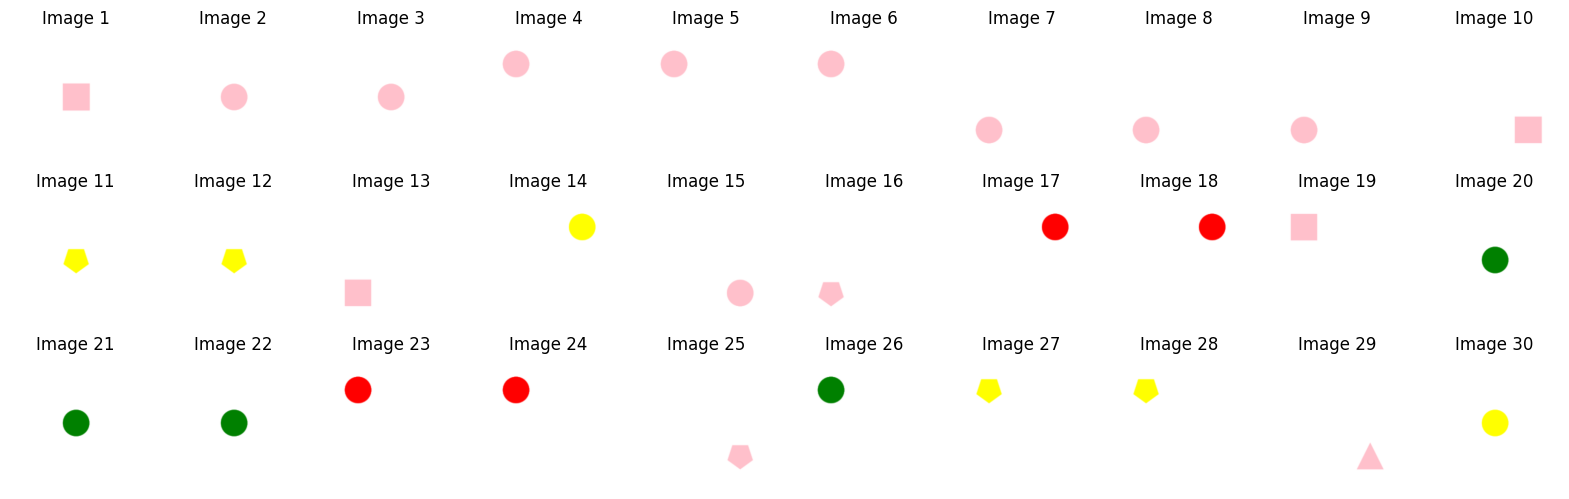

mean_15_816
[('BR', np.float64(0.7)), ('black', np.float64(0.4)), ('square', np.float64(0.3333333333333333)), ('BL', np.float64(0.3)), ('pentagon', np.float64(0.2666666666666666))]
Neuron: mean_15_816


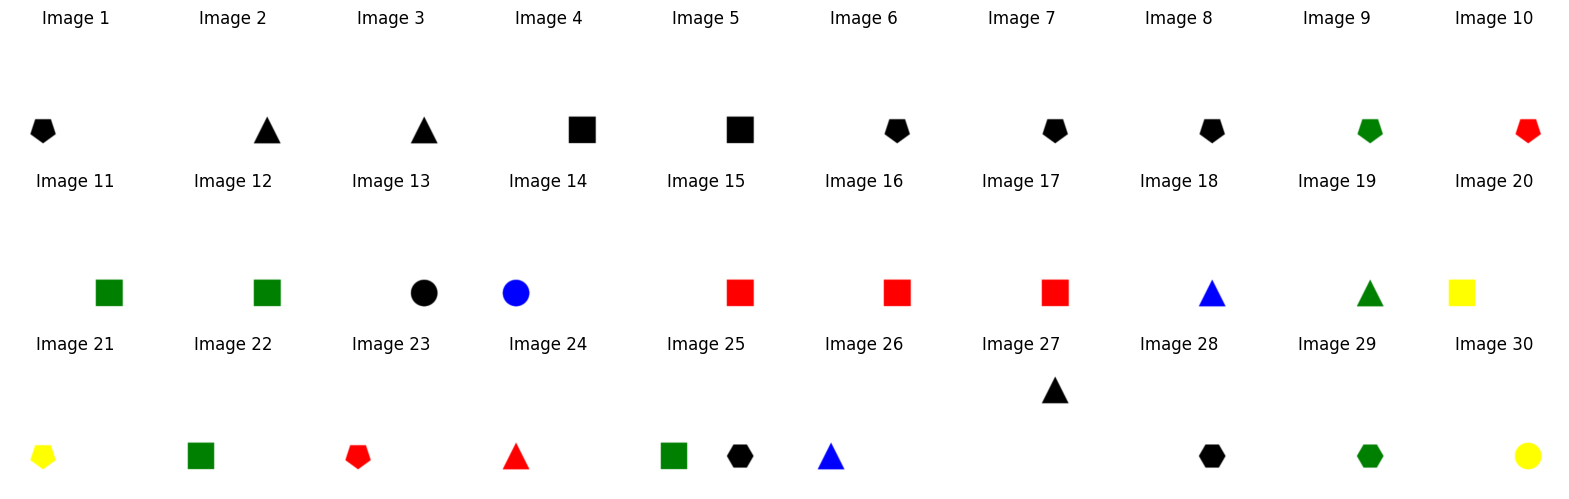

mean_16_165
[('circle', np.float64(0.9)), ('pink', np.float64(0.5666666666666667)), ('red', np.float64(0.4333333333333333)), ('square', np.float64(0.3666666666666666)), ('yellow', np.float64(0.3333333333333333))]
Neuron: mean_16_165


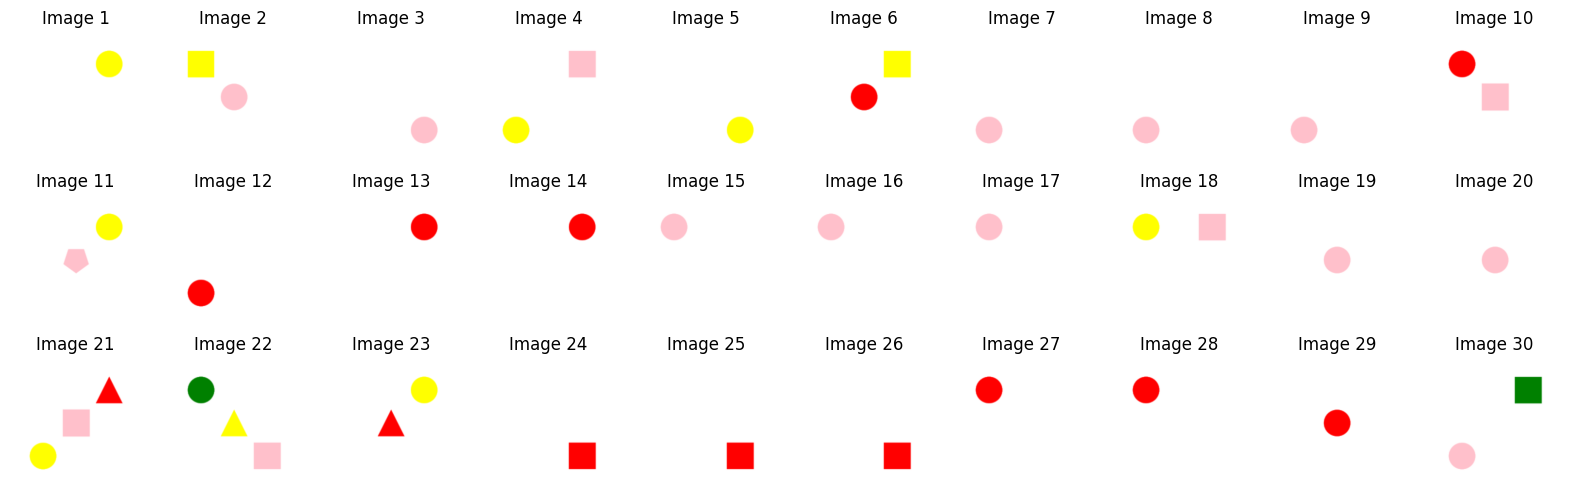

mean_22_376
[('circle', np.float64(0.6)), ('M', np.float64(0.5666666666666667)), ('pink', np.float64(0.4666666666666667)), ('pentagon', np.float64(0.3666666666666666)), ('yellow', np.float64(0.3))]
Neuron: mean_22_376


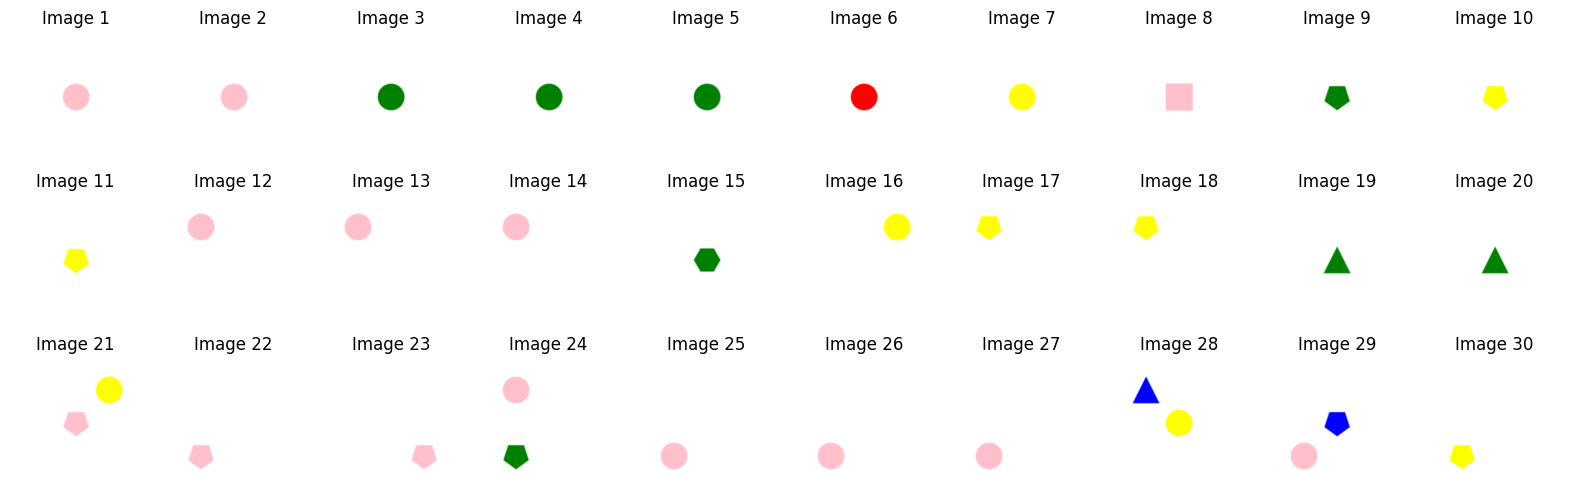

mean_20_69
[('pink', np.float64(0.5333333333333333)), ('circle', np.float64(0.5)), ('yellow', np.float64(0.5)), ('M', np.float64(0.3666666666666666)), ('TL', np.float64(0.3))]
Neuron: mean_20_69


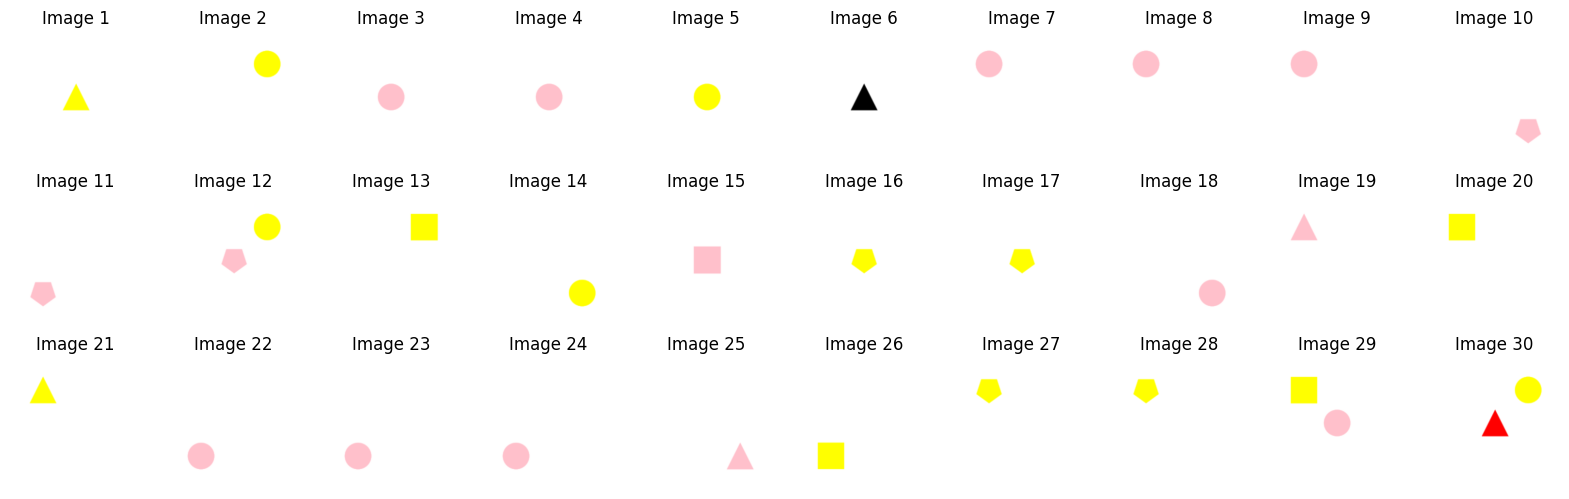

mean_20_779
[('circle', np.float64(0.4)), ('square', np.float64(0.4)), ('pink', np.float64(0.4)), ('BR', np.float64(0.3333333333333333)), ('TL', np.float64(0.3))]
Neuron: mean_20_779


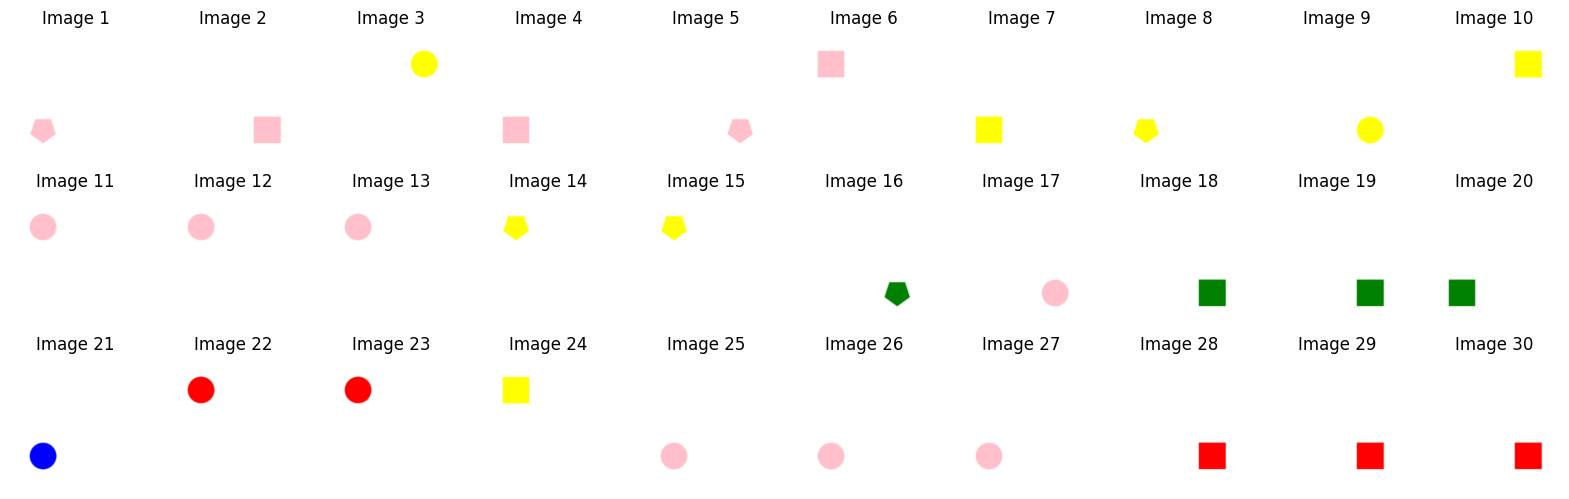

mean_18_113
[('circle', np.float64(0.6)), ('TL', np.float64(0.4666666666666667)), ('pink', np.float64(0.4333333333333333)), ('red', np.float64(0.3333333333333333)), ('TR', np.float64(0.3333333333333333))]
Neuron: mean_18_113


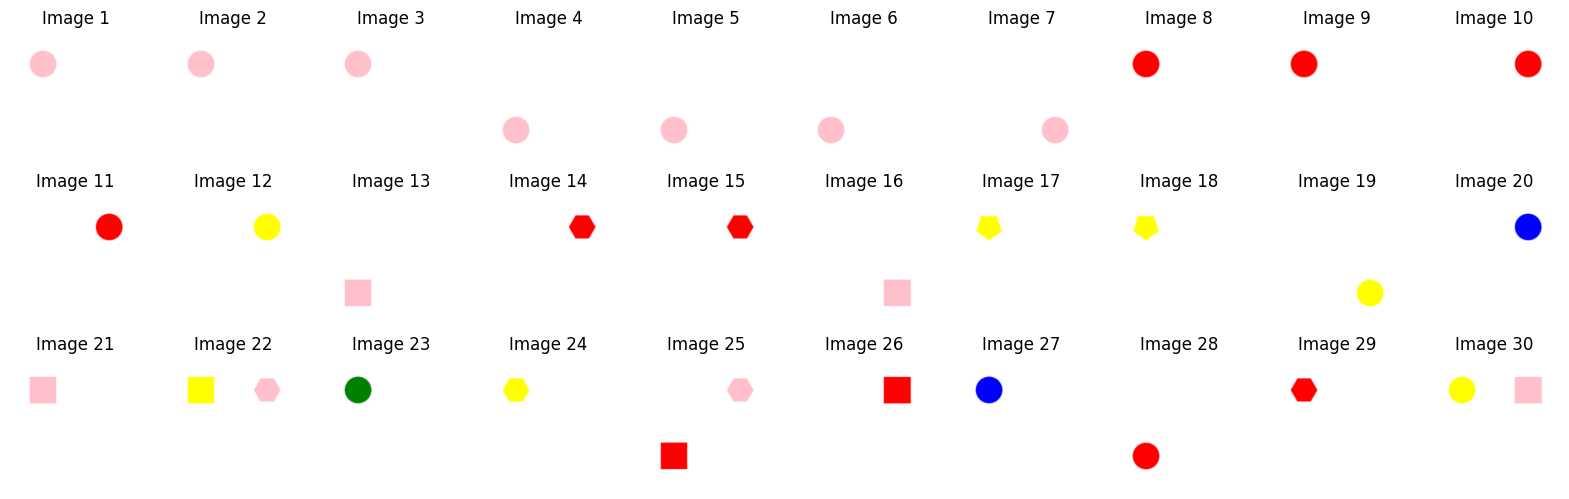

mean_15_485
[('BR', np.float64(0.8666666666666667)), ('square', np.float64(0.4666666666666667)), ('triangle', np.float64(0.4)), ('BL', np.float64(0.4)), ('black', np.float64(0.3))]
Neuron: mean_15_485


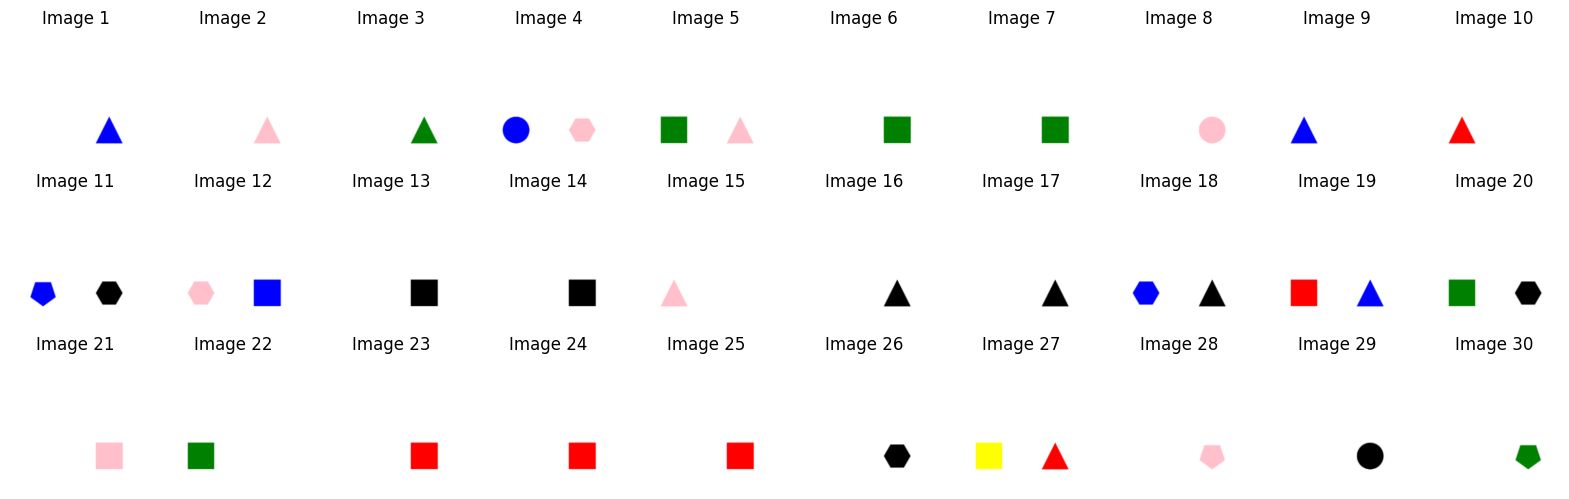

mean_17_226
[('BR', np.float64(0.5666666666666667)), ('black', np.float64(0.4666666666666667)), ('pentagon', np.float64(0.4)), ('BL', np.float64(0.3666666666666666)), ('square', np.float64(0.2666666666666666))]
Neuron: mean_17_226


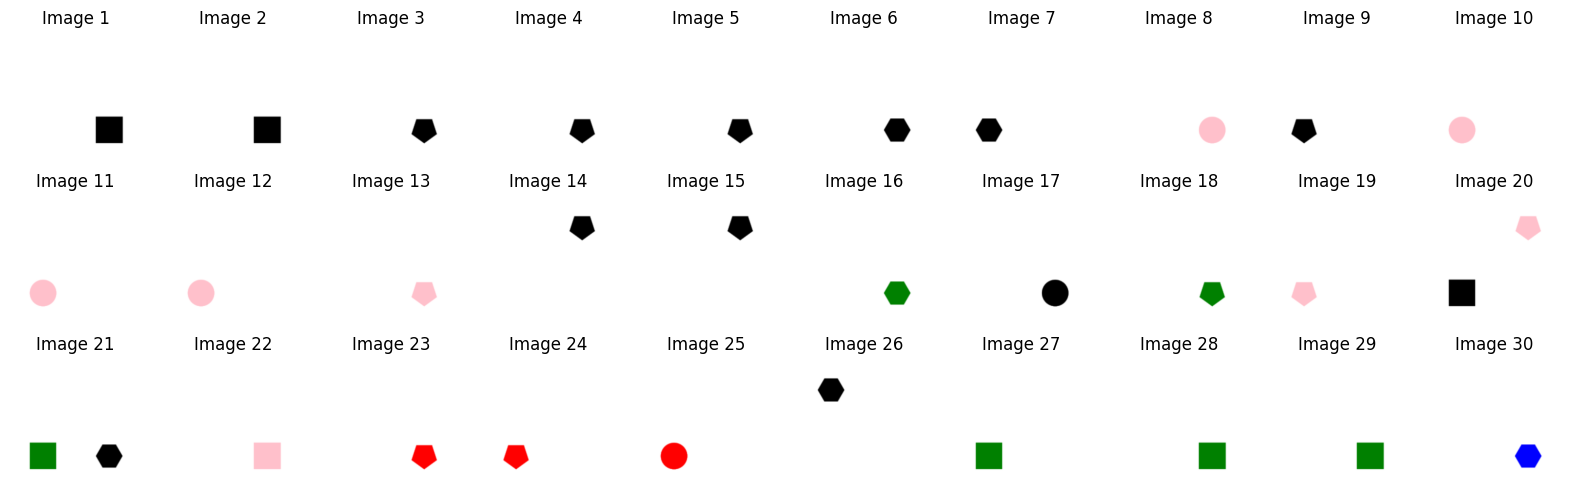

mean_14_966
[('BR', np.float64(0.4666666666666667)), ('pentagon', np.float64(0.4333333333333333)), ('circle', np.float64(0.3666666666666666)), ('pink', np.float64(0.3333333333333333)), ('red', np.float64(0.3))]
Neuron: mean_14_966


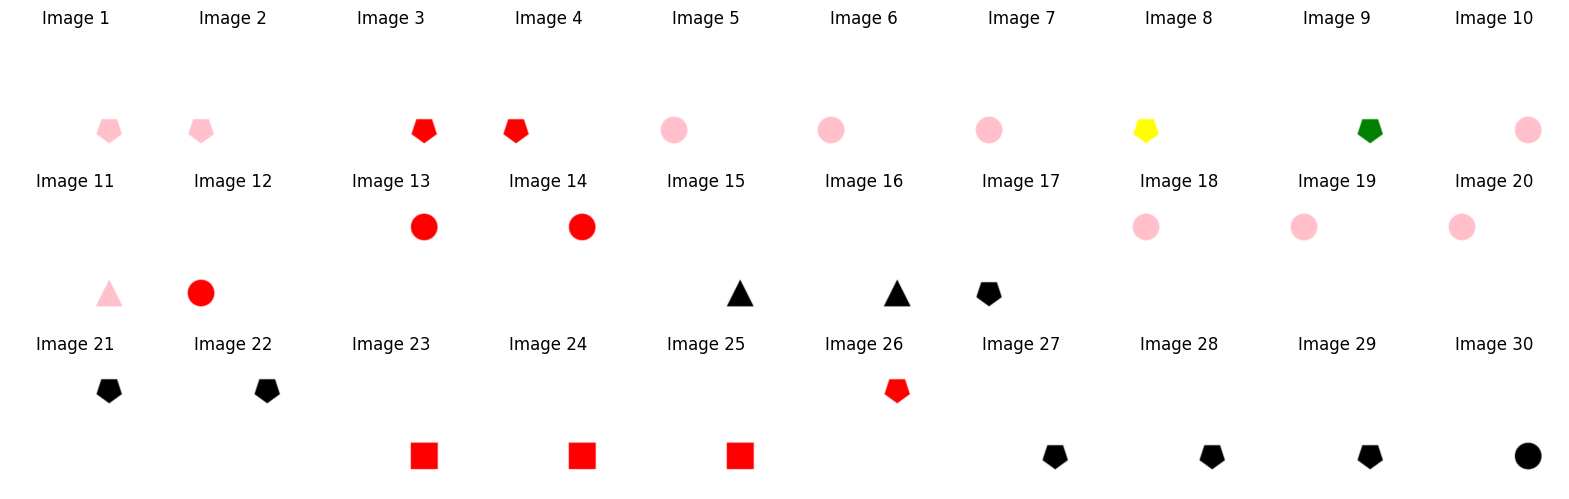

mean_20_862
[('M', np.float64(0.8)), ('circle', np.float64(0.4)), ('pink', np.float64(0.3333333333333333)), ('pentagon', np.float64(0.2333333333333333)), ('green', np.float64(0.2333333333333333))]
Neuron: mean_20_862


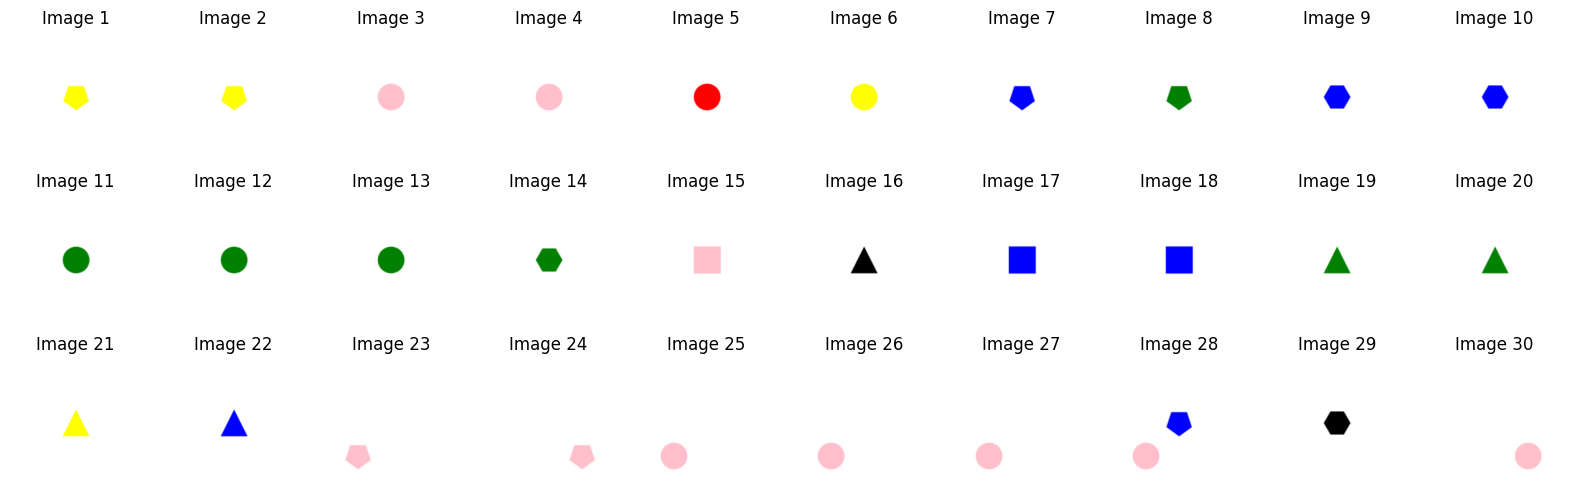

mean_17_366
[('circle', np.float64(0.4666666666666667)), ('red', np.float64(0.4333333333333333)), ('square', np.float64(0.3666666666666666)), ('pink', np.float64(0.3)), ('TL', np.float64(0.3))]
Neuron: mean_17_366


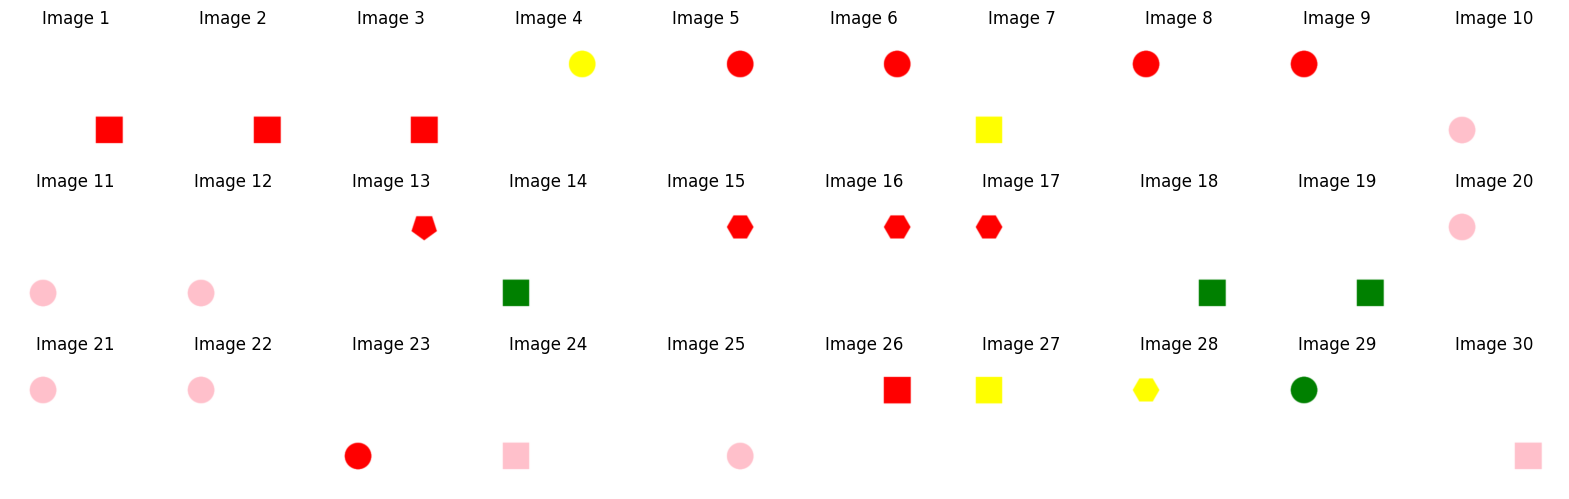

mean_22_143
[('M', np.float64(0.7)), ('circle', np.float64(0.5333333333333333)), ('yellow', np.float64(0.3)), ('pink', np.float64(0.3)), ('pentagon', np.float64(0.2333333333333333))]
Neuron: mean_22_143


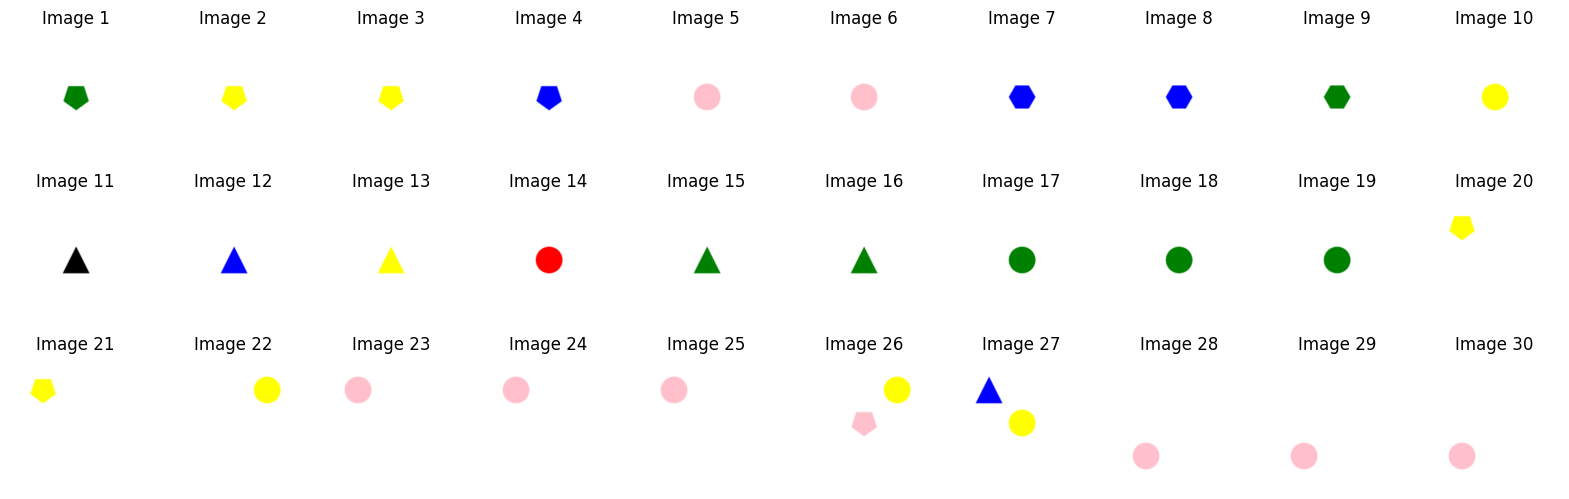

mean_23_211
[('M', np.float64(0.6666666666666666)), ('circle', np.float64(0.4666666666666667)), ('pink', np.float64(0.3666666666666666)), ('green', np.float64(0.2666666666666666)), ('pentagon', np.float64(0.2333333333333333))]
Neuron: mean_23_211


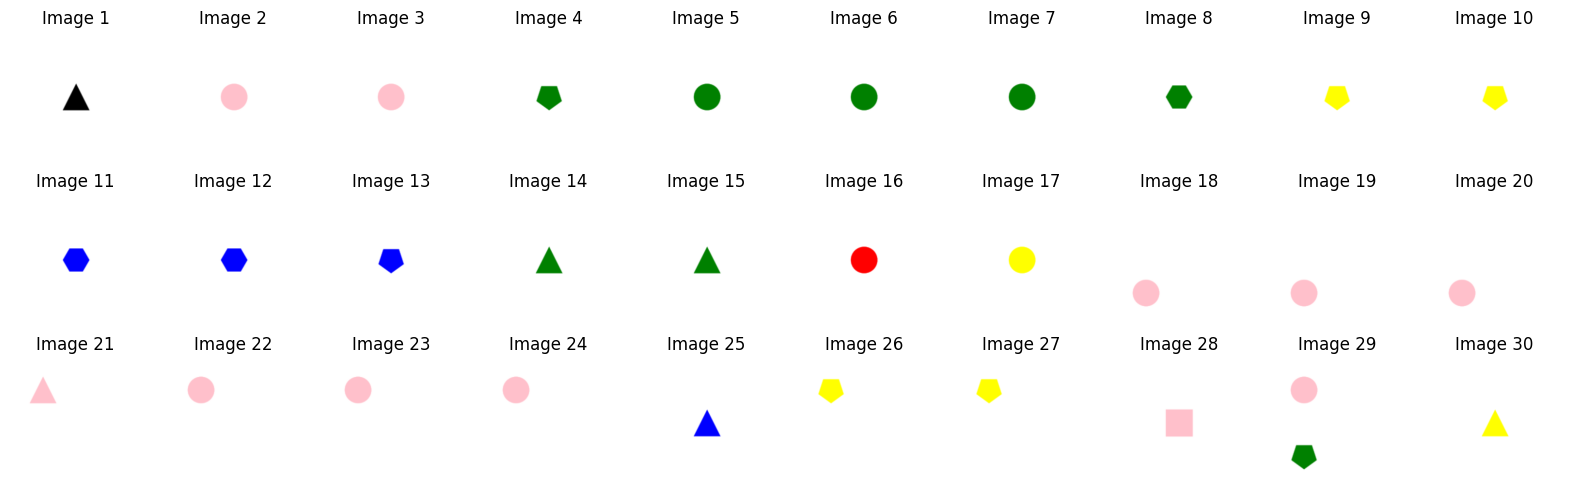

mean_14_402
[('circle', np.float64(0.6)), ('square', np.float64(0.4666666666666667)), ('TL', np.float64(0.4333333333333333)), ('pink', np.float64(0.4)), ('M', np.float64(0.3666666666666666))]
Neuron: mean_14_402


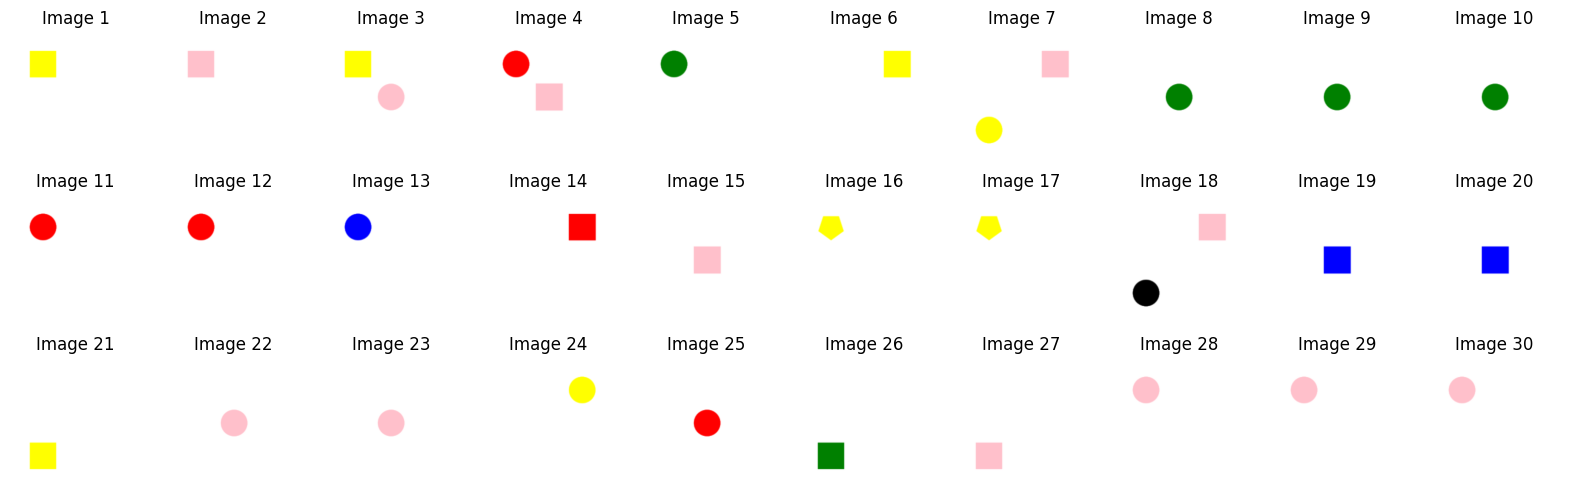

mean_21_581
[('M', np.float64(0.7)), ('circle', np.float64(0.4666666666666667)), ('pink', np.float64(0.4)), ('pentagon', np.float64(0.3)), ('green', np.float64(0.3))]
Neuron: mean_21_581


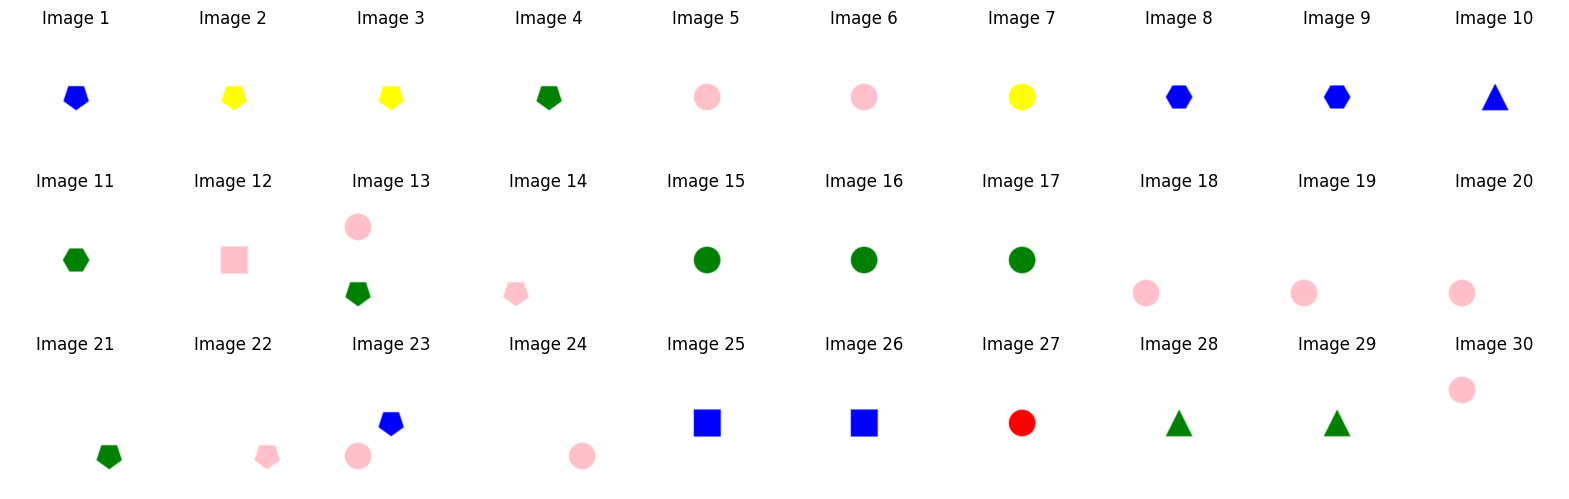

mean_19_982
[('M', np.float64(0.8666666666666667)), ('blue', np.float64(0.3333333333333333)), ('yellow', np.float64(0.3)), ('circle', np.float64(0.2666666666666666)), ('triangle', np.float64(0.2666666666666666))]
Neuron: mean_19_982


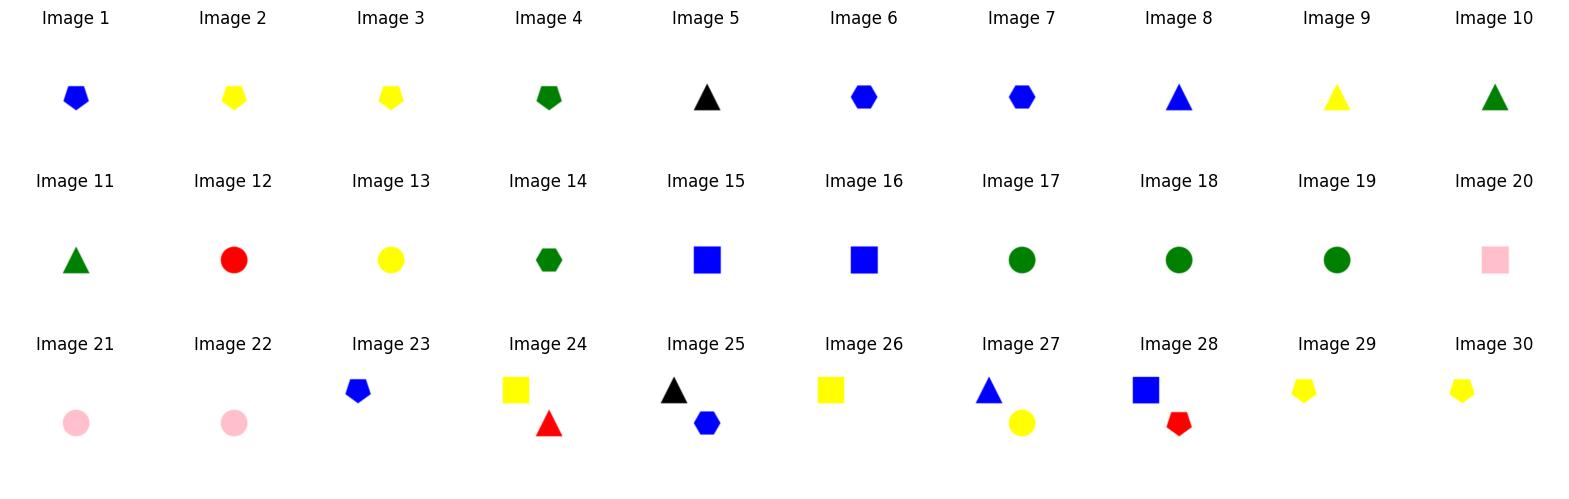

mean_15_14
[('BR', np.float64(0.6666666666666666)), ('black', np.float64(0.4333333333333333)), ('pentagon', np.float64(0.4)), ('square', np.float64(0.3)), ('triangle', np.float64(0.2333333333333333))]
Neuron: mean_15_14


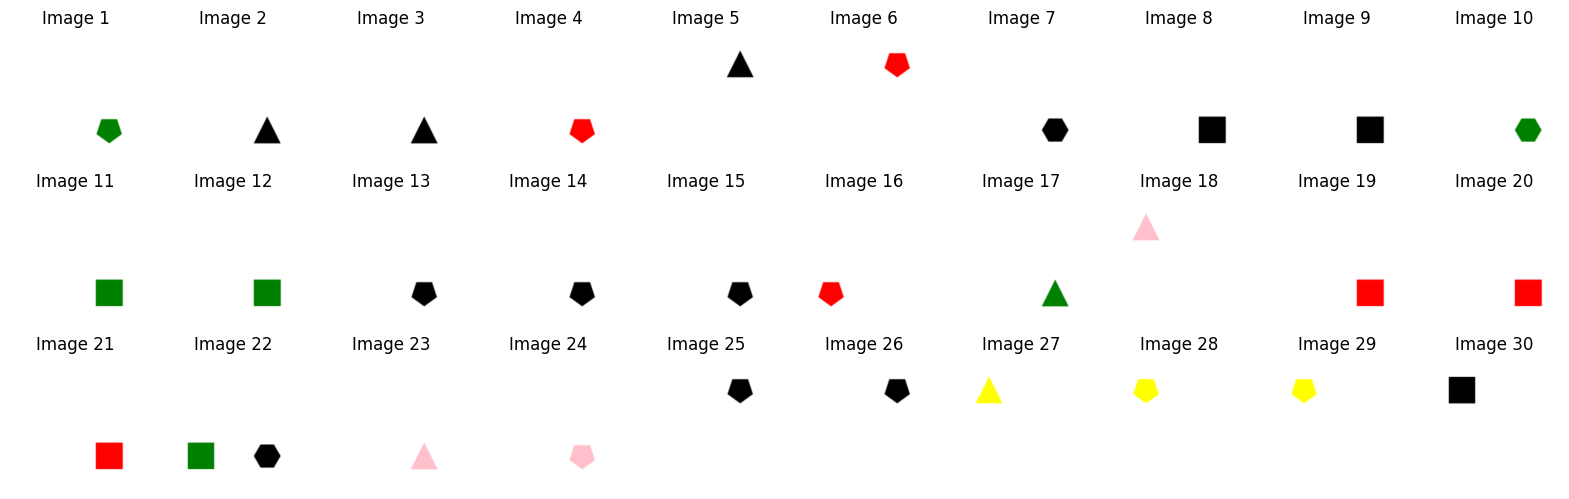

mean_23_511
[('M', np.float64(0.5333333333333333)), ('circle', np.float64(0.5)), ('pink', np.float64(0.4666666666666667)), ('pentagon', np.float64(0.3)), ('triangle', np.float64(0.2333333333333333))]
Neuron: mean_23_511


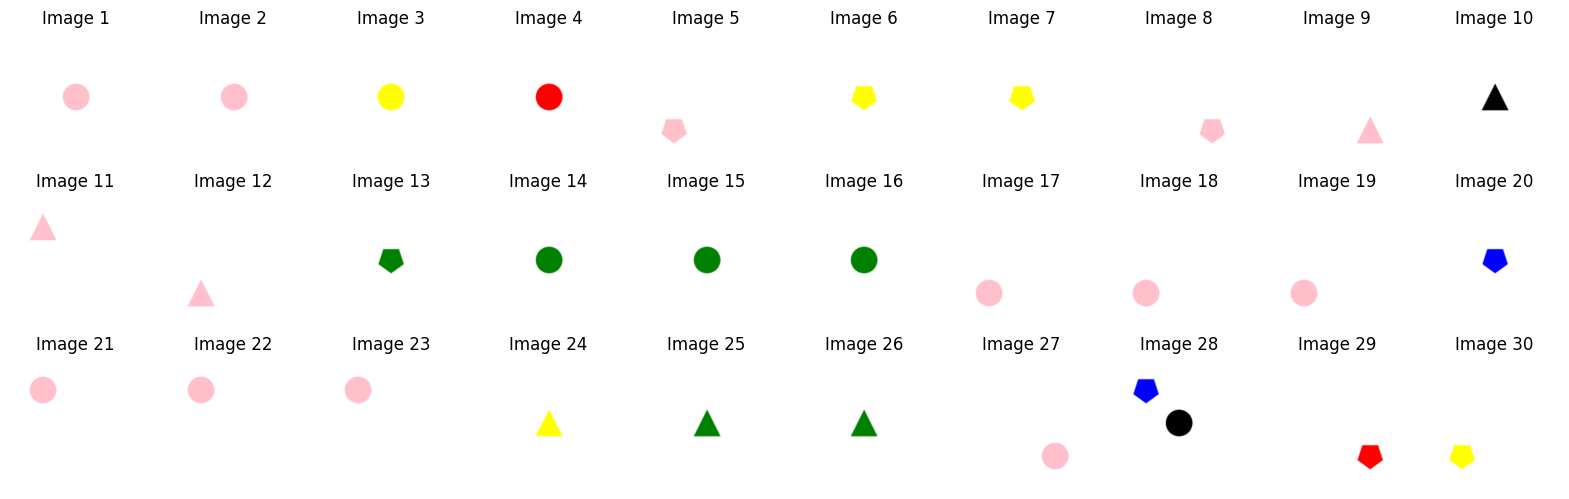

mean_18_466
[('pink', np.float64(0.6333333333333333)), ('black', np.float64(0.4)), ('square', np.float64(0.3666666666666666)), ('BR', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.3))]
Neuron: mean_18_466


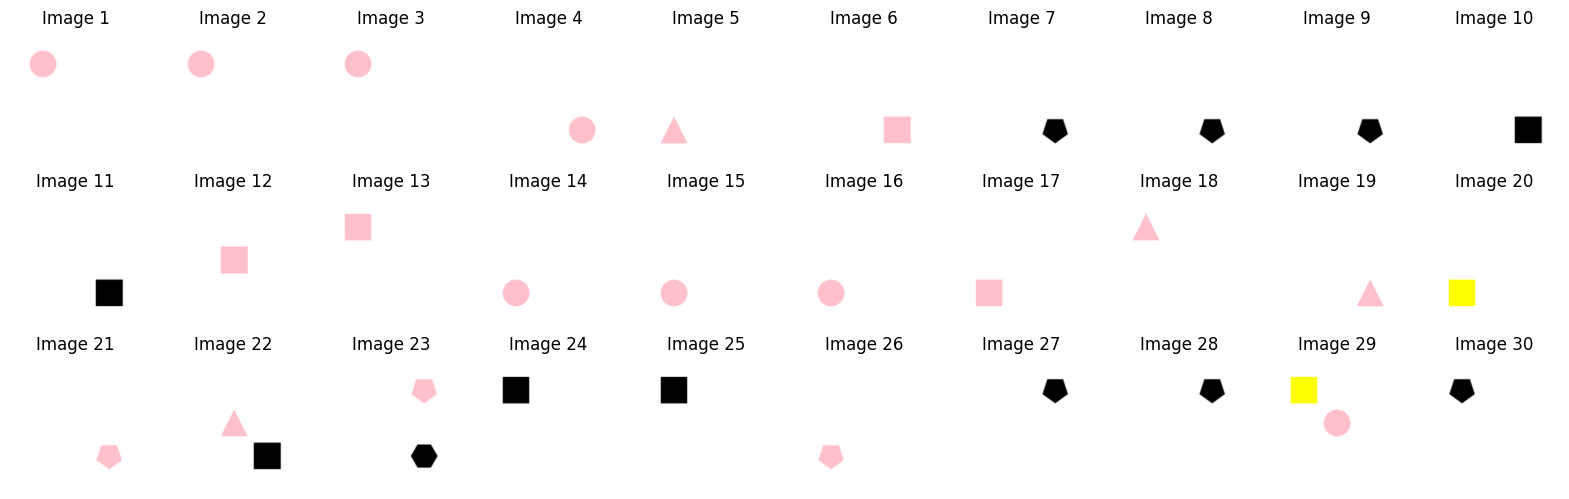

mean_23_755
[('black', np.float64(0.4333333333333333)), ('BR', np.float64(0.4333333333333333)), ('square', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.3333333333333333)), ('pink', np.float64(0.3333333333333333))]
Neuron: mean_23_755


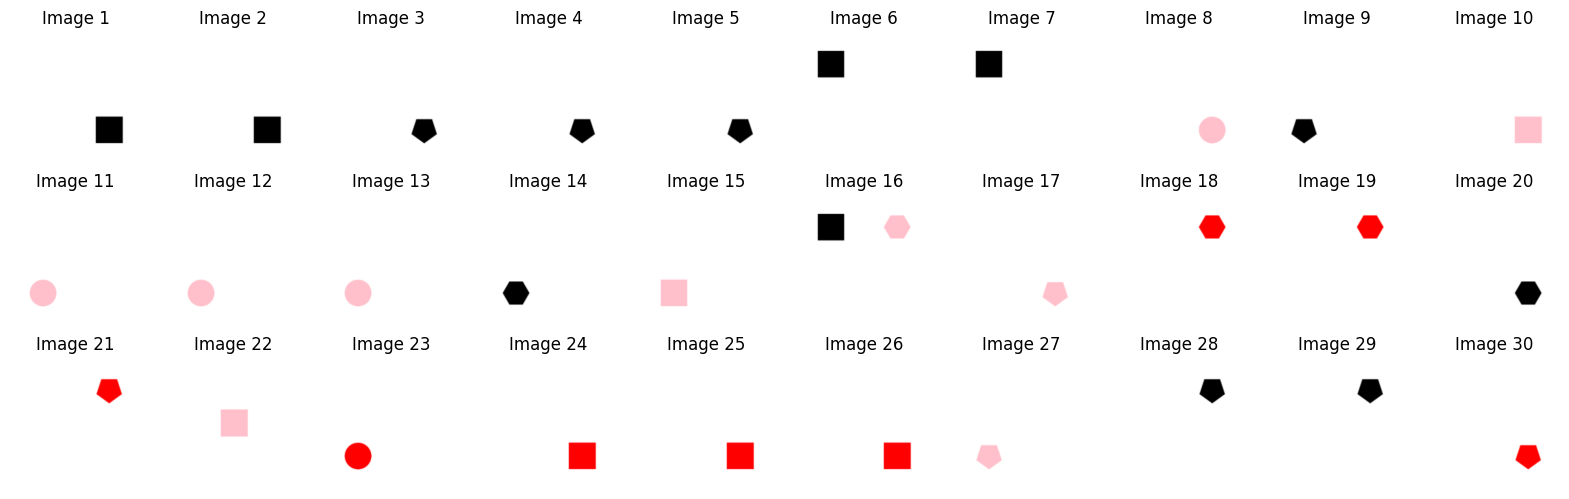

mean_18_308
[('circle', np.float64(0.5666666666666667)), ('TL', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.3333333333333333)), ('red', np.float64(0.3333333333333333)), ('pink', np.float64(0.3))]
Neuron: mean_18_308


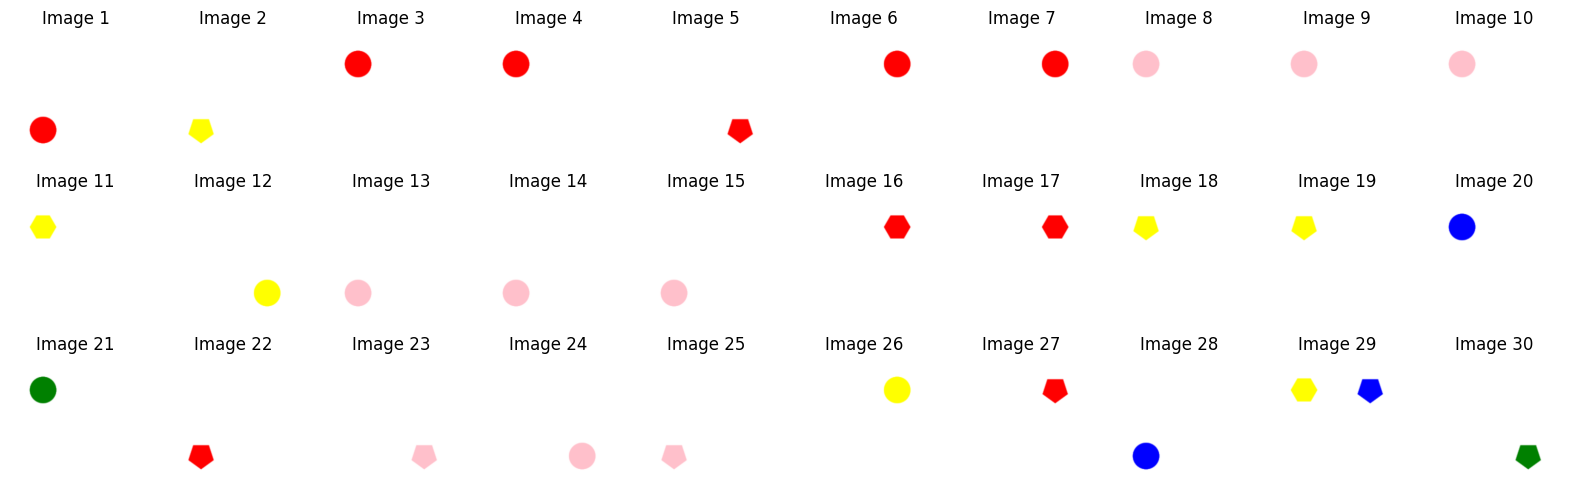

mean_20_782
[('M', np.float64(0.6666666666666666)), ('circle', np.float64(0.5666666666666667)), ('pink', np.float64(0.4666666666666667)), ('pentagon', np.float64(0.2333333333333333)), ('green', np.float64(0.2))]
Neuron: mean_20_782


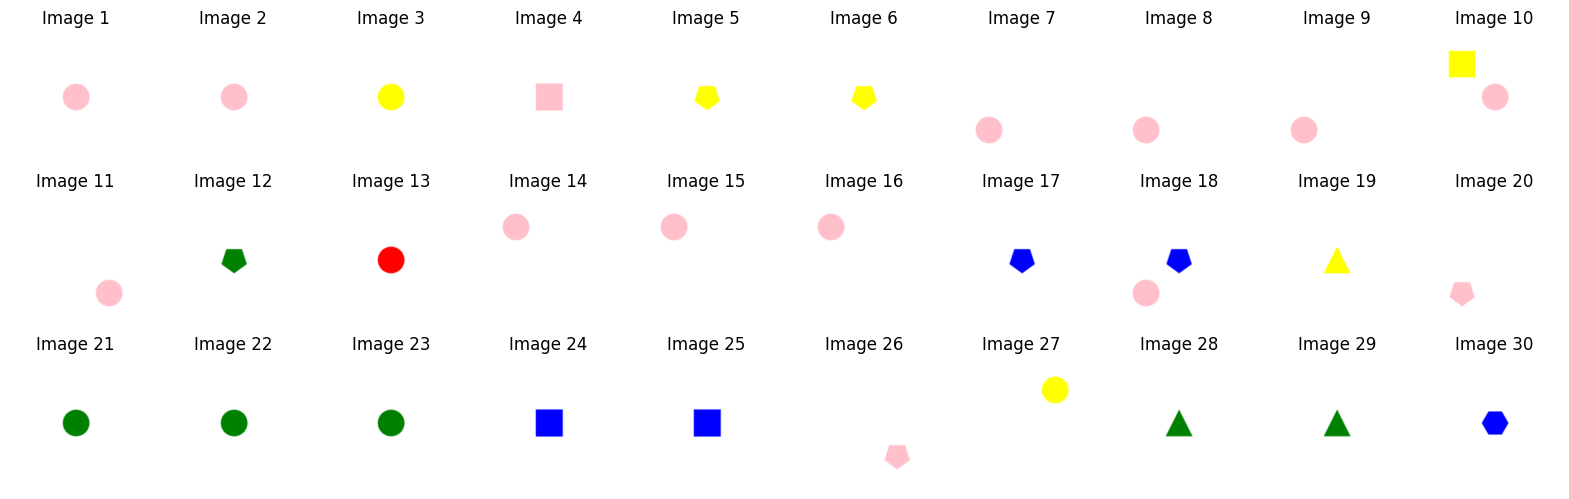

mean_16_692
[('pink', np.float64(0.5666666666666667)), ('TL', np.float64(0.5666666666666667)), ('circle', np.float64(0.5333333333333333)), ('square', np.float64(0.3666666666666666)), ('triangle', np.float64(0.2333333333333333))]
Neuron: mean_16_692


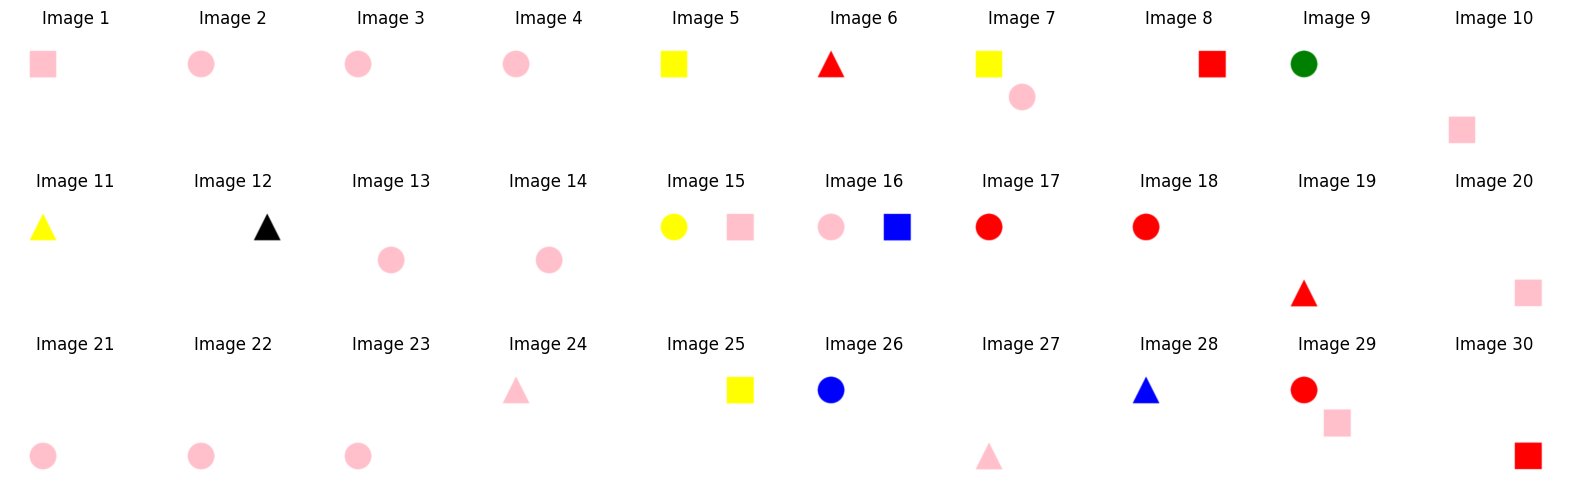

mean_14_612
[('BR', np.float64(0.8333333333333334)), ('square', np.float64(0.4333333333333333)), ('black', np.float64(0.4)), ('BL', np.float64(0.4)), ('pentagon', np.float64(0.3333333333333333))]
Neuron: mean_14_612


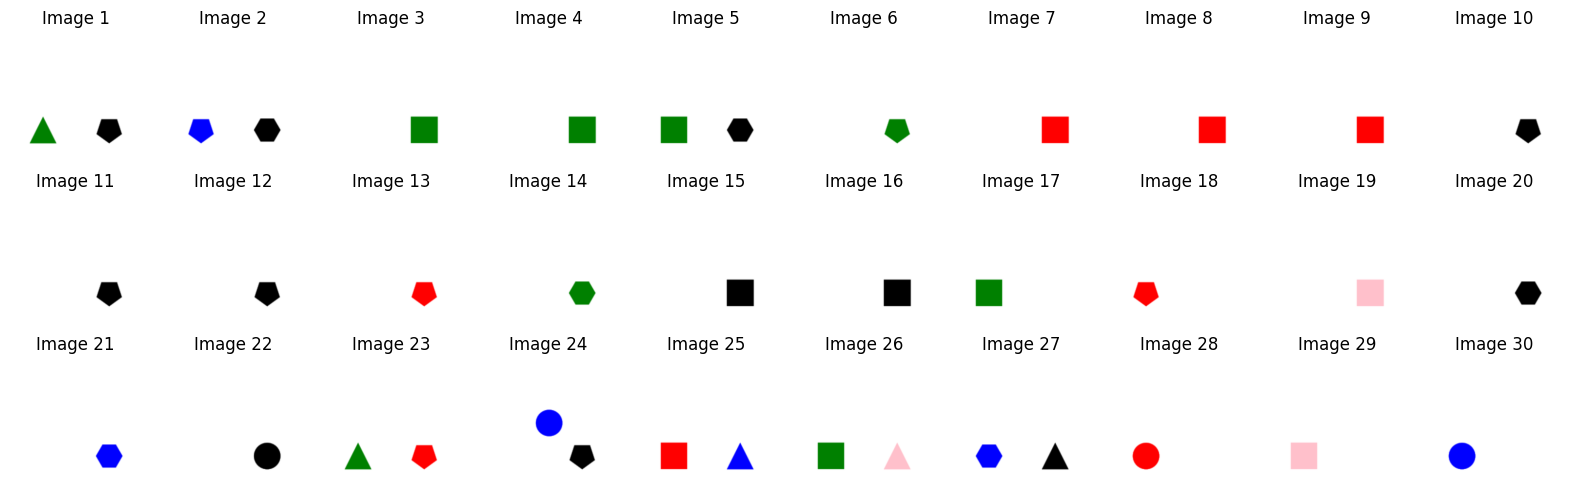

mean_21_738
[('M', np.float64(0.7333333333333333)), ('circle', np.float64(0.4)), ('pink', np.float64(0.3333333333333333)), ('triangle', np.float64(0.2333333333333333)), ('green', np.float64(0.2333333333333333))]
Neuron: mean_21_738


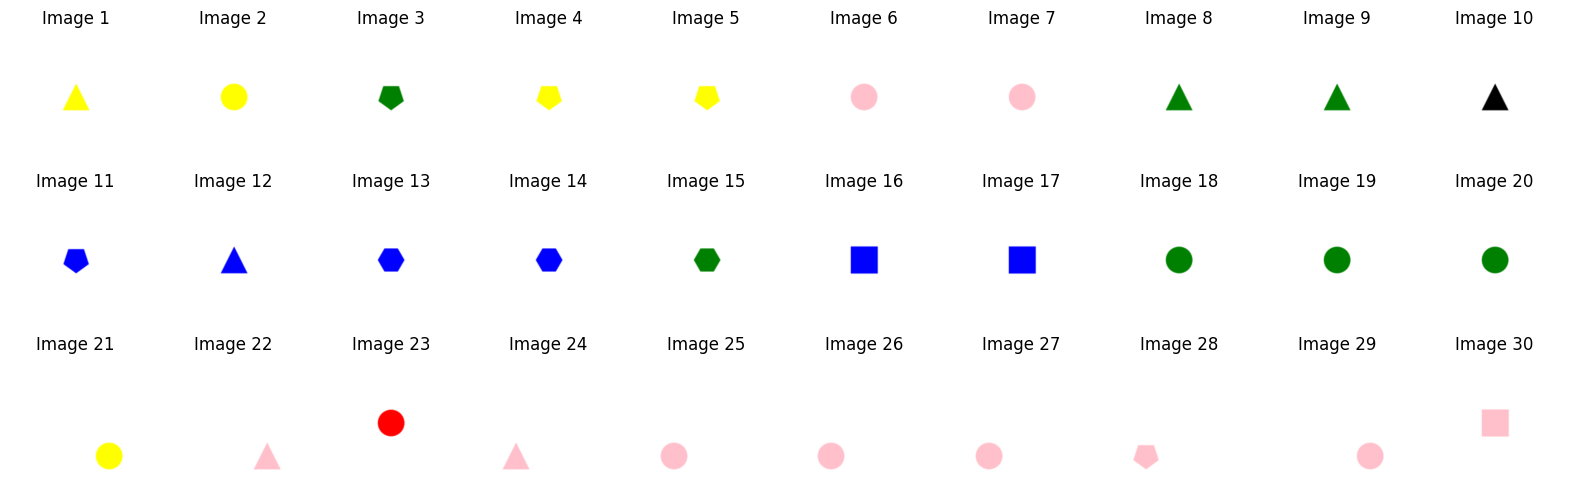

mean_19_498
[('circle', np.float64(0.5666666666666667)), ('square', np.float64(0.5666666666666667)), ('pink', np.float64(0.5666666666666667)), ('TR', np.float64(0.3)), ('BL', np.float64(0.3))]
Neuron: mean_19_498


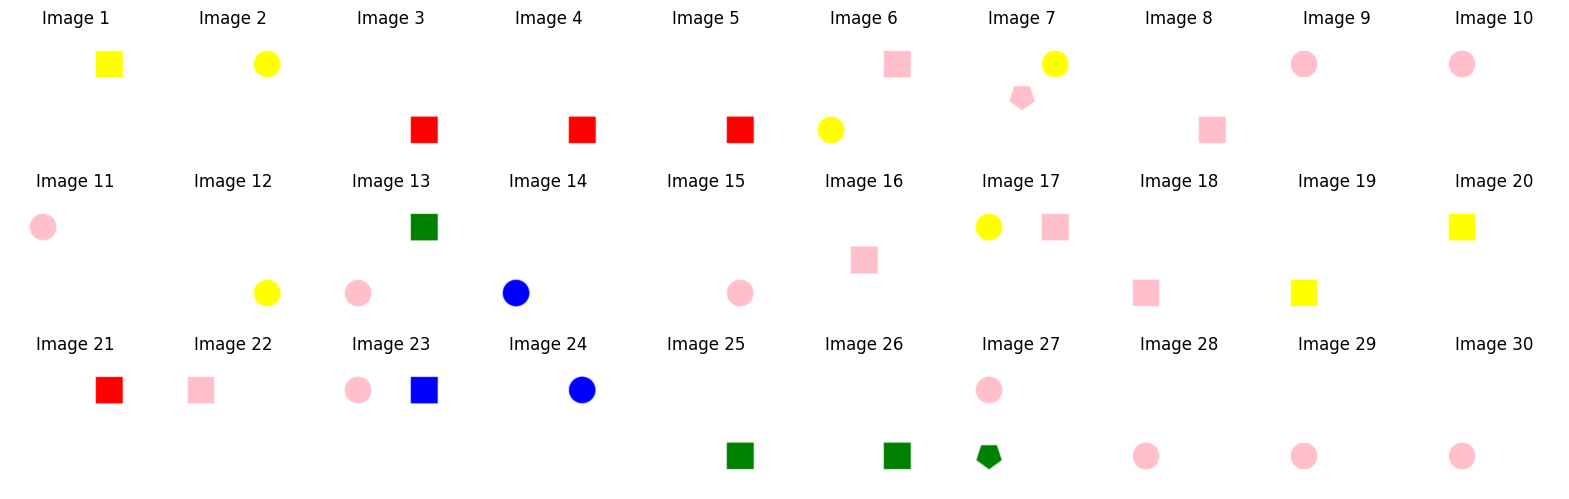

mean_18_261
[('pink', np.float64(0.5333333333333333)), ('black', np.float64(0.3666666666666666)), ('BR', np.float64(0.3666666666666666)), ('TL', np.float64(0.3333333333333333)), ('square', np.float64(0.2666666666666666))]
Neuron: mean_18_261


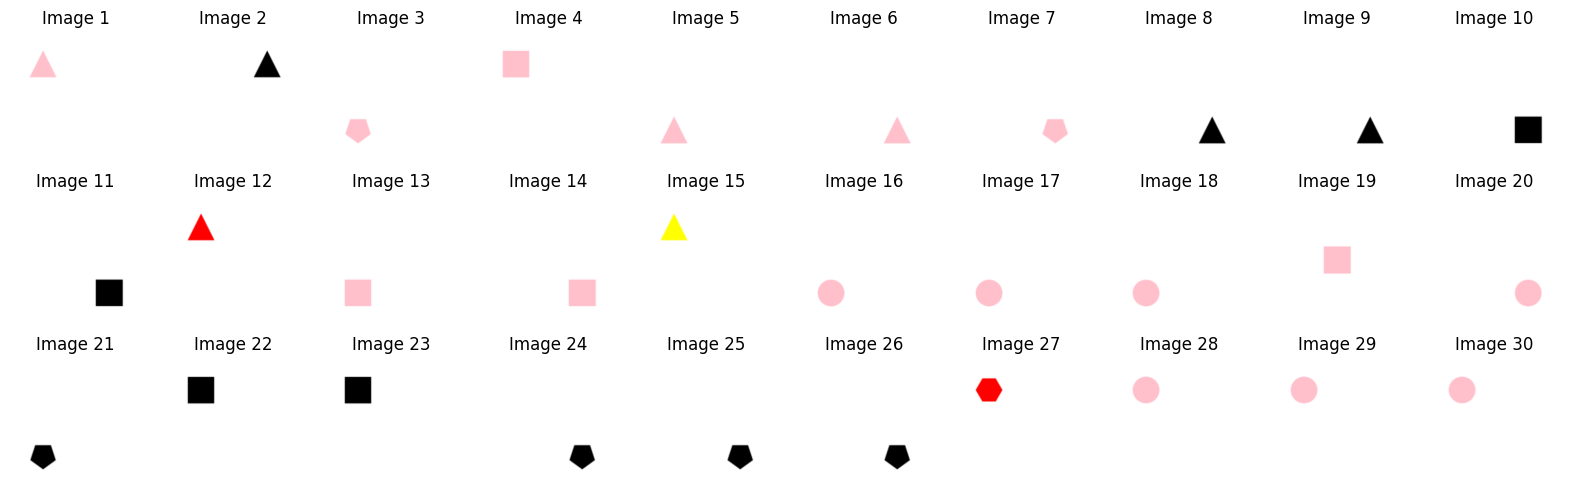

mean_22_875
[('M', np.float64(0.7666666666666667)), ('circle', np.float64(0.5333333333333333)), ('pink', np.float64(0.4)), ('green', np.float64(0.2666666666666666)), ('pentagon', np.float64(0.2333333333333333))]
Neuron: mean_22_875


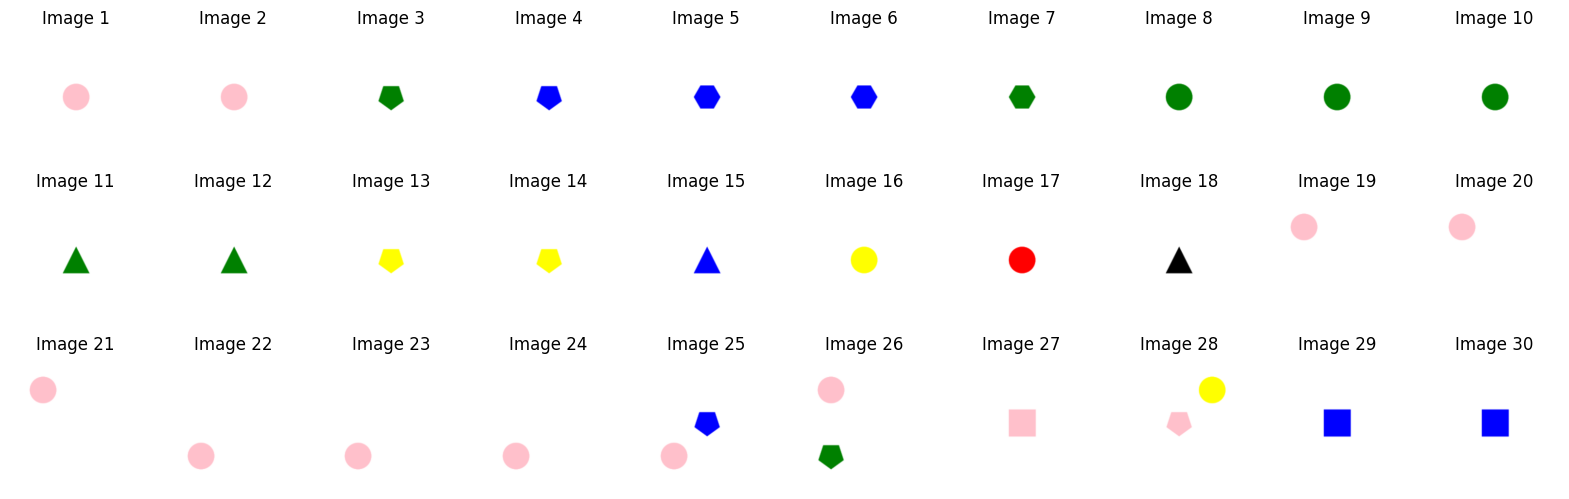

mean_18_314
[('circle', np.float64(0.6333333333333333)), ('pink', np.float64(0.5333333333333333)), ('square', np.float64(0.3333333333333333)), ('red', np.float64(0.3333333333333333)), ('BL', np.float64(0.3333333333333333))]
Neuron: mean_18_314


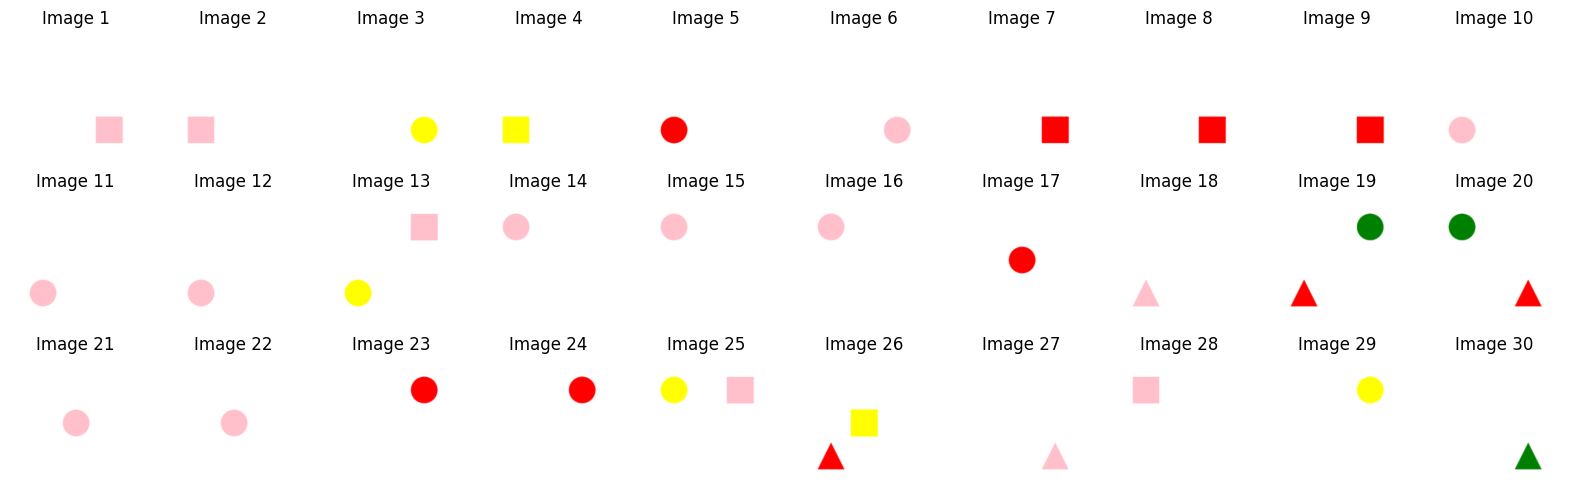

mean_16_557
[('circle', np.float64(0.6)), ('M', np.float64(0.5333333333333333)), ('pink', np.float64(0.5)), ('square', np.float64(0.3333333333333333)), ('yellow', np.float64(0.3333333333333333))]
Neuron: mean_16_557


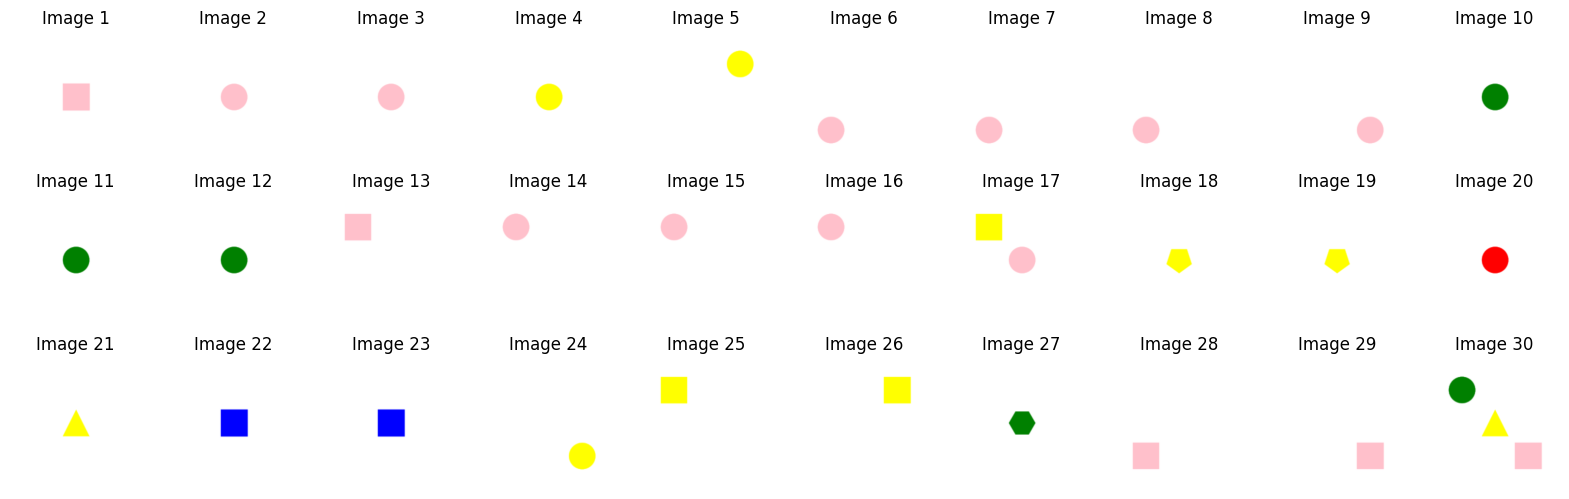

mean_19_58
[('M', np.float64(0.7666666666666667)), ('circle', np.float64(0.3333333333333333)), ('green', np.float64(0.3)), ('pentagon', np.float64(0.2666666666666666)), ('blue', np.float64(0.2666666666666666))]
Neuron: mean_19_58


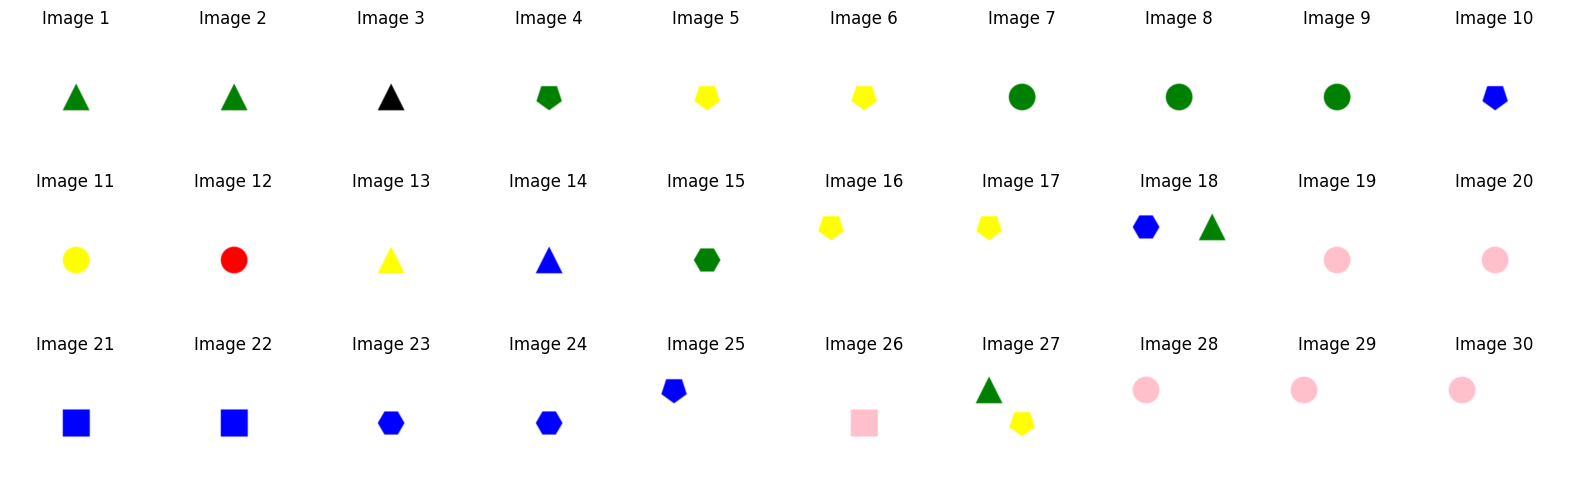

mean_18_432
[('circle', np.float64(0.8)), ('pink', np.float64(0.5666666666666667)), ('M', np.float64(0.4666666666666667)), ('TL', np.float64(0.3333333333333333)), ('red', np.float64(0.2))]
Neuron: mean_18_432


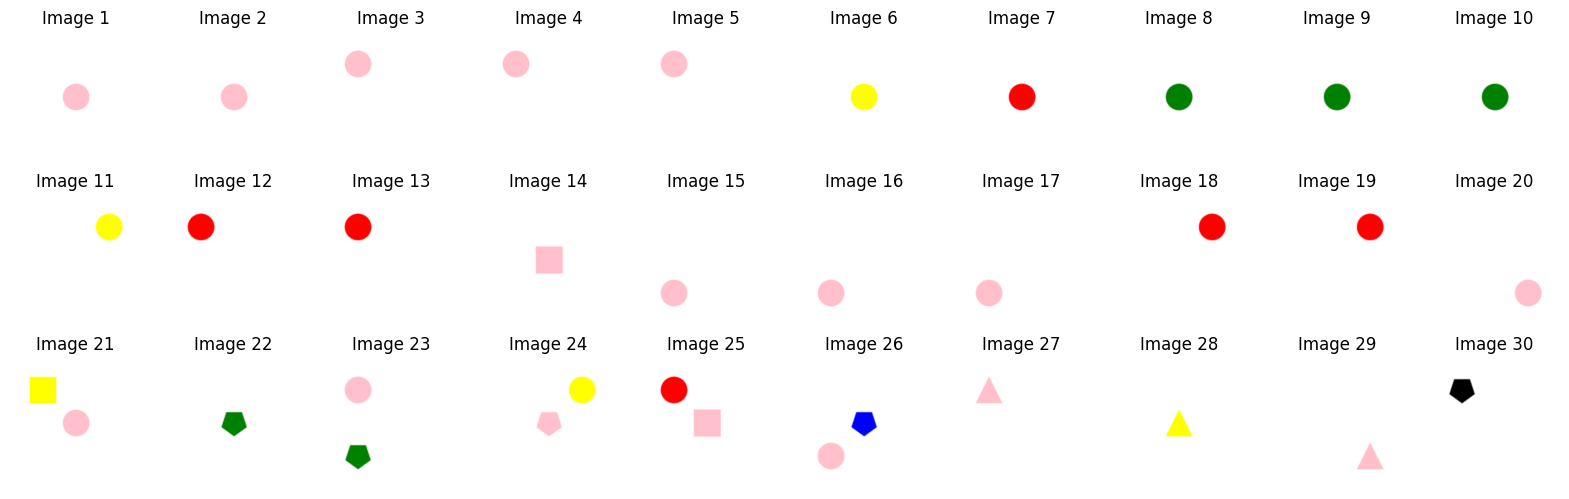

mean_18_934
[('circle', np.float64(0.5666666666666667)), ('pink', np.float64(0.5)), ('square', np.float64(0.4666666666666667)), ('yellow', np.float64(0.4)), ('TL', np.float64(0.4))]
Neuron: mean_18_934


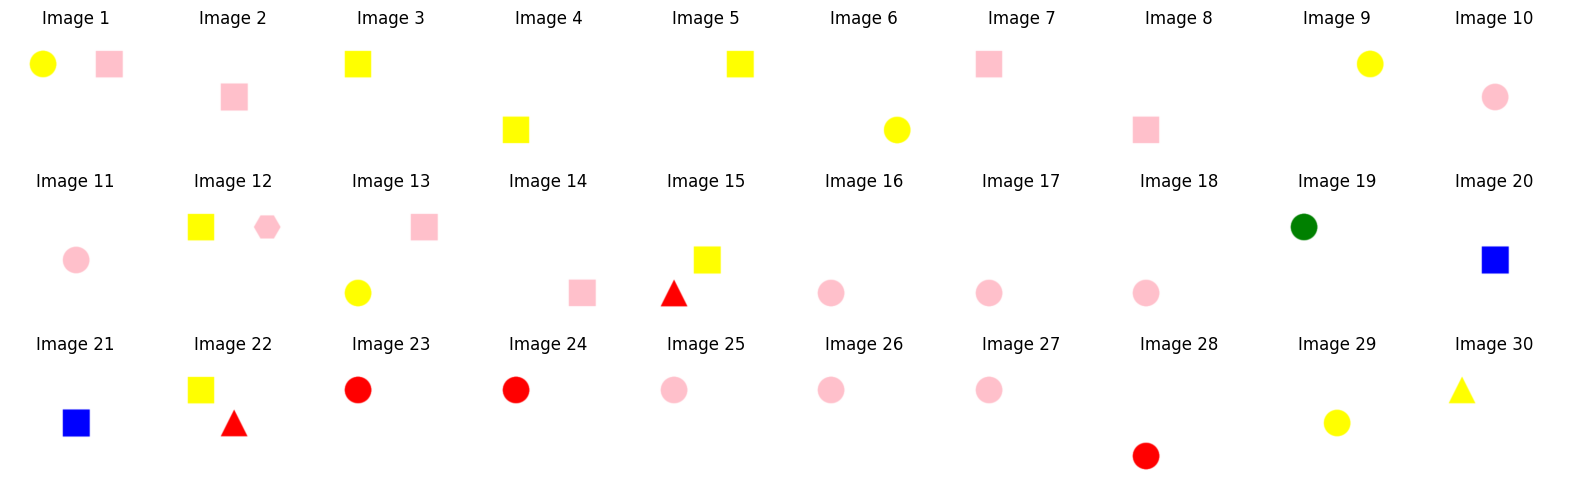

mean_18_574
[('circle', np.float64(0.6333333333333333)), ('square', np.float64(0.4333333333333333)), ('pink', np.float64(0.4333333333333333)), ('TL', np.float64(0.3666666666666666)), ('red', np.float64(0.3))]
Neuron: mean_18_574


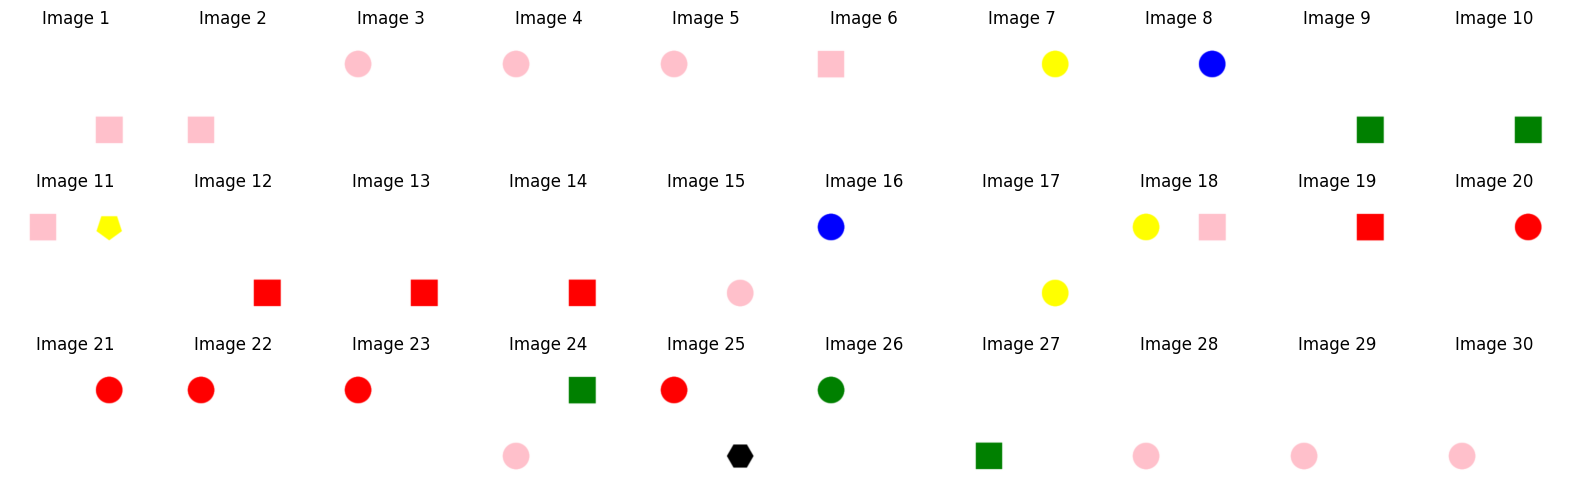

mean_22_752
[('M', np.float64(0.7666666666666667)), ('circle', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.3)), ('blue', np.float64(0.2666666666666666)), ('pink', np.float64(0.2666666666666666))]
Neuron: mean_22_752


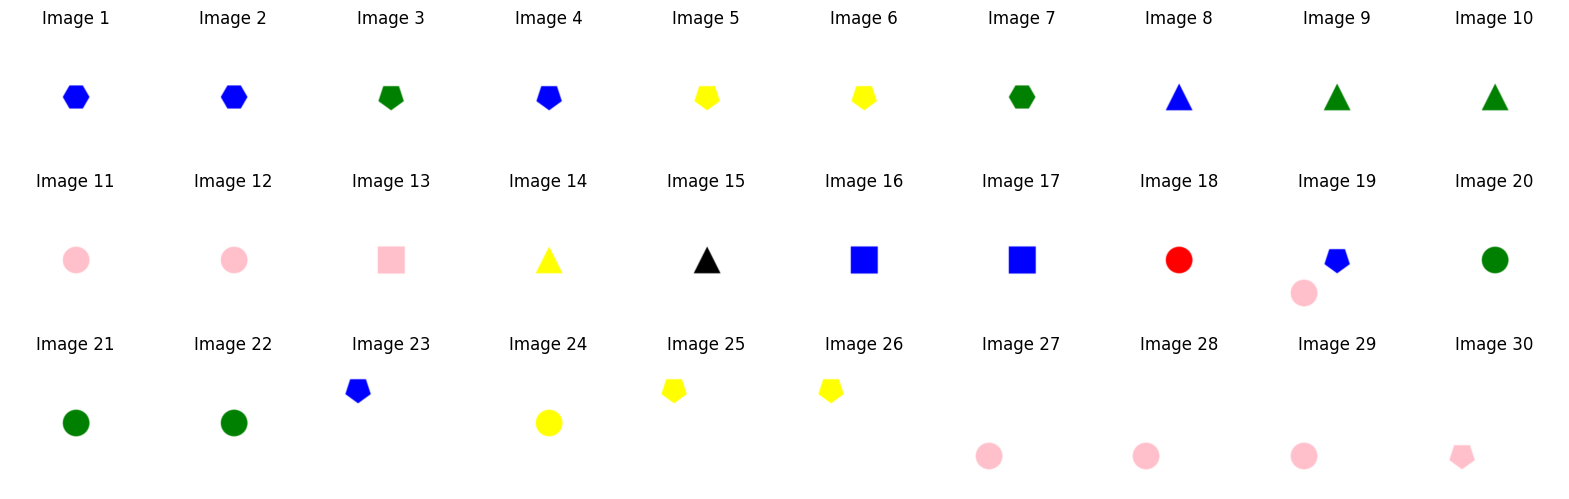

mean_14_967
[('black', np.float64(0.5)), ('BR', np.float64(0.4666666666666667)), ('pentagon', np.float64(0.4333333333333333)), ('pink', np.float64(0.4333333333333333)), ('hexagon', np.float64(0.2666666666666666))]
Neuron: mean_14_967


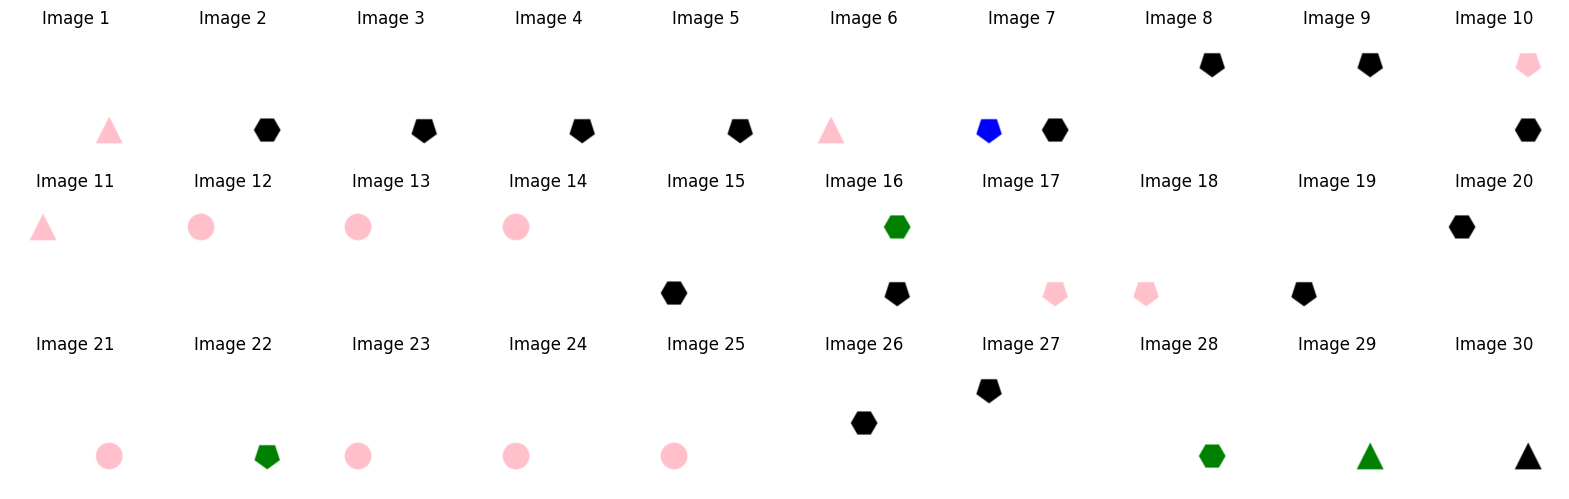

mean_21_894
[('M', np.float64(0.7333333333333333)), ('circle', np.float64(0.5333333333333333)), ('pink', np.float64(0.3666666666666666)), ('green', np.float64(0.2333333333333333)), ('yellow', np.float64(0.2333333333333333))]
Neuron: mean_21_894


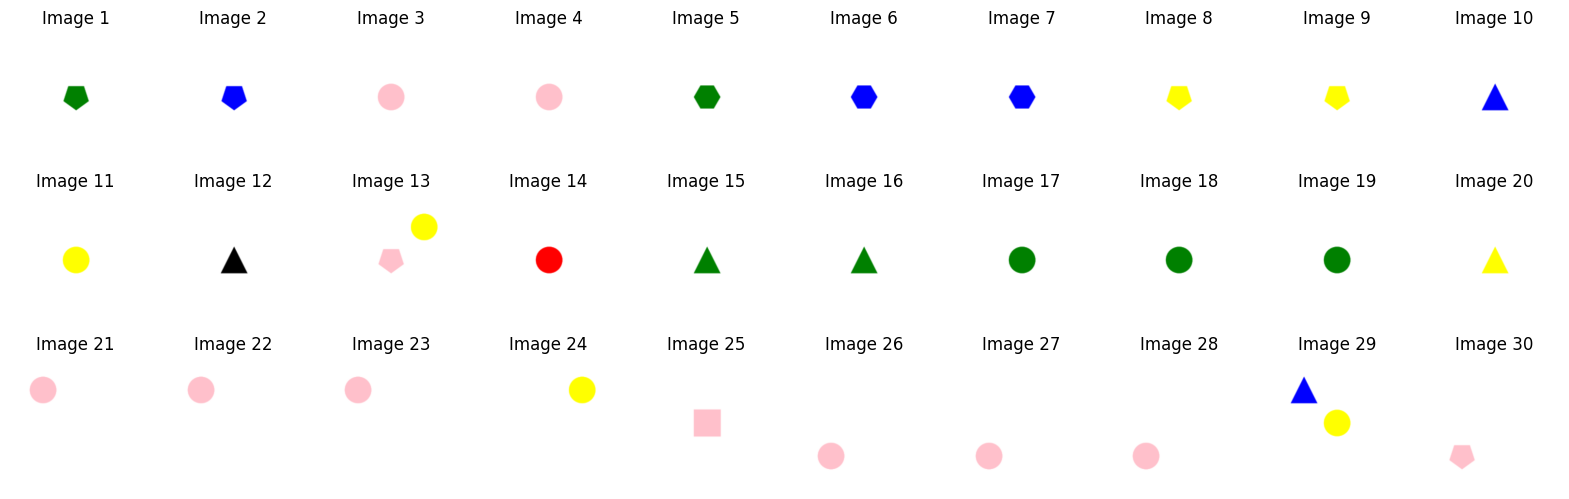

mean_15_210
[('pink', np.float64(0.8)), ('circle', np.float64(0.6333333333333333)), ('square', np.float64(0.5333333333333333)), ('BL', np.float64(0.4)), ('TL', np.float64(0.3333333333333333))]
Neuron: mean_15_210


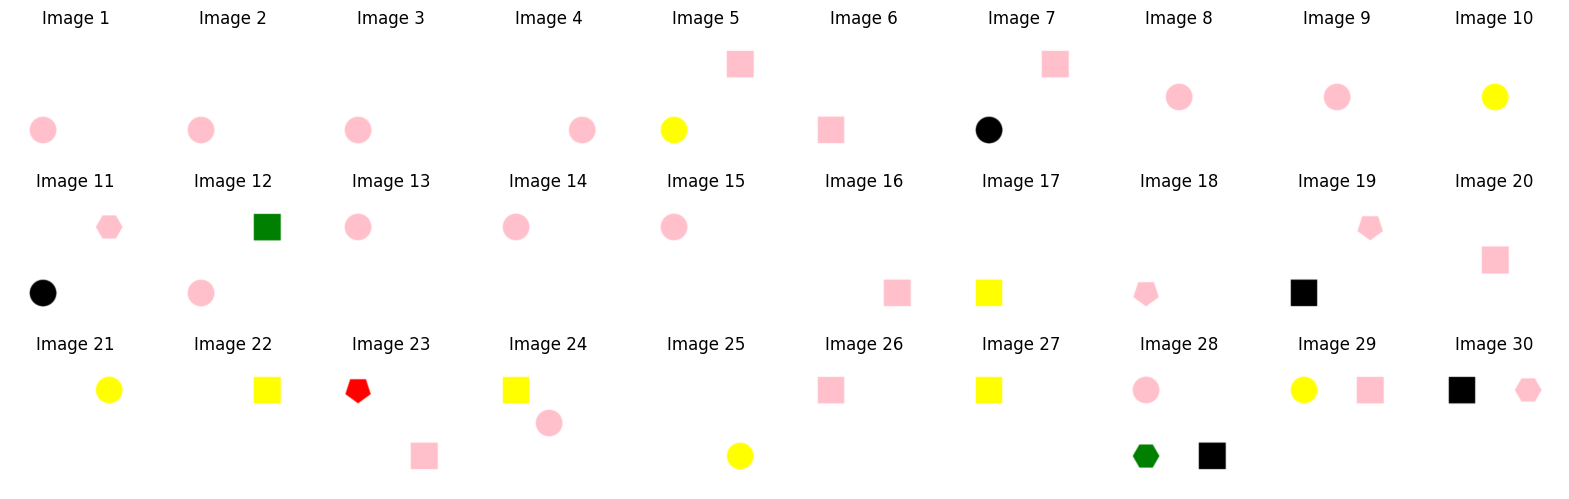

mean_22_485
[('M', np.float64(0.7333333333333333)), ('circle', np.float64(0.4)), ('pentagon', np.float64(0.2666666666666666)), ('yellow', np.float64(0.2666666666666666)), ('green', np.float64(0.2333333333333333))]
Neuron: mean_22_485


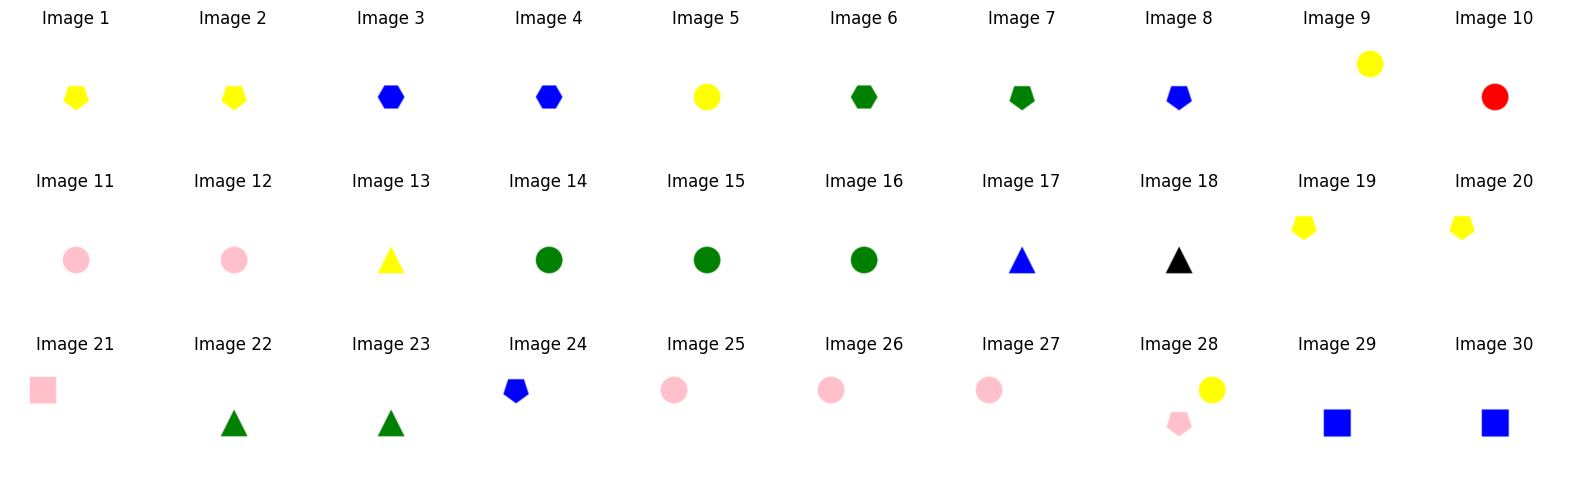

mean_15_484
[('M', np.float64(0.7666666666666667)), ('circle', np.float64(0.3333333333333333)), ('pink', np.float64(0.3333333333333333)), ('triangle', np.float64(0.2333333333333333)), ('green', np.float64(0.2333333333333333))]
Neuron: mean_15_484


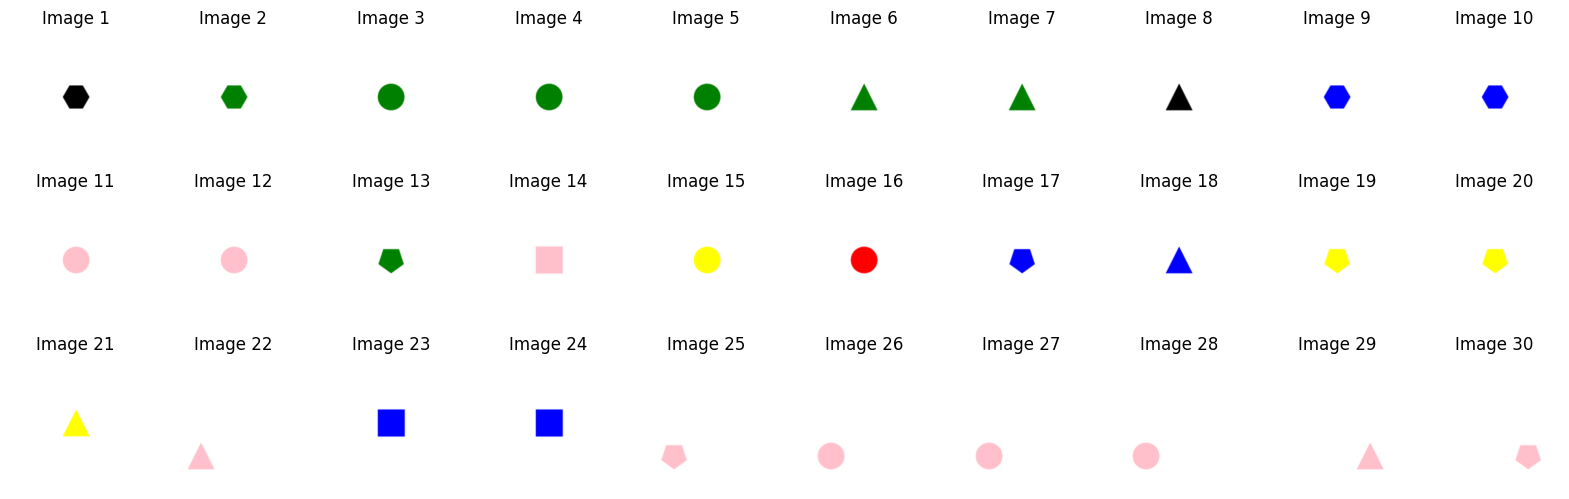

mean_16_1011
[('circle', np.float64(0.5666666666666667)), ('M', np.float64(0.4666666666666667)), ('TL', np.float64(0.3333333333333333)), ('yellow', np.float64(0.3)), ('TR', np.float64(0.3))]
Neuron: mean_16_1011


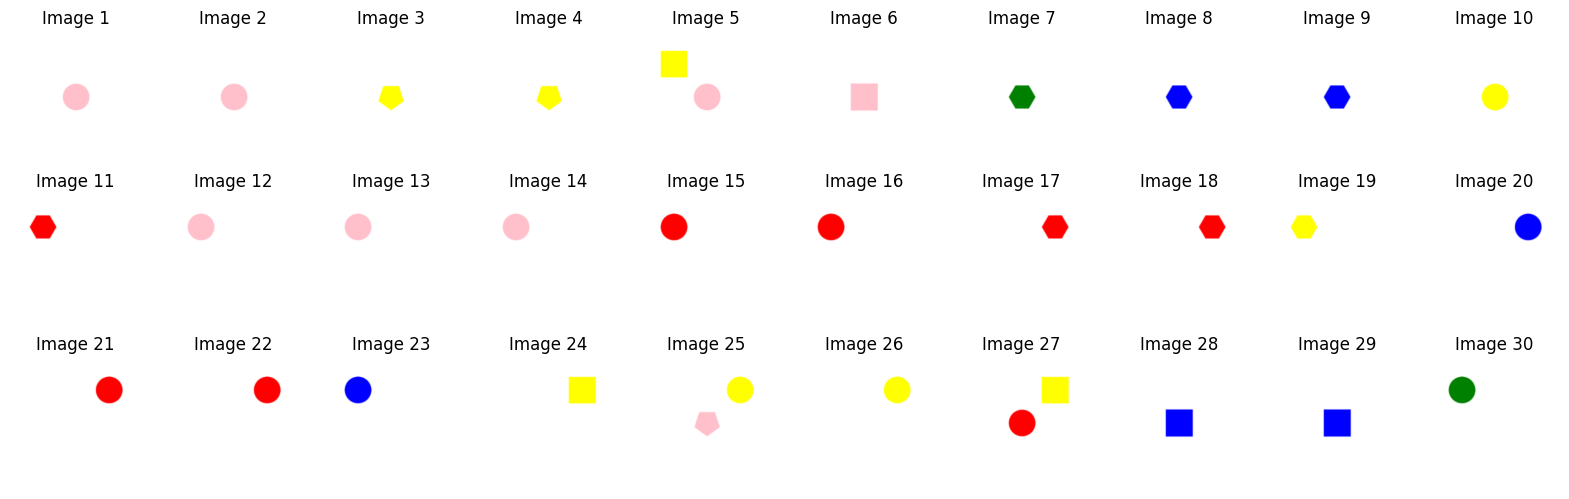

mean_14_213
[('circle', np.float64(0.6)), ('M', np.float64(0.5)), ('pink', np.float64(0.4333333333333333)), ('BL', np.float64(0.3333333333333333)), ('blue', np.float64(0.2333333333333333))]
Neuron: mean_14_213


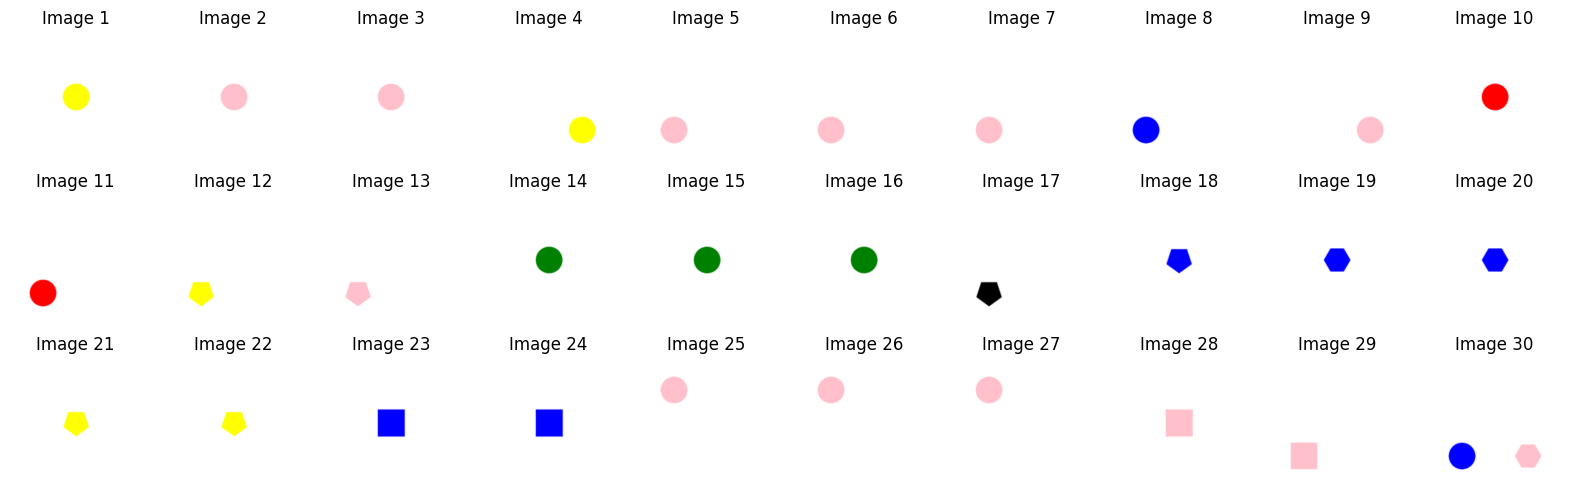

mean_22_400
[('M', np.float64(0.7)), ('circle', np.float64(0.5)), ('pink', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.3)), ('green', np.float64(0.2333333333333333))]
Neuron: mean_22_400


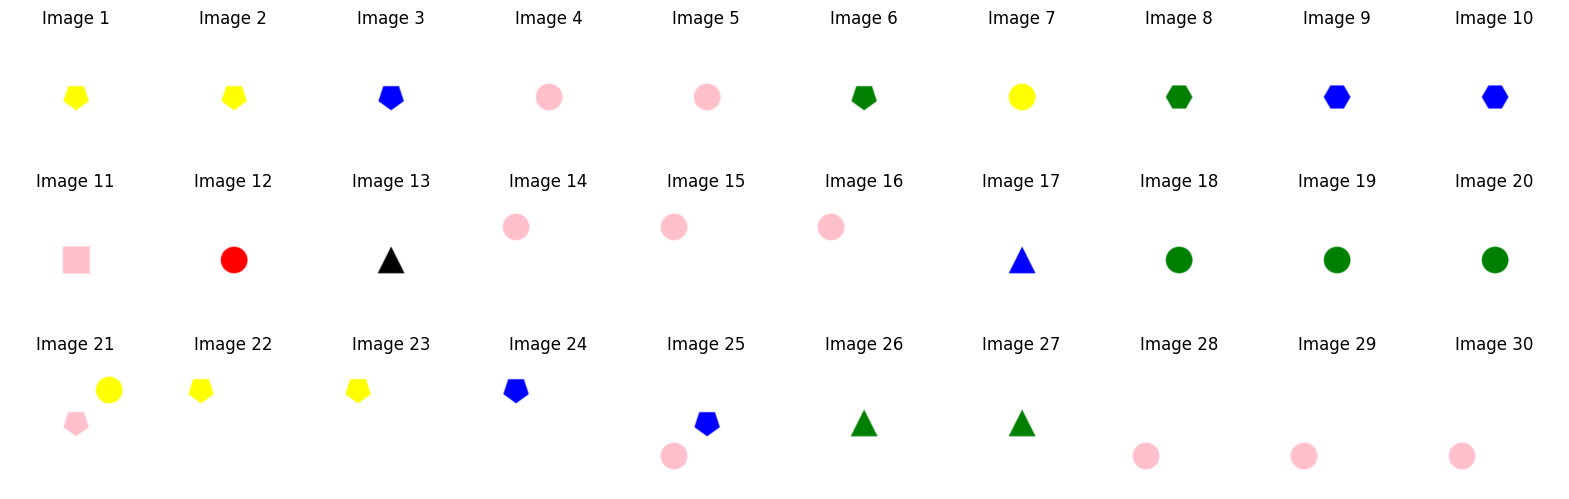

mean_21_296
[('M', np.float64(0.7333333333333333)), ('circle', np.float64(0.4666666666666667)), ('pink', np.float64(0.3333333333333333)), ('green', np.float64(0.2333333333333333)), ('blue', np.float64(0.2))]
Neuron: mean_21_296


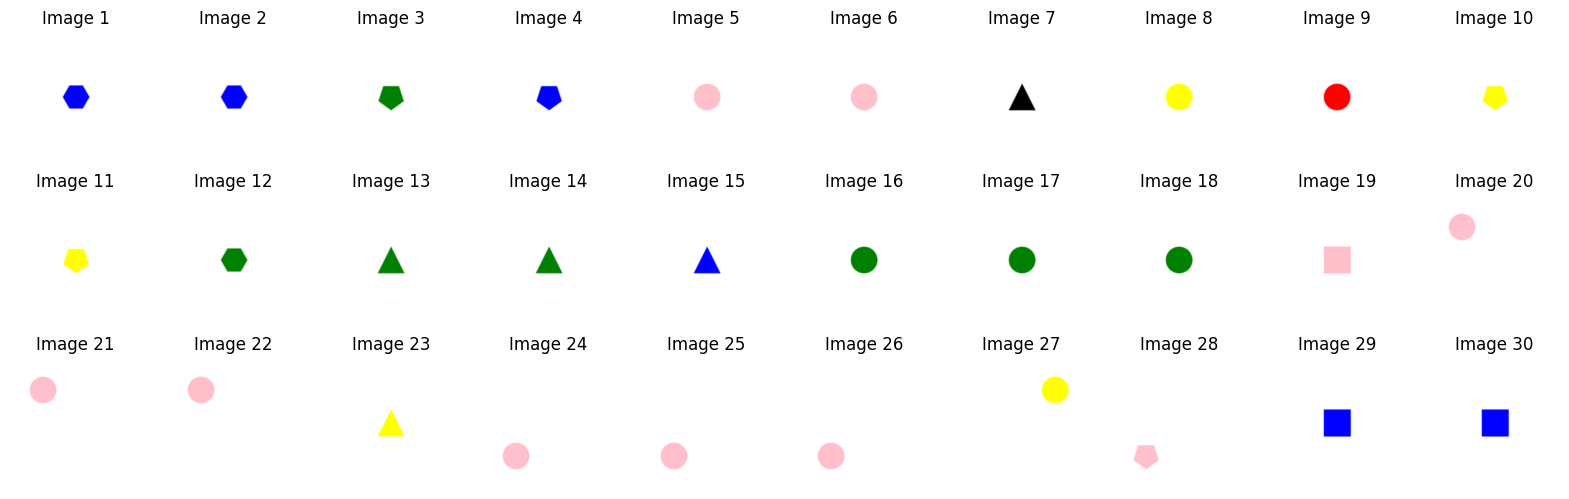

mean_19_1004
[('M', np.float64(0.7333333333333333)), ('green', np.float64(0.3666666666666666)), ('circle', np.float64(0.3)), ('blue', np.float64(0.3)), ('triangle', np.float64(0.2))]
Neuron: mean_19_1004


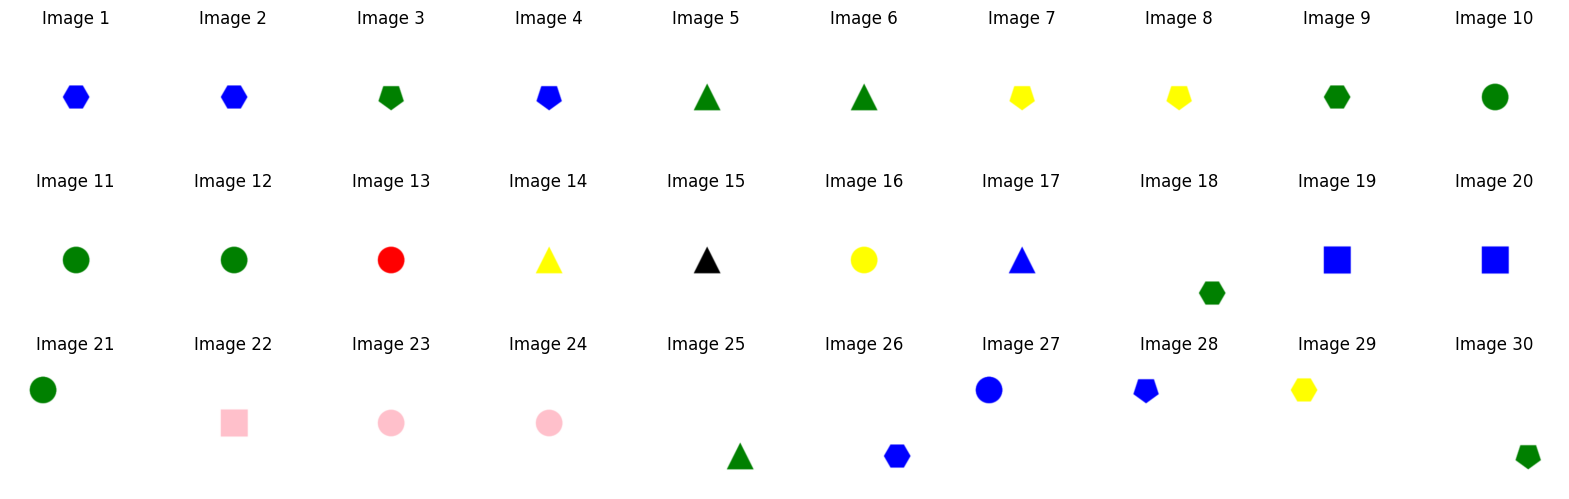

mean_17_686
[('M', np.float64(0.7)), ('circle', np.float64(0.5333333333333333)), ('pink', np.float64(0.3)), ('green', np.float64(0.2333333333333333)), ('blue', np.float64(0.2333333333333333))]
Neuron: mean_17_686


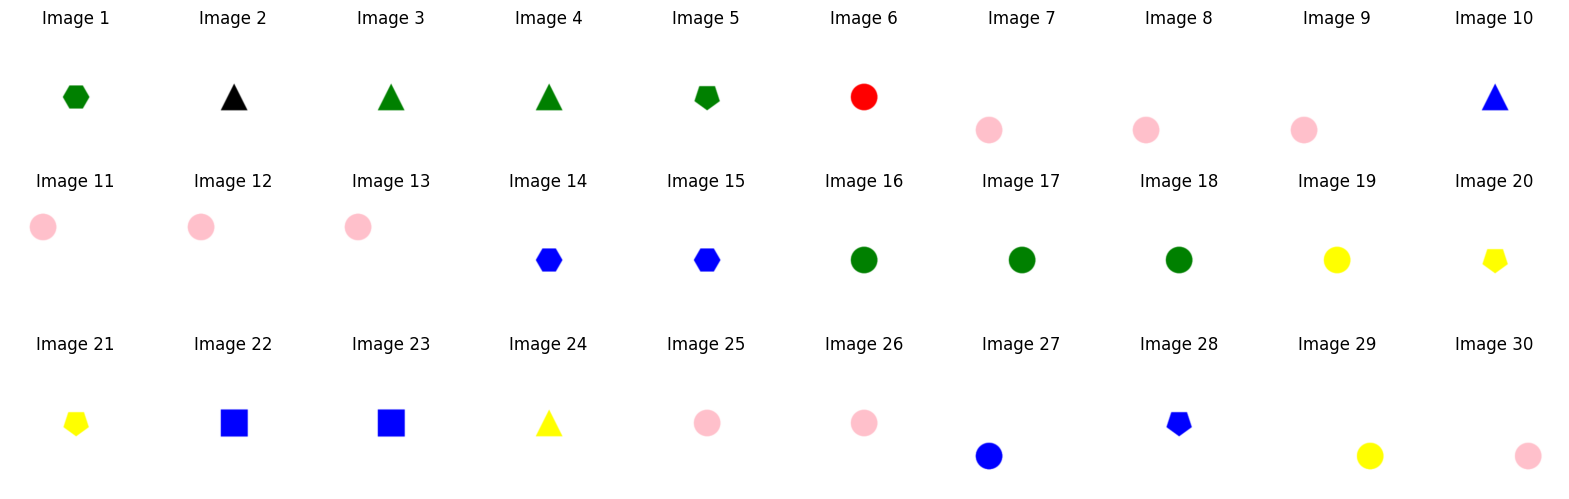

mean_18_21
[('circle', np.float64(0.6333333333333333)), ('M', np.float64(0.5)), ('pink', np.float64(0.4333333333333333)), ('red', np.float64(0.2)), ('TL', np.float64(0.2))]
Neuron: mean_18_21


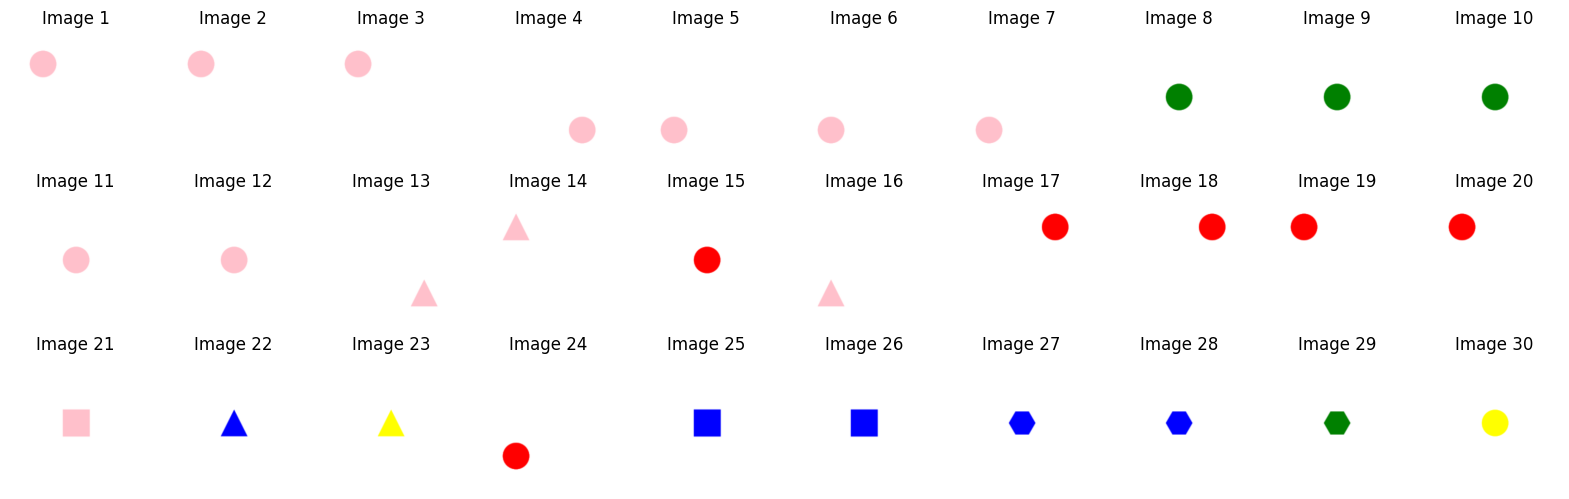

mean_21_150
[('M', np.float64(0.8333333333333334)), ('circle', np.float64(0.4333333333333333)), ('green', np.float64(0.3)), ('pink', np.float64(0.3)), ('blue', np.float64(0.2666666666666666))]
Neuron: mean_21_150


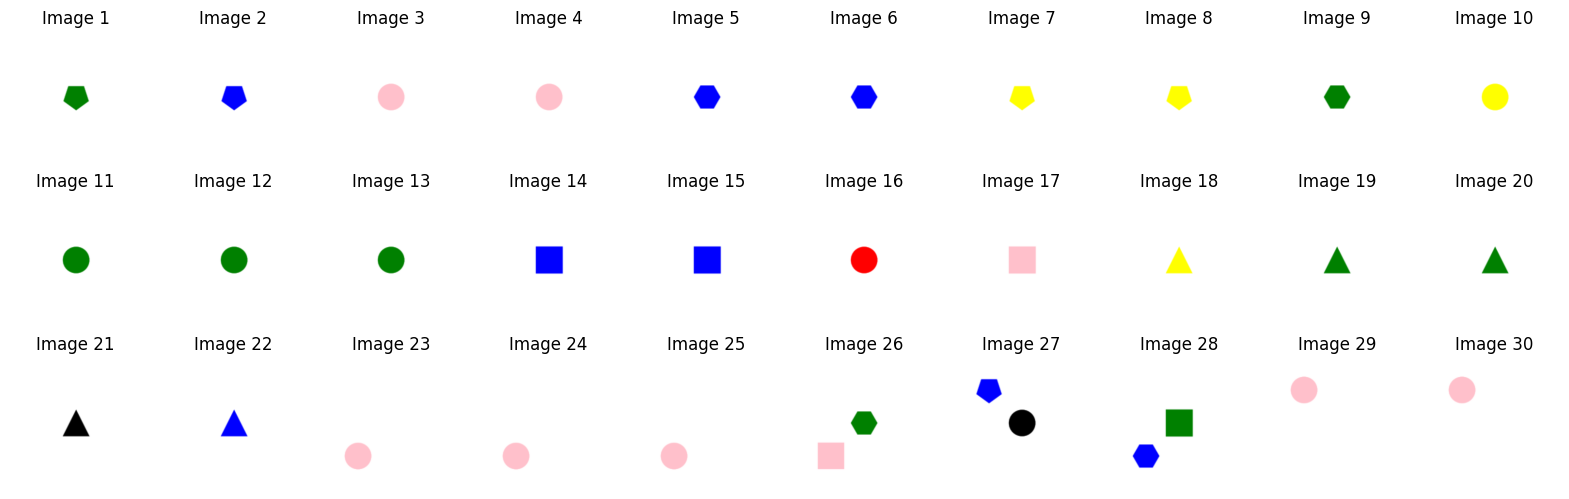

mean_16_374
[('circle', np.float64(0.6333333333333333)), ('square', np.float64(0.3333333333333333)), ('pink', np.float64(0.3333333333333333)), ('BR', np.float64(0.3333333333333333)), ('red', np.float64(0.2666666666666666))]
Neuron: mean_16_374


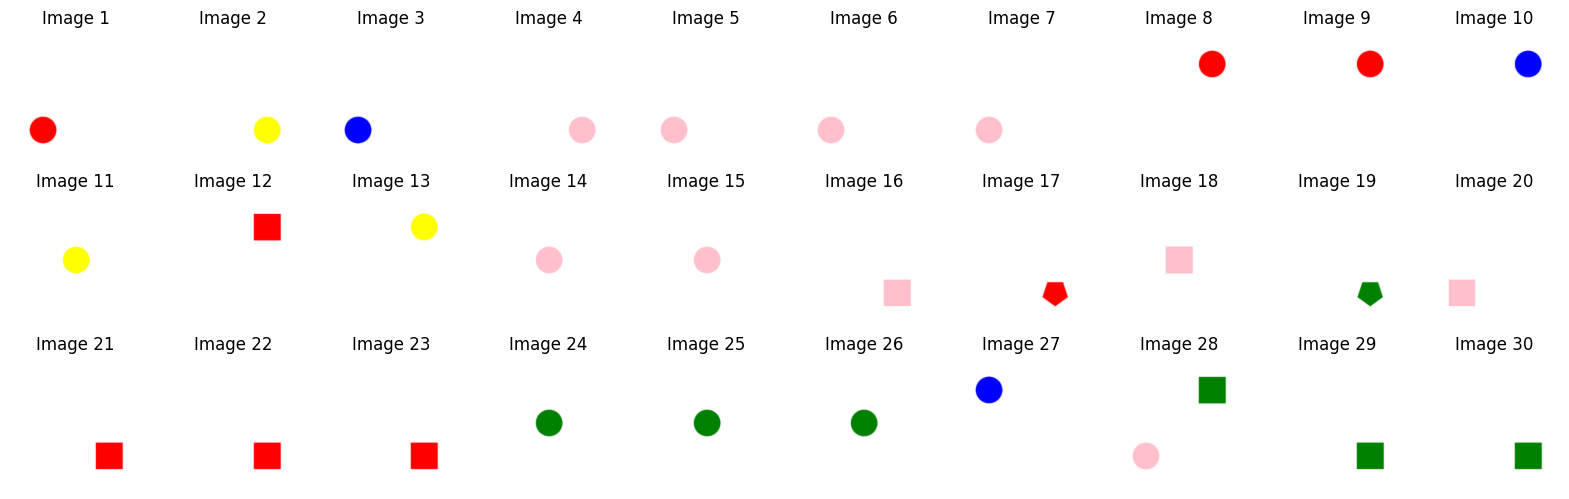

mean_21_484
[('M', np.float64(0.6)), ('circle', np.float64(0.4666666666666667)), ('yellow', np.float64(0.3)), ('pink', np.float64(0.3)), ('pentagon', np.float64(0.2666666666666666))]
Neuron: mean_21_484


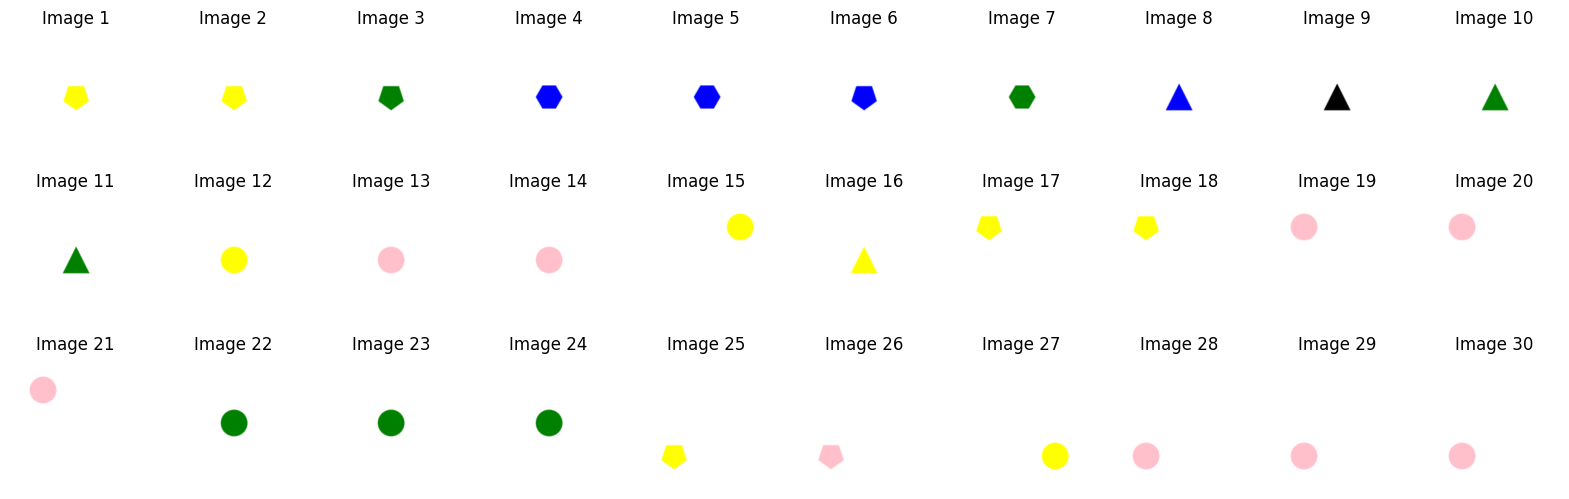

mean_22_187
[('M', np.float64(0.8)), ('circle', np.float64(0.5)), ('pink', np.float64(0.3)), ('green', np.float64(0.2666666666666666)), ('blue', np.float64(0.2333333333333333))]
Neuron: mean_22_187


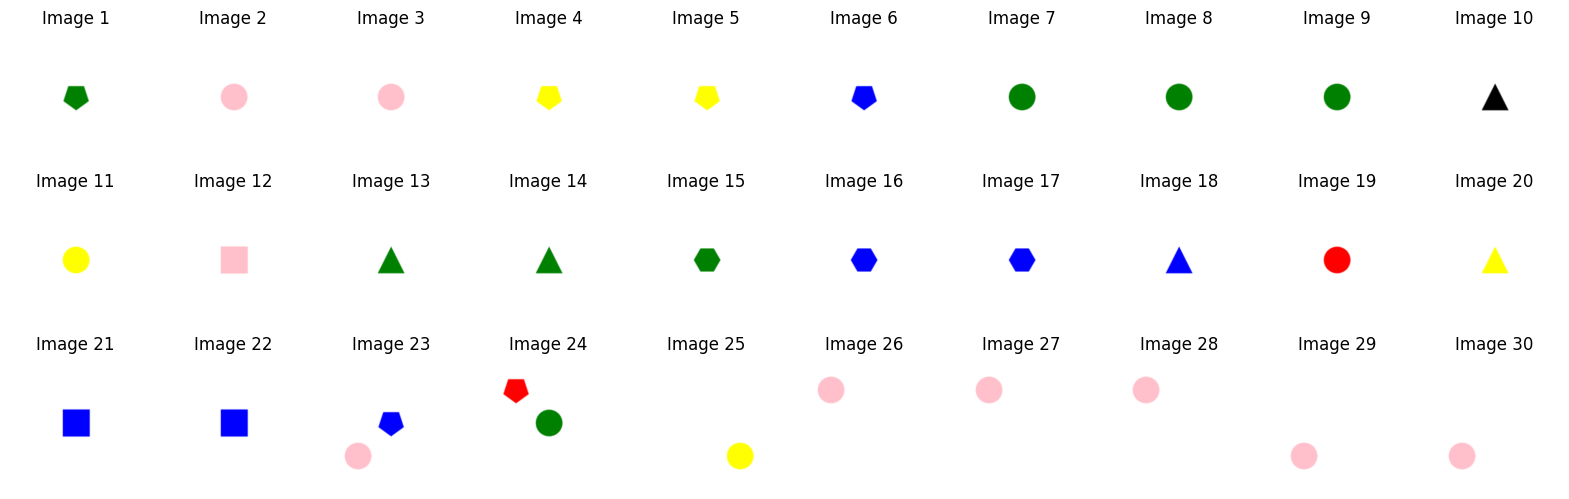

mean_22_700
[('M', np.float64(0.7666666666666667)), ('green', np.float64(0.4333333333333333)), ('circle', np.float64(0.2333333333333333)), ('square', np.float64(0.2333333333333333)), ('pentagon', np.float64(0.2333333333333333))]
Neuron: mean_22_700


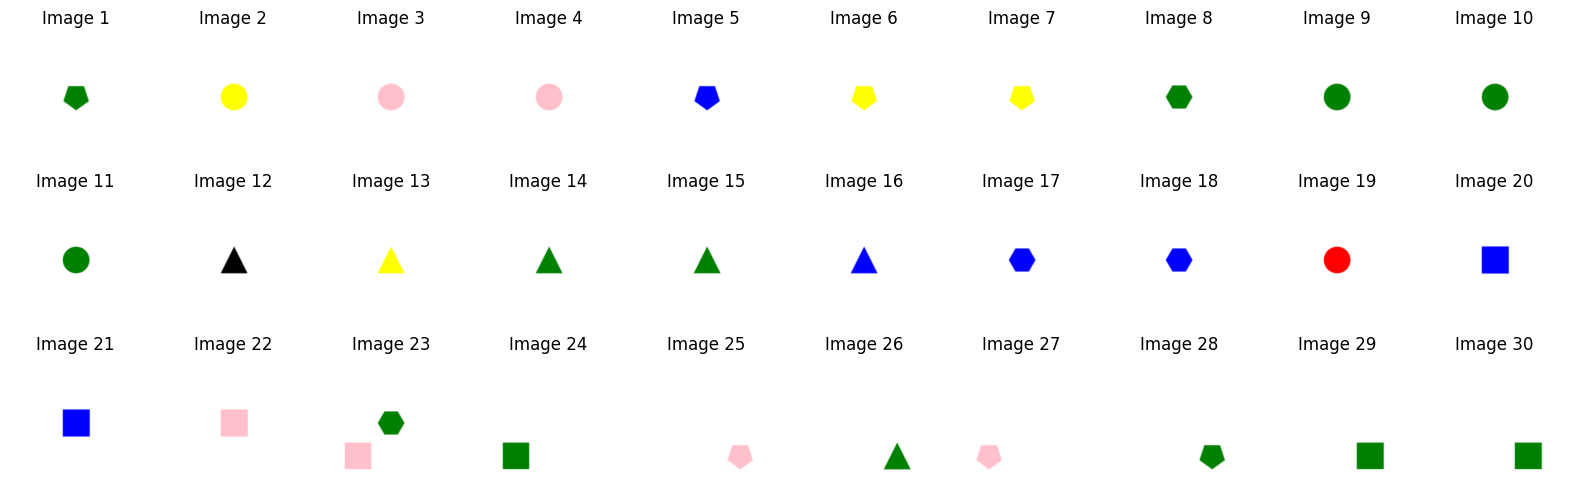

mean_15_9
[('M', np.float64(0.8)), ('circle', np.float64(0.4)), ('pentagon', np.float64(0.3333333333333333)), ('yellow', np.float64(0.3333333333333333)), ('green', np.float64(0.3))]
Neuron: mean_15_9


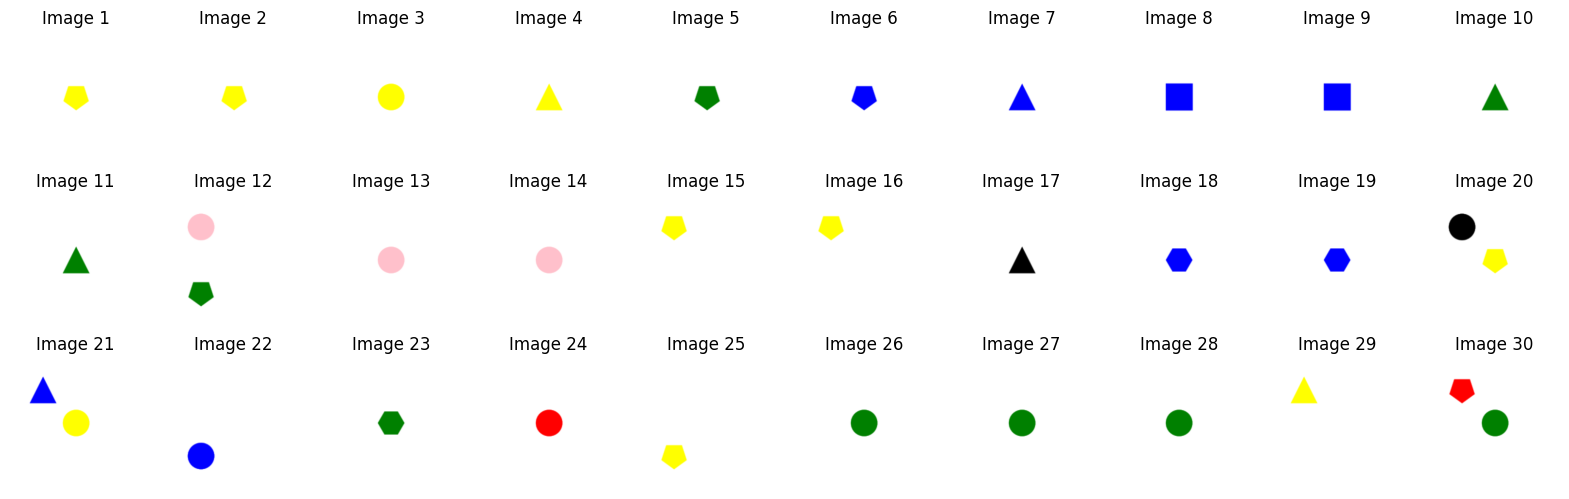

mean_20_10
[('M', np.float64(0.7)), ('circle', np.float64(0.3666666666666666)), ('pink', np.float64(0.3666666666666666)), ('green', np.float64(0.2666666666666666)), ('triangle', np.float64(0.2333333333333333))]
Neuron: mean_20_10


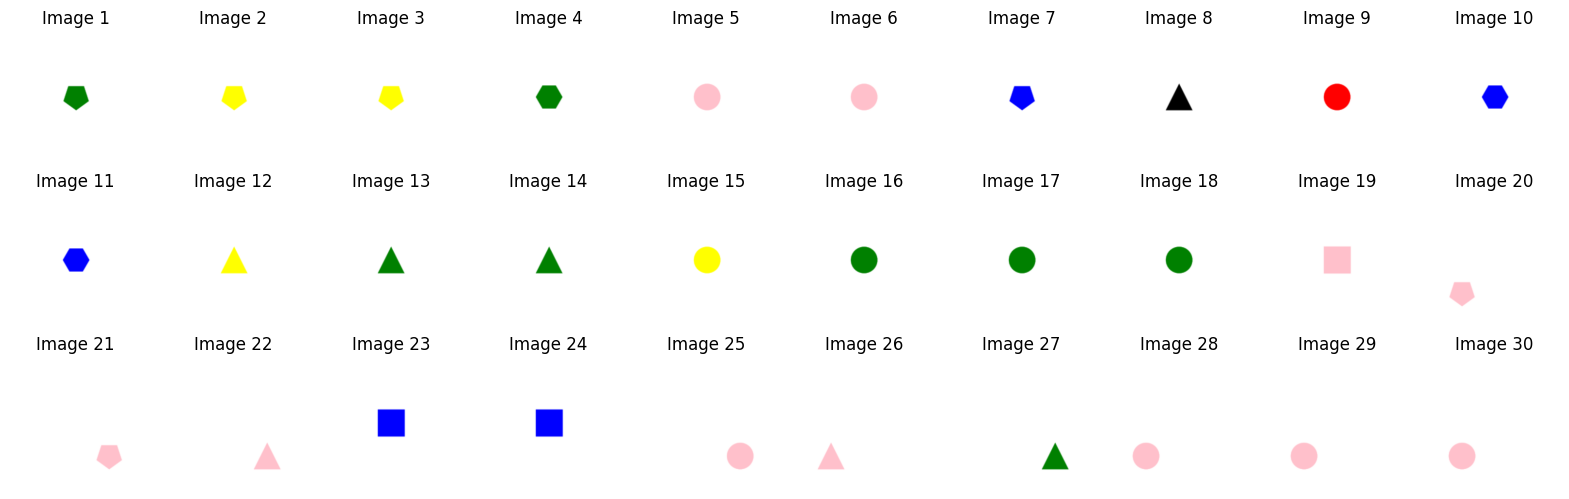

mean_21_478
[('M', np.float64(0.6666666666666666)), ('circle', np.float64(0.4)), ('pentagon', np.float64(0.4)), ('green', np.float64(0.3)), ('pink', np.float64(0.3))]
Neuron: mean_21_478


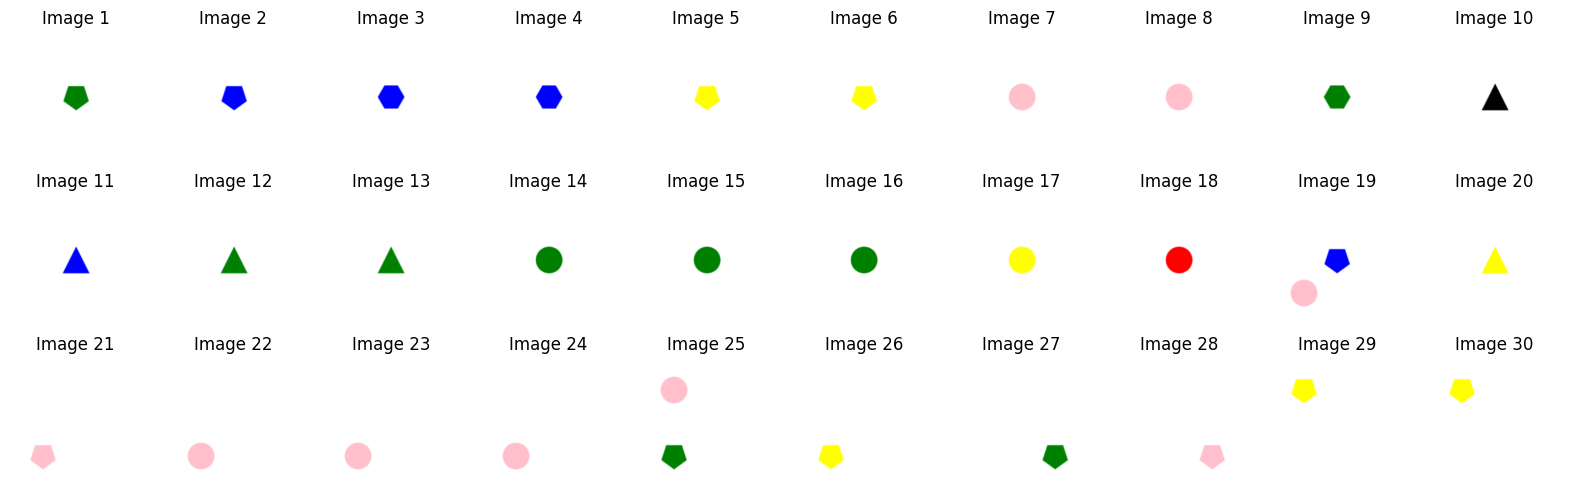

mean_21_17
[('M', np.float64(0.7333333333333333)), ('circle', np.float64(0.4333333333333333)), ('pentagon', np.float64(0.3666666666666666)), ('pink', np.float64(0.3333333333333333)), ('green', np.float64(0.2666666666666666))]
Neuron: mean_21_17


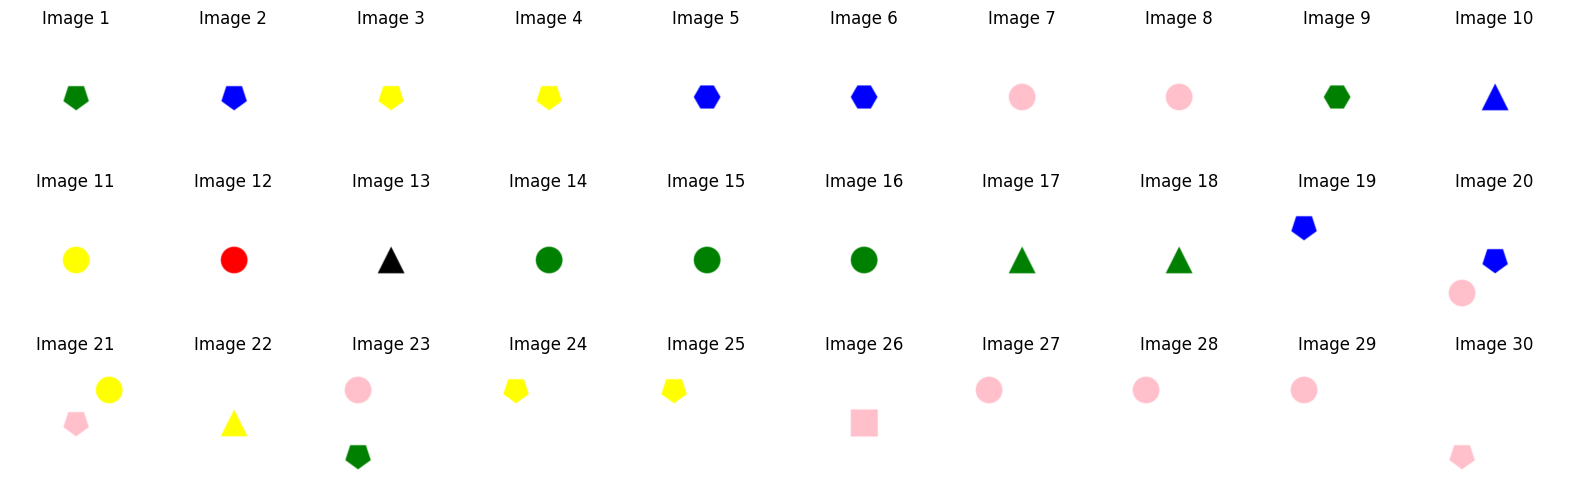

mean_22_361
[('M', np.float64(0.7333333333333333)), ('circle', np.float64(0.4666666666666667)), ('pink', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.2333333333333333)), ('green', np.float64(0.2333333333333333))]
Neuron: mean_22_361


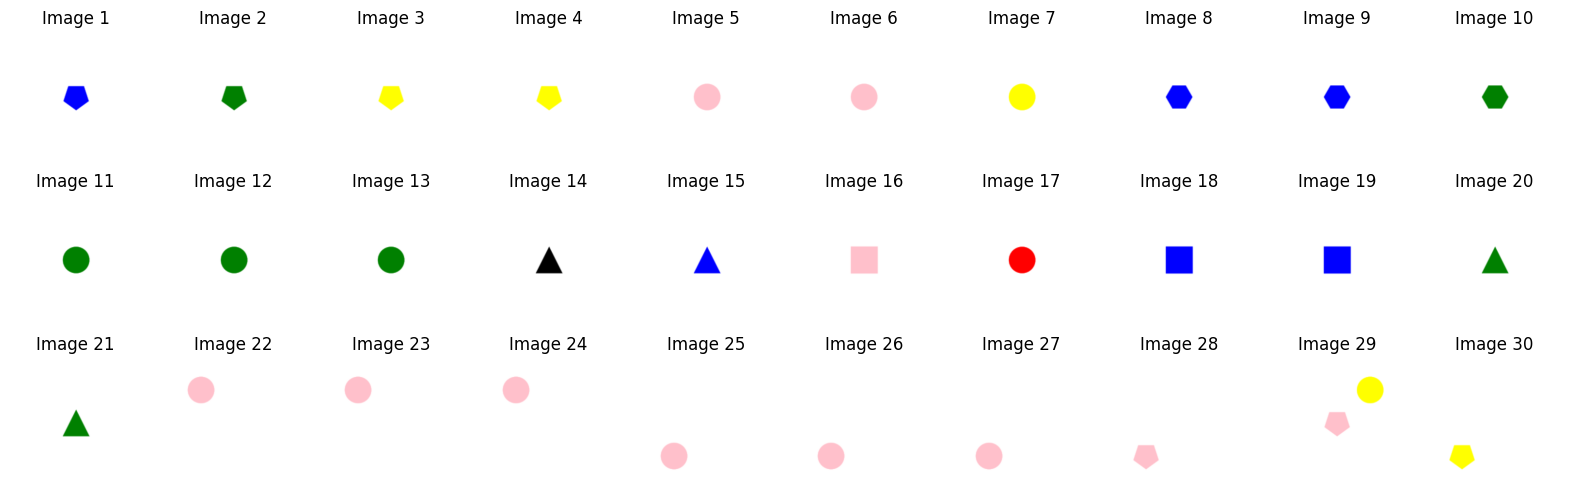

mean_20_184
[('M', np.float64(0.7666666666666667)), ('circle', np.float64(0.3333333333333333)), ('green', np.float64(0.3333333333333333)), ('pink', np.float64(0.3)), ('pentagon', np.float64(0.2333333333333333))]
Neuron: mean_20_184


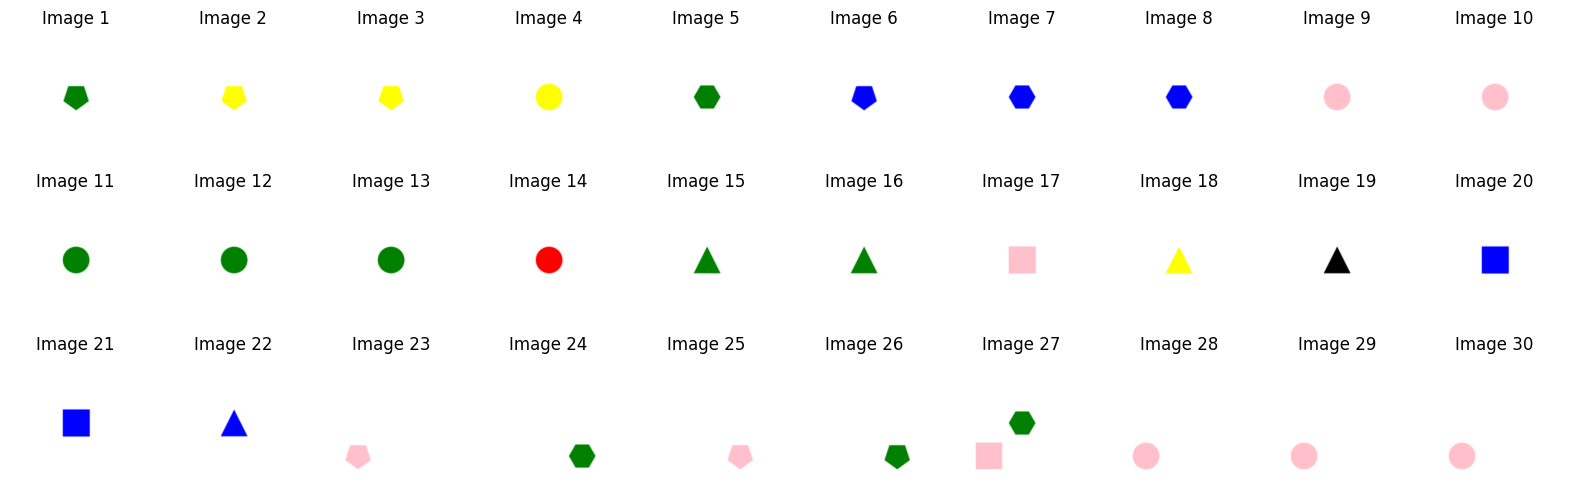

mean_20_653
[('circle', np.float64(0.5666666666666667)), ('pink', np.float64(0.5666666666666667)), ('yellow', np.float64(0.5333333333333333)), ('TL', np.float64(0.4666666666666667)), ('square', np.float64(0.3333333333333333))]
Neuron: mean_20_653


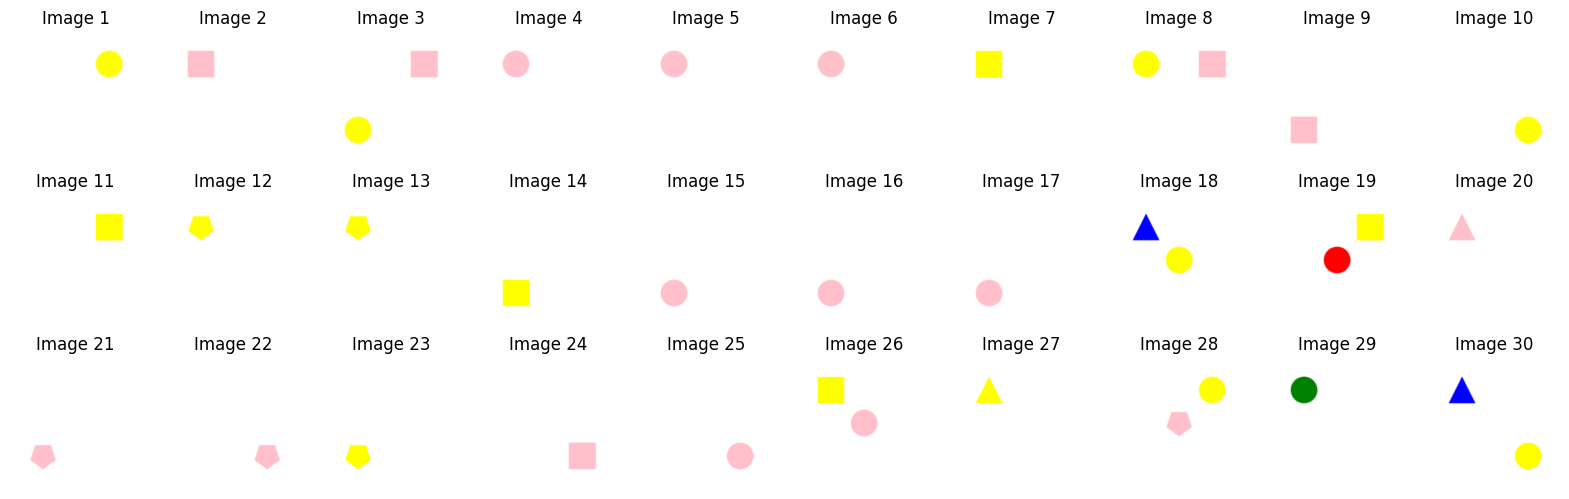

mean_14_583
[('BR', np.float64(0.5333333333333333)), ('square', np.float64(0.4333333333333333)), ('BL', np.float64(0.3666666666666666)), ('circle', np.float64(0.2666666666666666)), ('pink', np.float64(0.2666666666666666))]
Neuron: mean_14_583


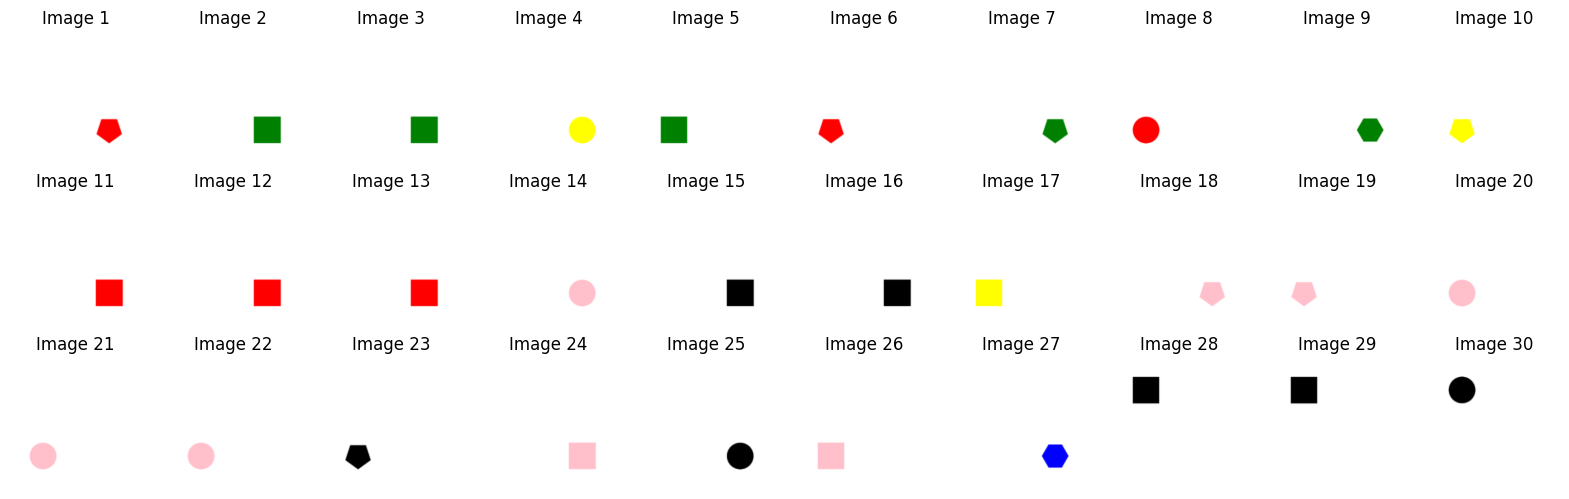

mean_19_359
[('M', np.float64(0.9666666666666668)), ('circle', np.float64(0.4333333333333333)), ('blue', np.float64(0.3333333333333333)), ('triangle', np.float64(0.3)), ('pentagon', np.float64(0.3))]
Neuron: mean_19_359


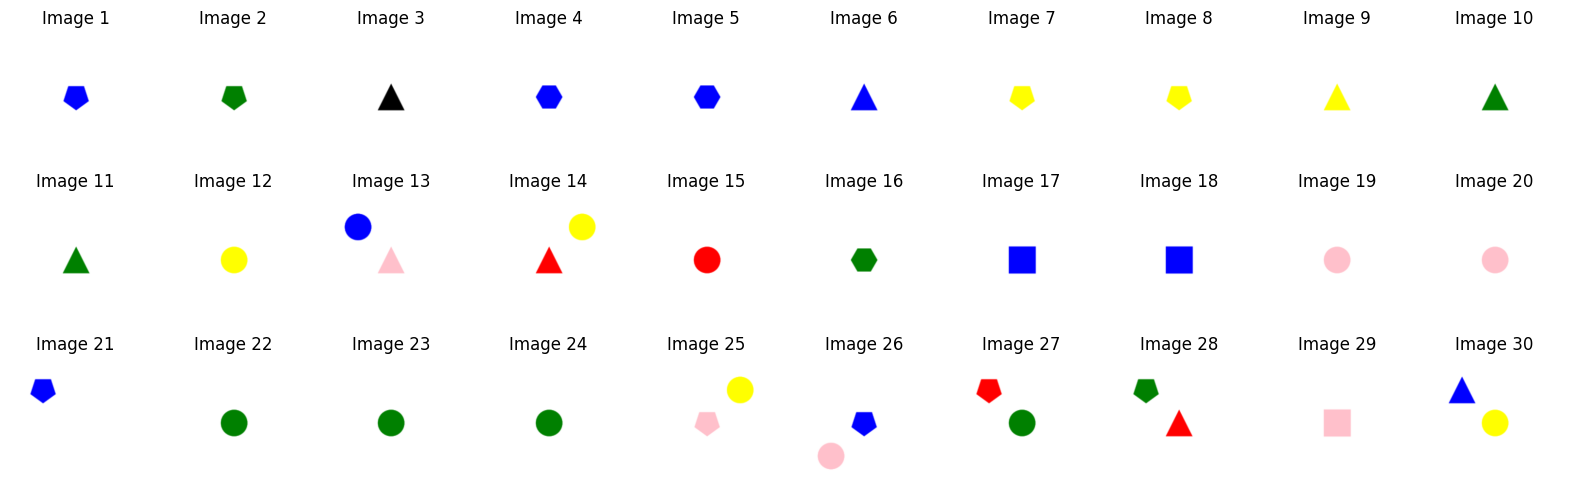

mean_15_491
[('BR', np.float64(0.5)), ('square', np.float64(0.4666666666666667)), ('M', np.float64(0.4333333333333333)), ('hexagon', np.float64(0.3666666666666666)), ('red', np.float64(0.3333333333333333))]
Neuron: mean_15_491


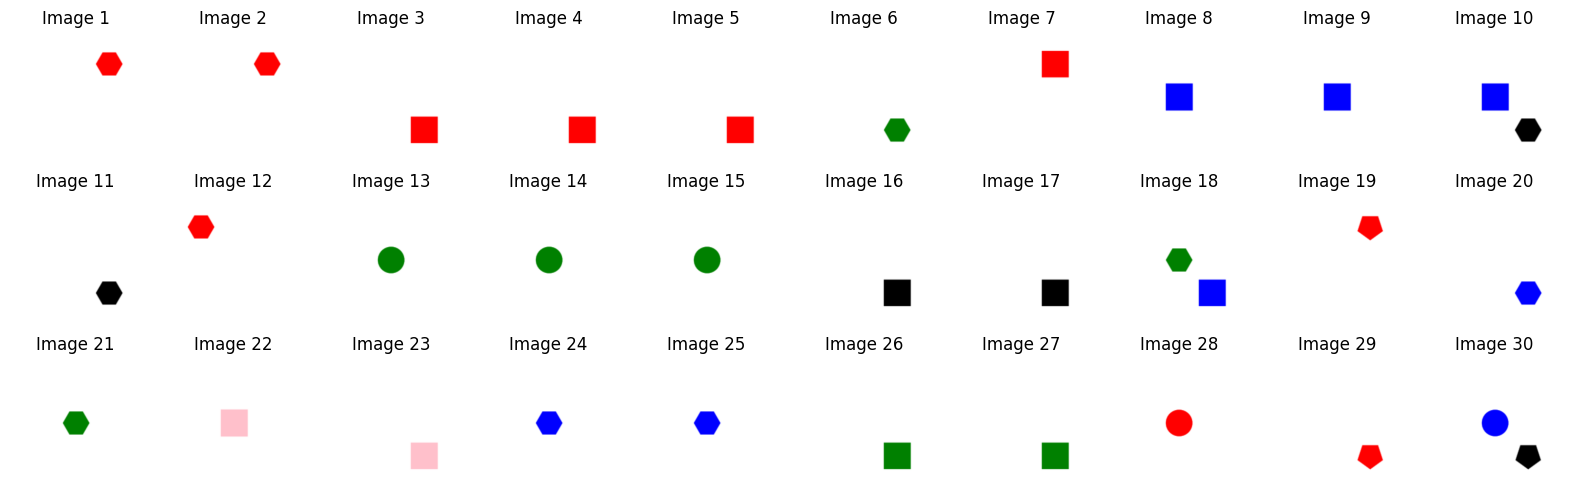

mean_15_709
[('black', np.float64(0.4666666666666667)), ('pentagon', np.float64(0.4333333333333333)), ('BR', np.float64(0.3666666666666666)), ('pink', np.float64(0.3333333333333333)), ('TL', np.float64(0.3333333333333333))]
Neuron: mean_15_709


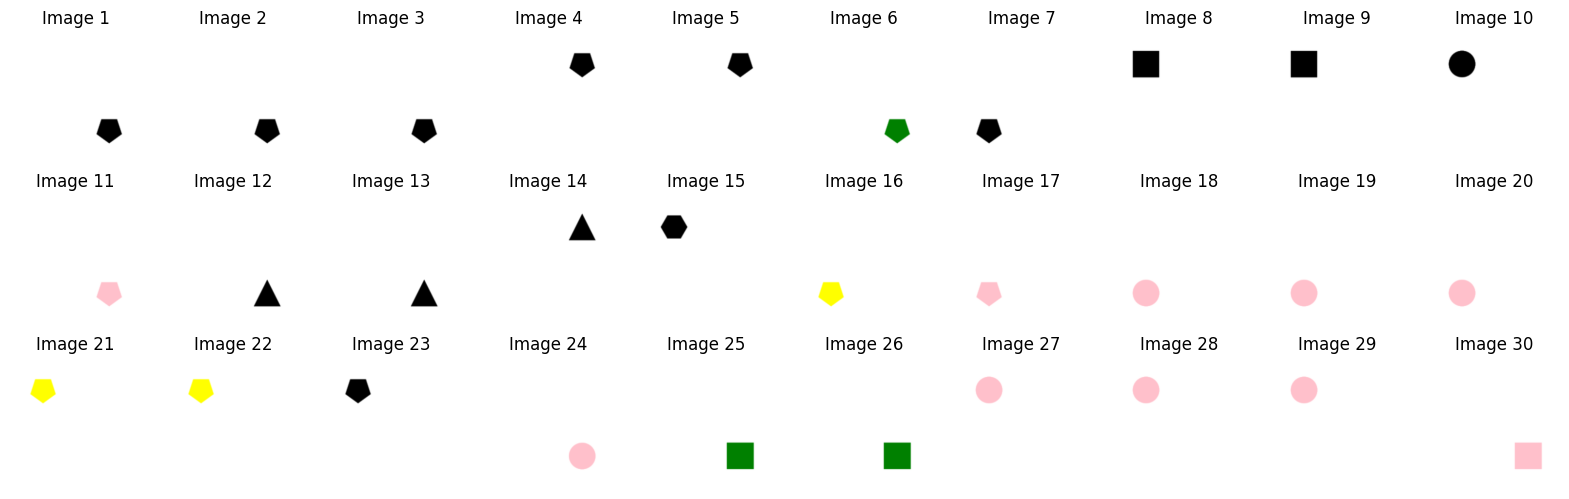

mean_22_153
[('M', np.float64(0.6666666666666666)), ('circle', np.float64(0.5666666666666667)), ('pink', np.float64(0.3666666666666666)), ('green', np.float64(0.3)), ('pentagon', np.float64(0.2333333333333333))]
Neuron: mean_22_153


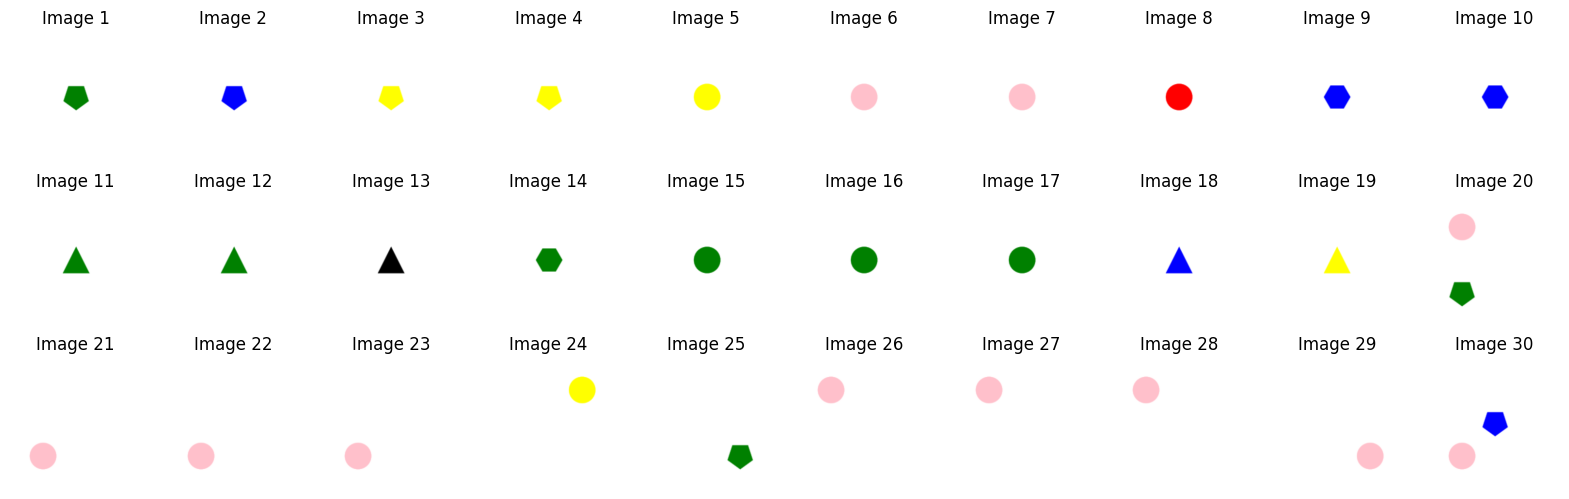

mean_18_223
[('pink', np.float64(0.5666666666666667)), ('circle', np.float64(0.5333333333333333)), ('TL', np.float64(0.3)), ('BL', np.float64(0.2666666666666666)), ('BR', np.float64(0.2333333333333333))]
Neuron: mean_18_223


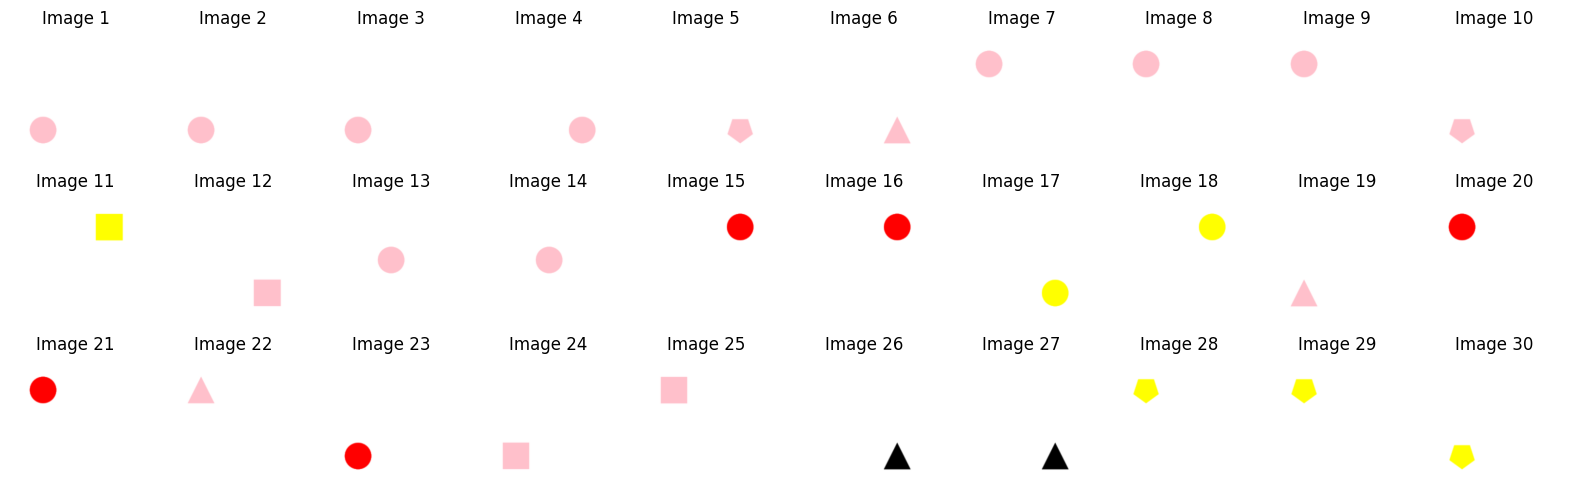

mean_21_466
[('M', np.float64(0.6333333333333333)), ('circle', np.float64(0.4)), ('pentagon', np.float64(0.3666666666666666)), ('green', np.float64(0.3)), ('pink', np.float64(0.2666666666666666))]
Neuron: mean_21_466


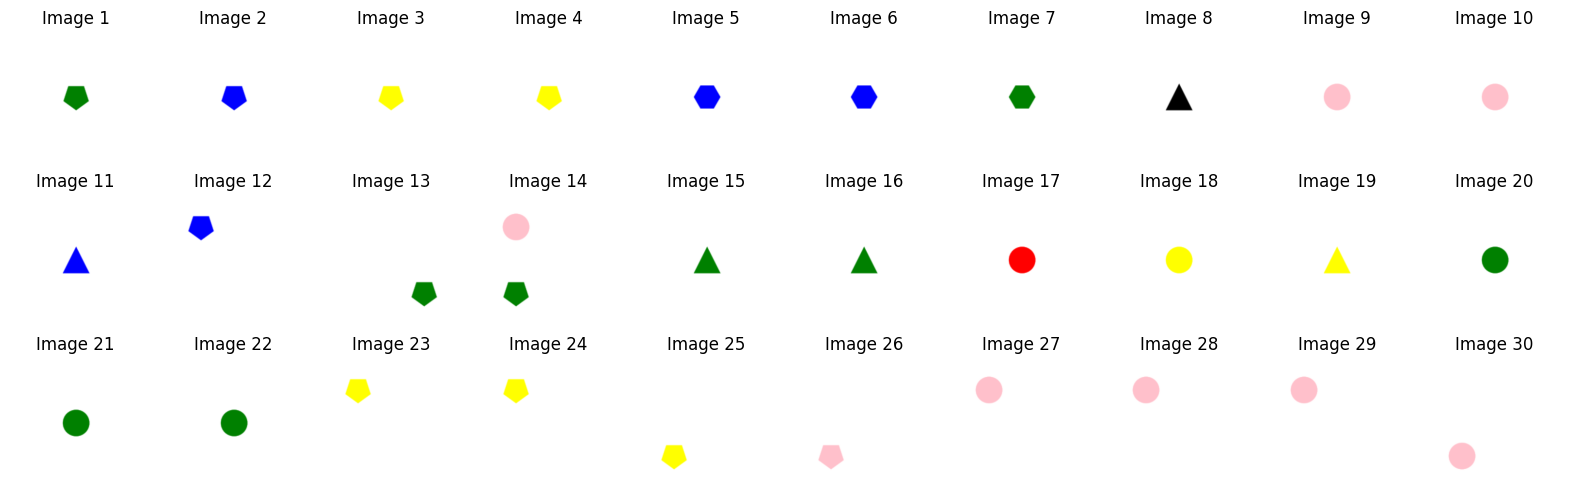

mean_18_381
[('circle', np.float64(0.5)), ('pink', np.float64(0.4333333333333333)), ('BR', np.float64(0.3333333333333333)), ('BL', np.float64(0.3)), ('pentagon', np.float64(0.2666666666666666))]
Neuron: mean_18_381


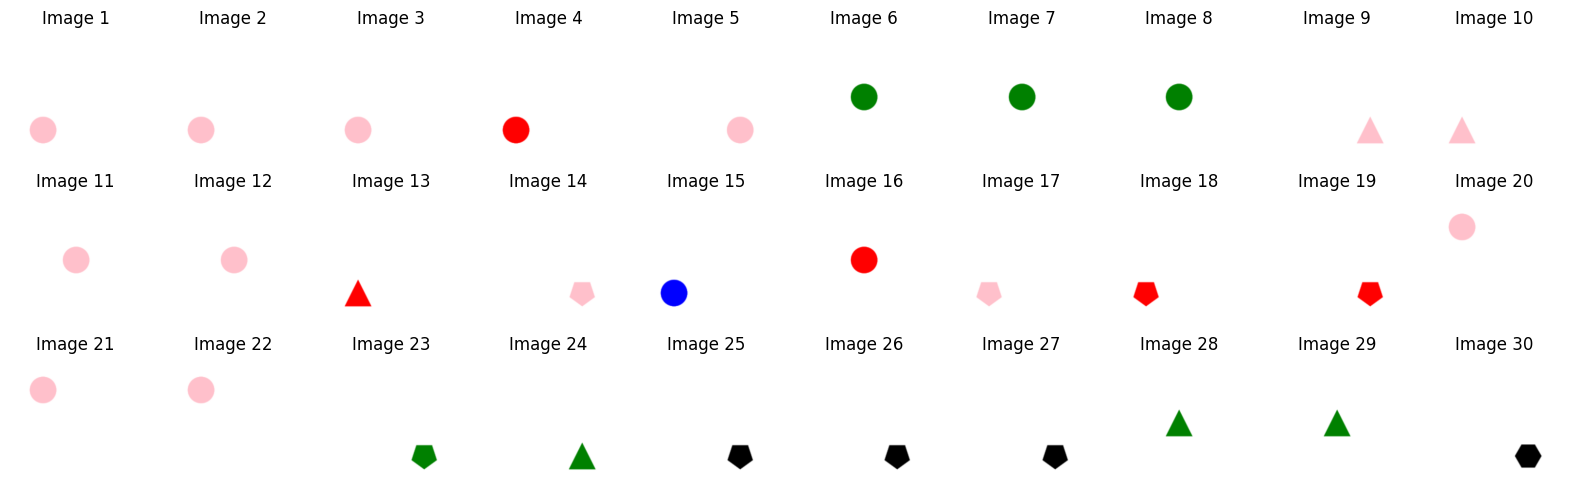

mean_16_263
[('pink', np.float64(0.7666666666666667)), ('circle', np.float64(0.4333333333333333)), ('square', np.float64(0.4333333333333333)), ('TL', np.float64(0.4)), ('yellow', np.float64(0.3333333333333333))]
Neuron: mean_16_263


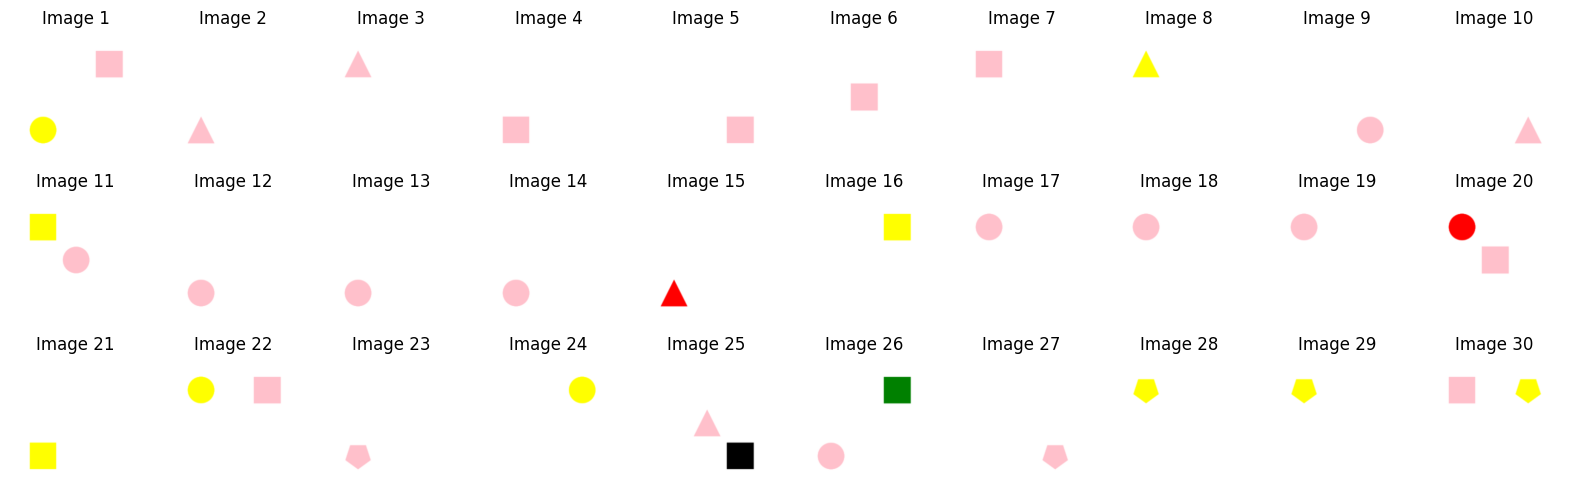

mean_20_590
[('M', np.float64(0.7)), ('circle', np.float64(0.3666666666666666)), ('pink', np.float64(0.3333333333333333)), ('green', np.float64(0.3)), ('pentagon', np.float64(0.2333333333333333))]
Neuron: mean_20_590


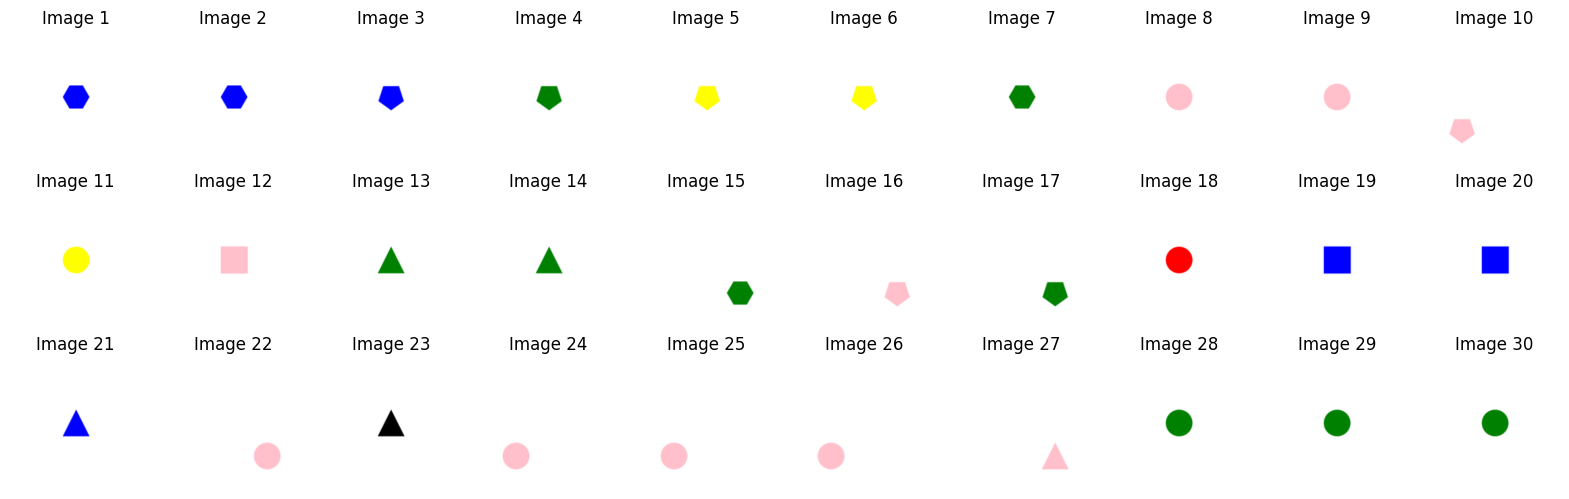

mean_20_389
[('pink', np.float64(0.7333333333333333)), ('circle', np.float64(0.5666666666666667)), ('yellow', np.float64(0.4)), ('square', np.float64(0.3666666666666666)), ('TL', np.float64(0.3333333333333333))]
Neuron: mean_20_389


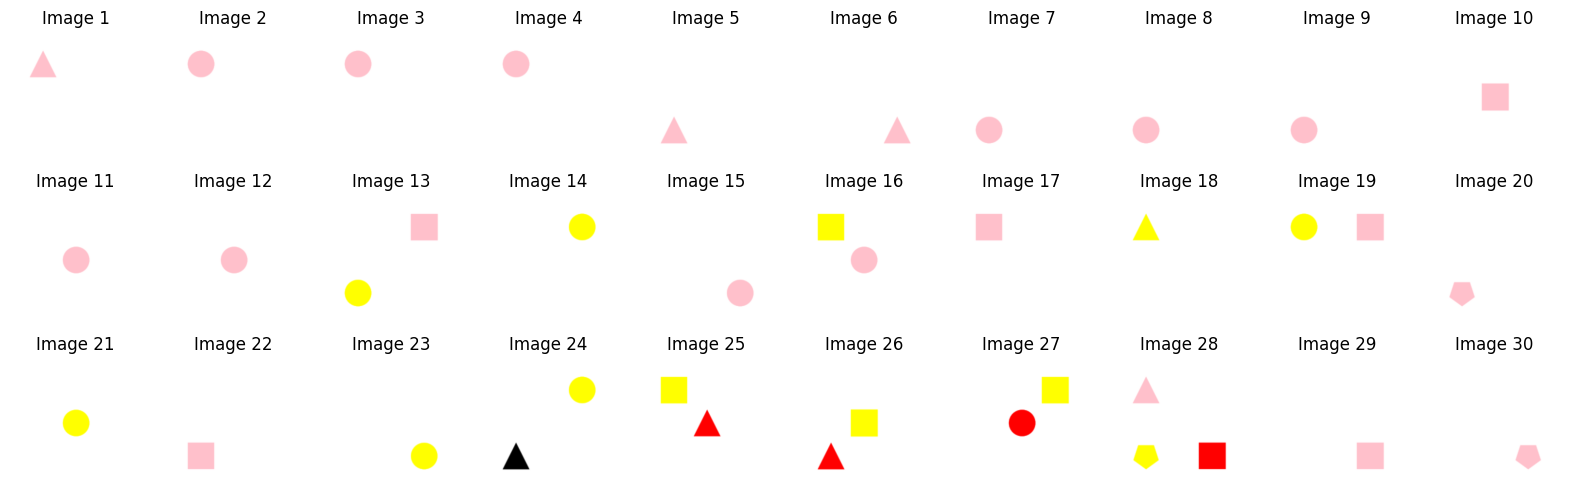

mean_20_451
[('M', np.float64(0.6666666666666666)), ('circle', np.float64(0.4666666666666667)), ('pink', np.float64(0.3333333333333333)), ('pentagon', np.float64(0.2333333333333333)), ('green', np.float64(0.2333333333333333))]
Neuron: mean_20_451


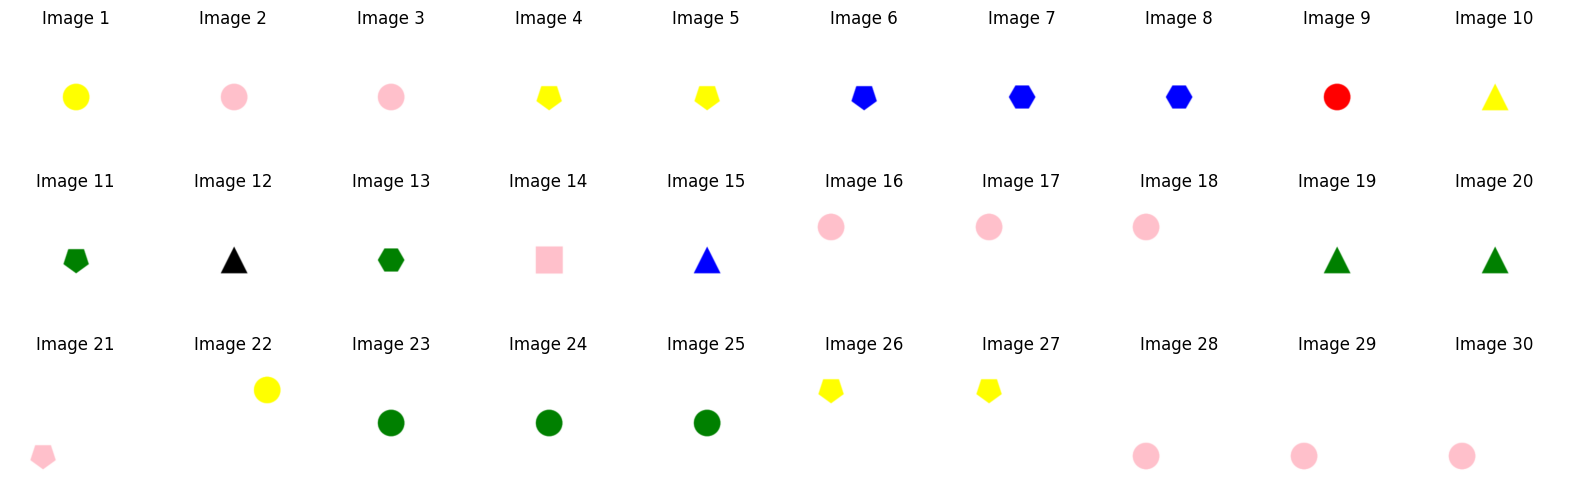

mean_17_643
[('M', np.float64(0.9)), ('blue', np.float64(0.4)), ('hexagon', np.float64(0.3666666666666666)), ('green', np.float64(0.3666666666666666)), ('circle', np.float64(0.3))]
Neuron: mean_17_643


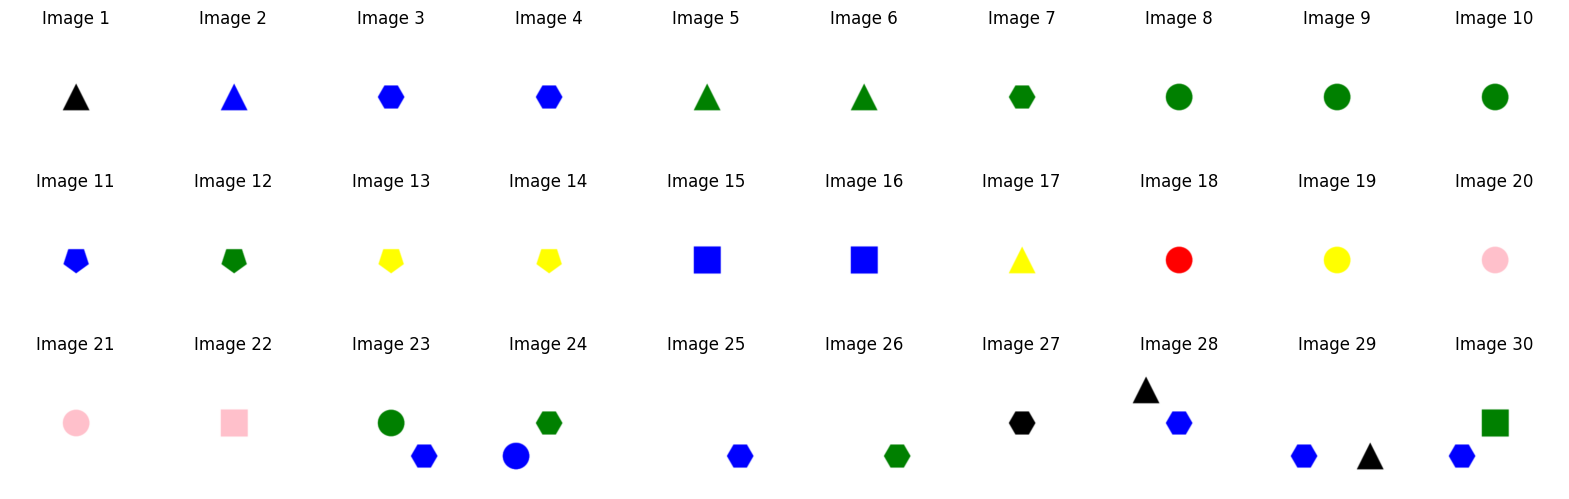

mean_21_499
[('M', np.float64(0.6333333333333333)), ('circle', np.float64(0.4)), ('pentagon', np.float64(0.3333333333333333)), ('green', np.float64(0.2666666666666666)), ('pink', np.float64(0.2666666666666666))]
Neuron: mean_21_499


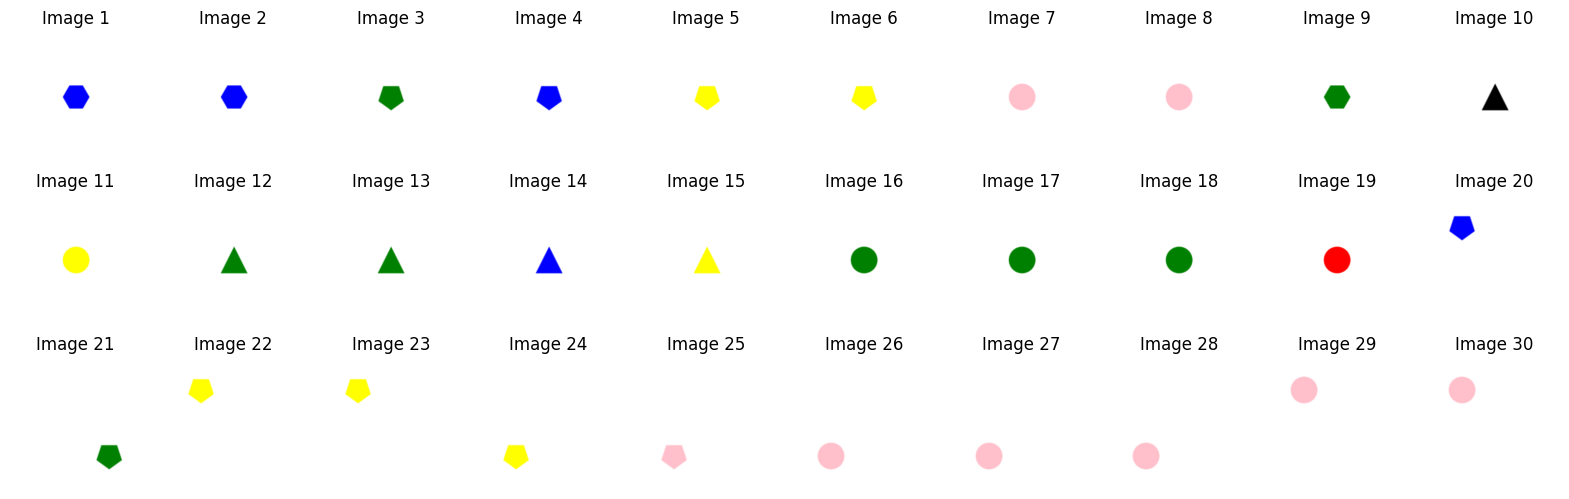

mean_17_14
[('M', np.float64(0.7666666666666667)), ('yellow', np.float64(0.3333333333333333)), ('circle', np.float64(0.2333333333333333)), ('green', np.float64(0.2333333333333333)), ('square', np.float64(0.2))]
Neuron: mean_17_14


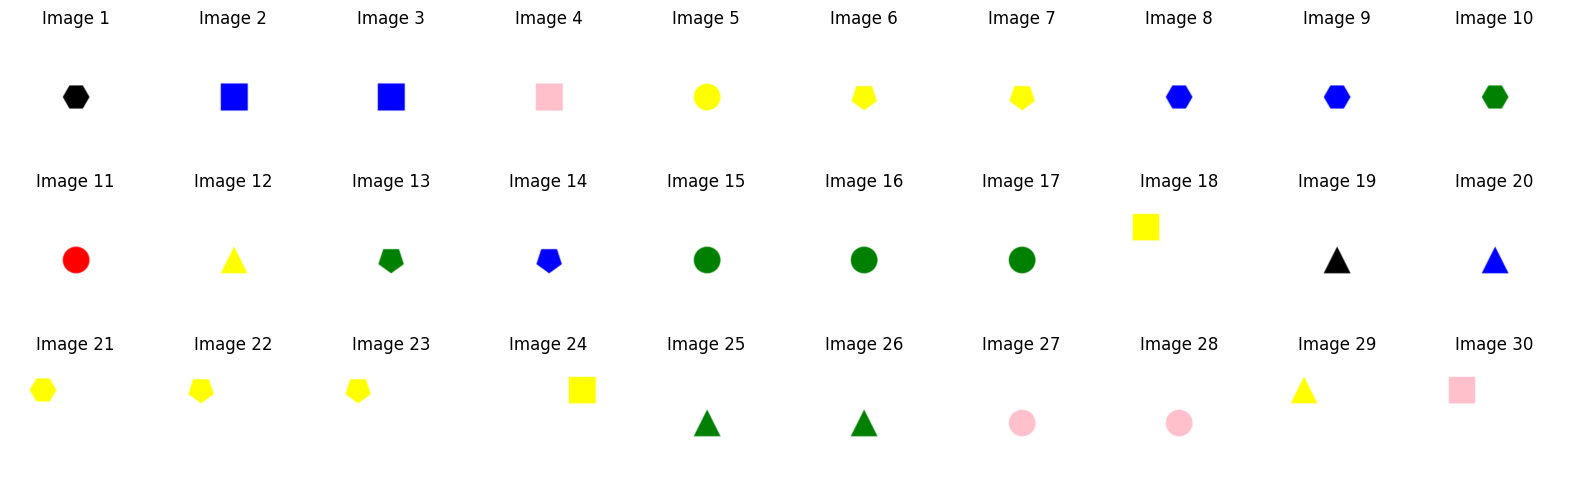

mean_16_553
[('black', np.float64(0.5666666666666667)), ('square', np.float64(0.5333333333333333)), ('BR', np.float64(0.4333333333333333)), ('pentagon', np.float64(0.2666666666666666)), ('TL', np.float64(0.2666666666666666))]
Neuron: mean_16_553


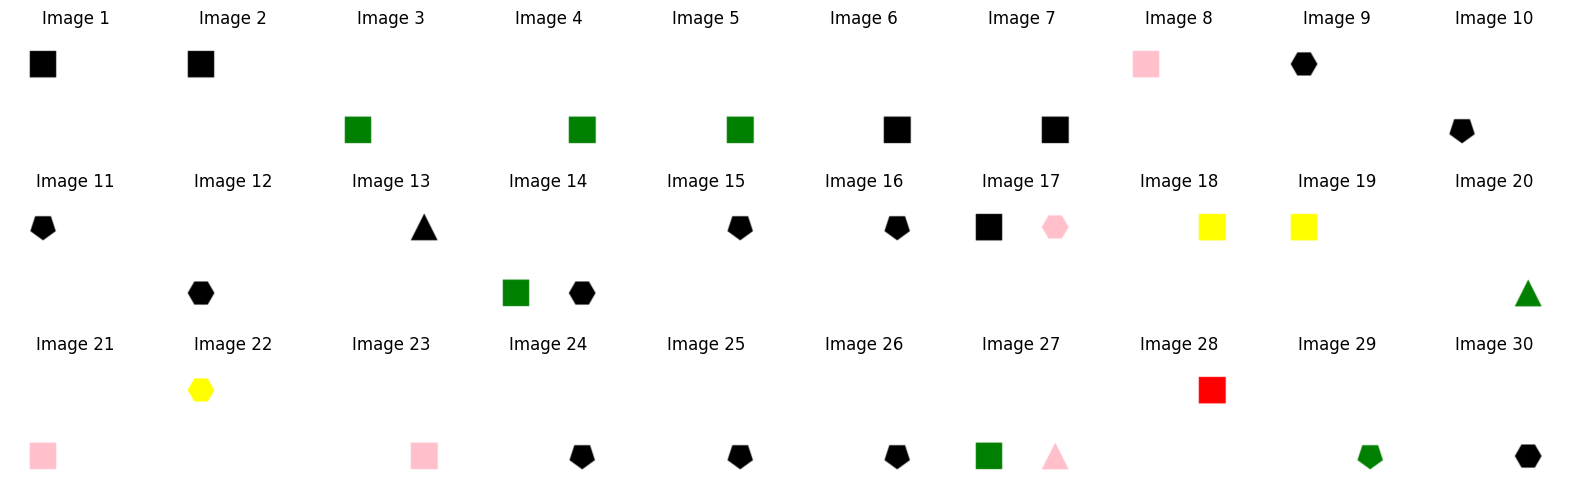

mean_16_991
[('circle', np.float64(0.5666666666666667)), ('pink', np.float64(0.5)), ('TL', np.float64(0.4333333333333333)), ('pentagon', np.float64(0.3)), ('BL', np.float64(0.3))]
Neuron: mean_16_991


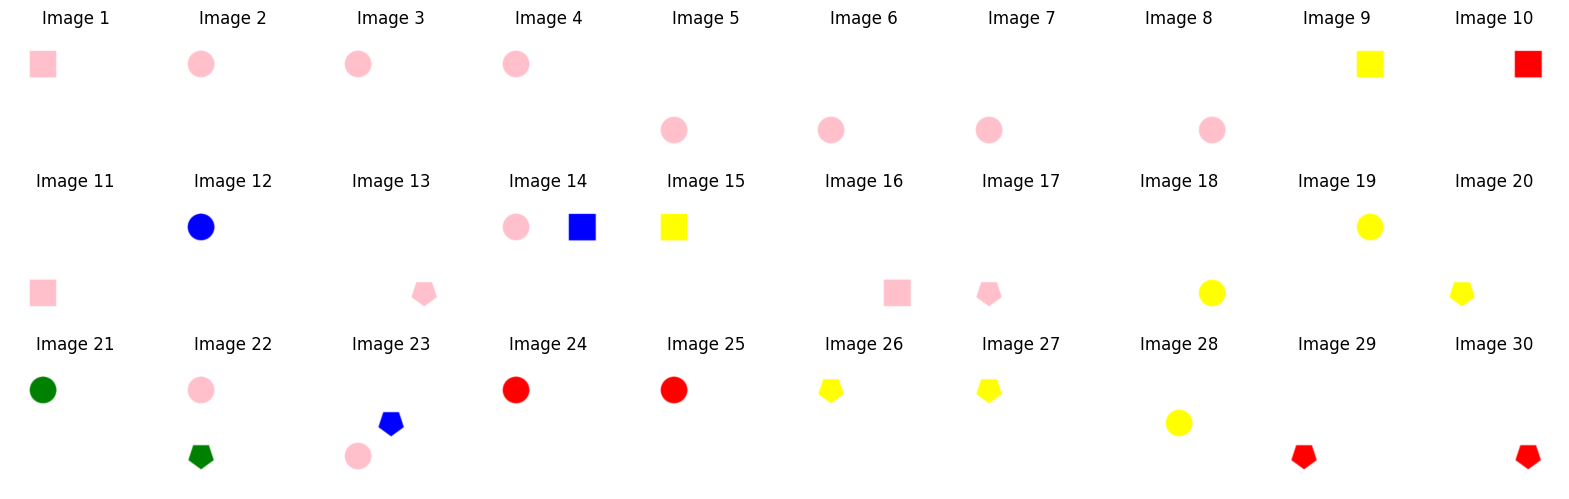

mean_20_151
[('M', np.float64(0.7333333333333333)), ('circle', np.float64(0.4333333333333333)), ('pink', np.float64(0.3333333333333333)), ('green', np.float64(0.2666666666666666)), ('blue', np.float64(0.2))]
Neuron: mean_20_151


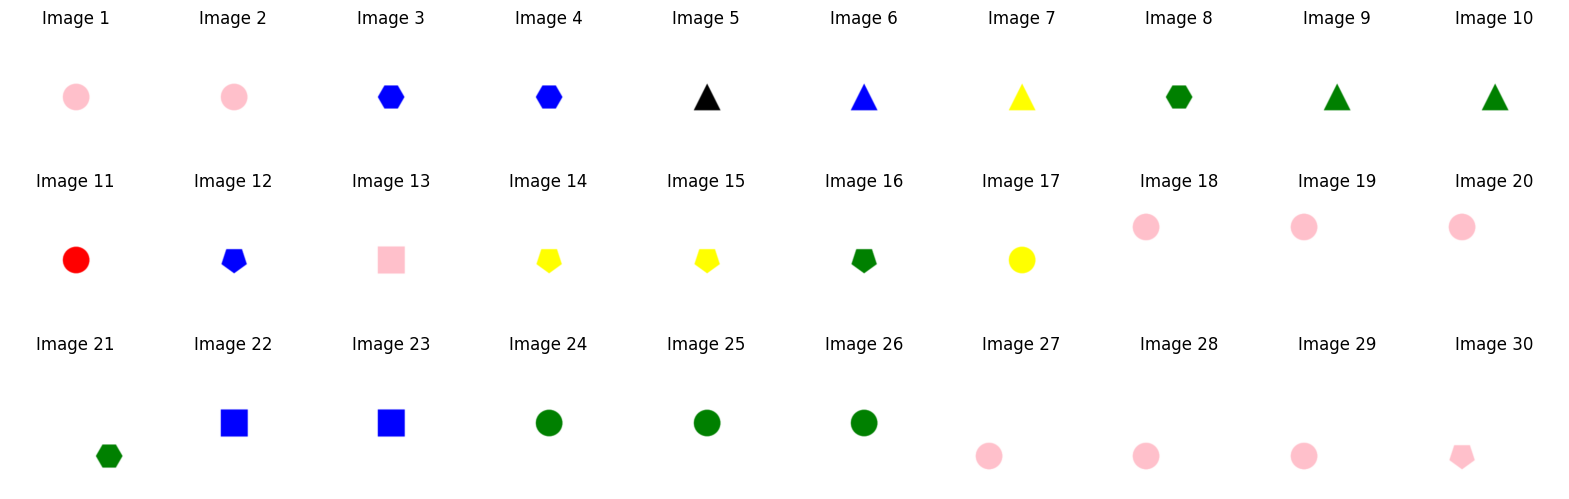

mean_18_591
[('circle', np.float64(0.6333333333333333)), ('pink', np.float64(0.4666666666666667)), ('yellow', np.float64(0.4)), ('M', np.float64(0.3666666666666666)), ('pentagon', np.float64(0.3))]
Neuron: mean_18_591


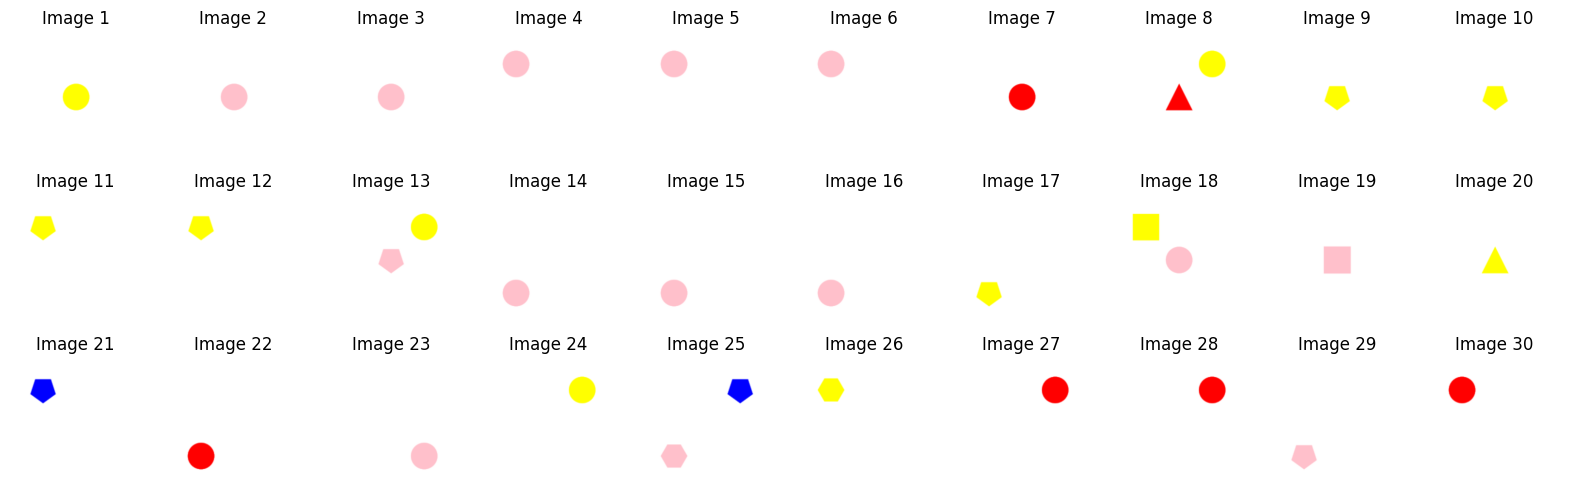

mean_19_714
[('M', np.float64(0.8333333333333334)), ('pentagon', np.float64(0.4)), ('circle', np.float64(0.3666666666666666)), ('green', np.float64(0.3333333333333333)), ('blue', np.float64(0.2666666666666666))]
Neuron: mean_19_714


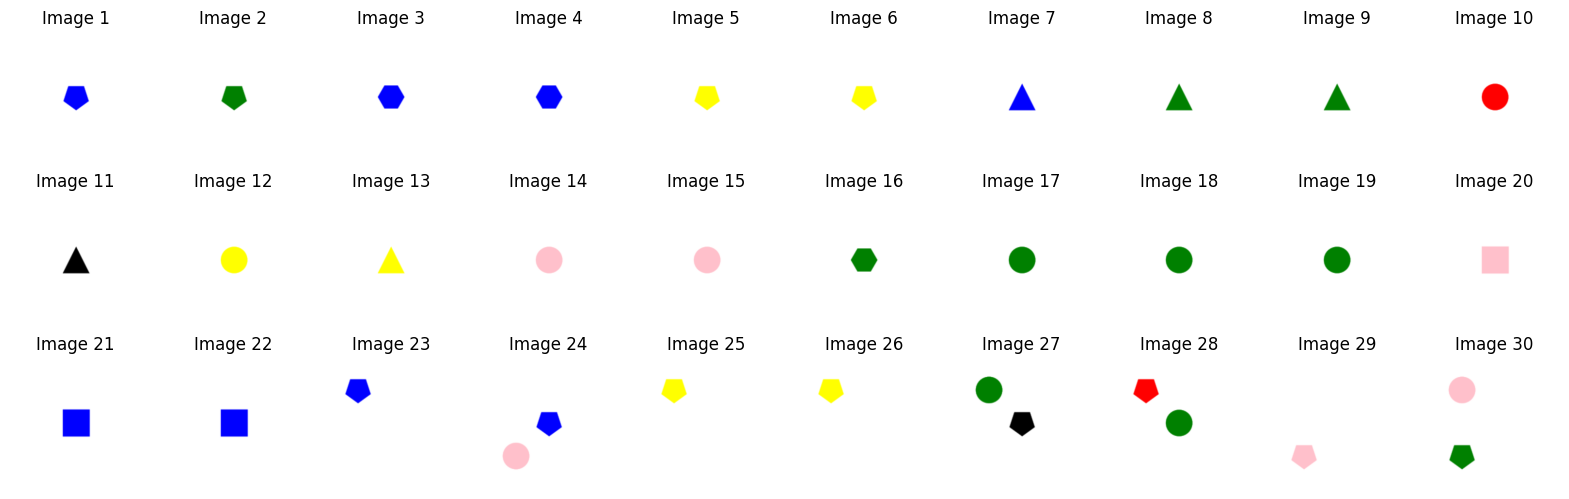

mean_19_605
[('M', np.float64(0.8333333333333334)), ('triangle', np.float64(0.4)), ('yellow', np.float64(0.4)), ('blue', np.float64(0.3666666666666666)), ('circle', np.float64(0.3333333333333333))]
Neuron: mean_19_605


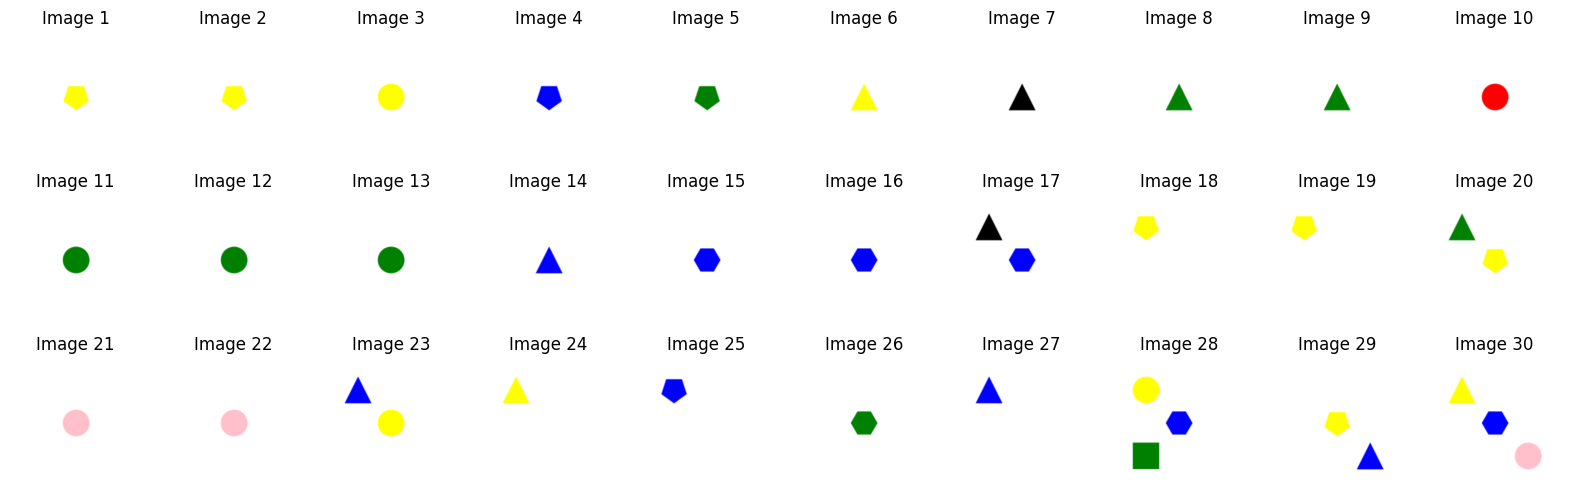

In [41]:
# neuron_name = 'mean_14_475' # square and circle?
# neuron_name = 'mean_17_774' # 
# find images that activate this neuron the most
for neuron_name in low_entropy_neurons['neuron_name']:
# for neuron_name in ['mean_21_200', 'mean_23_437']:
    print(neuron_name)
    top_feats = get_top_features(neuron_characteristics_df, neuron_name, top_k=5)

    print(top_feats)

    top_k = 30
    top_images = []

    activations = list(activations_df[neuron_name].items())
    activations.sort(key=lambda x: x[1], reverse=True)


    for i in range(top_k):
        row_idx = activations[i][0]
        image_path = activations_df.iloc[row_idx]['filename']
        top_images.append(image_path)


    # Plot the images in a row
    fig, axs = plt.subplots(3, 10, figsize=(20, 6))
    axs = axs.flatten()
    print(f"Neuron: {neuron_name}")
    for i in range(top_k):
        image = Image.open(top_images[i])
        image = transform(image)
        axs[i].imshow(image.permute(1,2,0))
        axs[i].axis('off')
        axs[i].set_title(f"Image {i+1}")
    plt.show()